# Quantitative Research Case Study
The attached file provides intraday price data for a set of Quantum Computing and related stocks in 15-minute increments. The purpose of this exercise is to use the time series above to learn to predict the intraday price curve of each ticker. Specifically, we would like to use 30 (calendar) days of intraday price data to predict the 31st day’s intraday return curve. An example of an intraday return curve is shown below, describing the return path of the particular stock over the course of the day. 

## For this problem, I decided to build an IntradayCurvePredictor class, which handles analysis, preprocessing, and predicting using ARIMA, VAR, and XGBoost.

In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from typing import Tuple, Dict
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
warnings.filterwarnings('ignore')

class IntradayCurvePredictor:
    """  
    This class provides tools for analyzing, preprocessing, and predicting intraday stock price movements
    using various time series models including ARIMA, VAR, and XGBoost. It implements feature engineering,
    stationarity testing, seasonal analysis, and cross-validation techniques.
    
    The class is designed to work with 15-minute interval stock data and has special handling for 
    quantum computing stocks and related market indices.
    
    Attributes:
        arima_model: Fitted ARIMA model for time series prediction
        arima_order: Order parameters (p,d,q) for the ARIMA model
        var_model: Fitted Vector Autoregression model
        xgb_model: Fitted XGBoost model
        returns: Dictionary of log returns for each ticker
        tickers: List of all tickers in the dataset
        index_tickers: List of market index tickers used as reference
        nyse_tickers: List of NYSE-traded quantum computing stocks
        nasdaq_tickers: List of NASDAQ-traded quantum computing stocks
        quantum_tickers: Combined list of all quantum computing stocks
    """
    def __init__(self):
        self.arima_model = None
        self.arima_order = None
        self.var_model = None
        self.xgb_model = None
        self.returns = None
        self.tickers = None
        self.index_tickers = ['ES1', 'NQ1', 'QTUM']
        self.nyse_tickers = ['IONQ', 'QBTS']
        self.nasdaq_tickers = ['RGTI', 'QUBT', 'QSI']
        self.quantum_tickers = self.nyse_tickers + self.nasdaq_tickers

    def check_returns_stationarity(self, df, alpha=0.05):
        """
        Test stationarity of log returns for each ticker using ADF and KPSS tests.
        
        Parameters:
        -----------
        df : pd.DataFrame
            The raw price DataFrame before feature engineering
        alpha : float, optional (default=0.05)
            The significance level for hypothesis testing
            
        Returns:
        --------
        dict
            Dictionary containing stationarity results for each ticker's returns including
            test statistics, p-values, critical values, and interpretation
        """
        warnings.filterwarnings('ignore')

        print("Checking stationarity of returns...")
        
        results = {}
        returns_dict = {}
        
        for ticker in self.tickers:
            price_series = df[ticker]['close']
            returns = np.log(price_series / price_series.shift(1)).dropna()
            returns_dict[ticker] = returns
            
            adf_result = adfuller(returns, autolag='AIC')
            adf_pvalue = adf_result[1]
            
            kpss_result = kpss(returns, regression='c', nlags='auto')
            kpss_pvalue = kpss_result[1]
            
            is_stationary = (adf_pvalue < alpha) and (kpss_pvalue > alpha)
            
            results[ticker] = {
                'is_stationary': is_stationary,
                'adf_pvalue': adf_pvalue,
                'kpss_pvalue': kpss_pvalue,
                'adf_statistic': adf_result[0],
                'kpss_statistic': kpss_result[0],
                'adf_critical_values': adf_result[4],
                'kpss_critical_values': kpss_result[3]
            }

            if is_stationary:
                results[ticker]['conclusion'] = 'Returns are stationary'
            else:
                print(f"WARNING: {ticker} returns are not stationary!")
                if adf_pvalue >= alpha and kpss_pvalue <= alpha:
                    results[ticker]['conclusion'] = 'Returns show signs of non-stationarity (both tests agree)'
                elif adf_pvalue < alpha:
                    results[ticker]['conclusion'] = 'Returns show mixed results (ADF suggests stationary, KPSS suggests non-stationary)'
                else:
                    results[ticker]['conclusion'] = 'Returns show mixed results (ADF suggests non-stationary, KPSS suggests stationary)'

        self.returns = returns_dict
        
        return results
        
    def parse_excel_to_df(self, filepath='quantum_price_data_winston.xlsx', exclude_settlement=False):
        """
        Parse Excel file containing price data into a formatted MutliIndex DataFrame.
        
        The Excel file should have a specific structure with ticker information in the 
        first three rows, followed by datetime, open, close, and volume columns for each ticker.
        
        Parameters:
        -----------
        filepath : str, default='quantum_price_data_winston.xlsx'
            Path to the Excel file containing price data
            
        Returns:
        --------
        pd.DataFrame
            A MultiIndex DataFrame with tickers as the first level and 
            fields (open, close, volume) as the second level
        """
        print(f"Parsing {filepath} to DataFrame...")
        headers_df = pd.read_excel(filepath, nrows=3)
        tickers = [x.split(' ')[0] for x in headers_df.iloc[1].dropna().tolist()]
        self.tickers = tickers
        min_dt = None
        max_dt = None
        
        dfs = {}
        for i in range(0,len(tickers)*5,5):
            df = pd.read_excel(filepath, skiprows=3, usecols=[i,i+1,i+2,i+3])
            ticker = tickers[i//5]
            df.columns = ['dt', 'open', 'close', 'volume']
            df['dt'] = pd.to_datetime(df['dt'])
            df = df.set_index('dt')
            df = df[df.index.notna()]
            _min_dt = df.index.min()
            _max_dt = df.index.max()
            if not min_dt:
                min_dt = _min_dt
            elif _min_dt < min_dt:
                min_dt = _min_dt
            if not max_dt:
                max_dt = _max_dt
            elif _max_dt > max_dt:
                max_dt = _max_dt
            dfs[ticker] = df
            print(f'{ticker} parsed')

        date_range = pd.date_range(min_dt, max_dt, freq='15T')
        
        # get stock market trading calendar and early closes
        nyse = mcal.get_calendar('NYSE')
        valid_days_nyse = nyse.valid_days(start_date=min_dt, end_date=max_dt).tz_localize(None).date
        schedule = nyse.schedule(start_date=min_dt, end_date=max_dt, tz='US/Eastern')
        early_closes = schedule[schedule['market_close'].dt.time != pd.Timestamp('16:00').time()]
        early_close_dates = early_closes.index.date
        market_hours_mask = (date_range.time >= pd.Timestamp('9:30').time()) & \
                            (date_range.time <= pd.Timestamp('16:15').time()) & \
                            (date_range.weekday < 5) & \
                            (pd.Series(date_range.date).isin(valid_days_nyse)) & \
                            (~pd.Series(date_range.date).isin(early_close_dates))
        market_hours = date_range[market_hours_mask]

        df = pd.concat(dfs, axis=1)
        df = df.reindex(index=market_hours)

        # align all closing prices and filter out duplicated prices
        settlement_1600_mask = (df.index.time == pd.Timestamp('16:00').time())
        settlement_1615_mask = (df.index.time == pd.Timestamp('16:15').time())
        df.loc[df.index[settlement_1600_mask], self.nasdaq_tickers] = df.loc[df.index[settlement_1615_mask], self.nasdaq_tickers].values
        clean_df = df[~(df.index.time == pd.Timestamp('16:15').time())]
        if exclude_settlement:
            clean_df = df[~(df.index.time == pd.Timestamp('16:00').time())]

        # given that only QUBT is missing at 2024-09-05 12:15 and QSI at 2024-10-07 14:15, ffill is a simple approach
        clean_df = clean_df.ffill()

        self.check_returns_stationarity(clean_df)
        
        return clean_df
        
    def safe_log_return(self, series):
        returns = np.log(series / series.shift(1))
        return returns.replace([np.inf, -np.inf], np.nan)
    
    def safe_division(self, a, b, fill_value=0):
        result = a / b
        return result.replace([np.inf, -np.inf], fill_value)
    
    def _harmonic_mean(self, values: np.ndarray) -> float:
        valid_values = values[values > 0]
        if len(valid_values) == 0:
            return np.nan
        return len(valid_values) / np.sum(1.0 / valid_values)
    
    def _calculate_basic_features(self, df):
        """
        Calculate basic price features from raw data.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing price data with open, close columns
            
        Returns:
        --------
        dict
            Dictionary of calculated features including intraperiod returns,
            mean prices, and price gaps
        """
        features = {}
        features[f'intraperiod_return'] = np.log(df['close'] / df['open'])
        features[f'mean_price'] = (df['open'] + df['close']) / 2
        features[f'gap'] = np.log(df['open'] / df['close'].shift(1)).fillna(0)
        return features

    def _calculate_rsi(self, returns, window=14):
        """
        Calculate Relative Strength Index (RSI) from returns.
        
        Parameters:
        -----------
        returns : pd.Series
            Series of returns
        window : int, default=14
            Window size for RSI calculation
            
        Returns:
        --------
        pd.Series
            Calculated RSI values (0-100 scale)
        """
        delta = returns
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def _calculate_volume_features(self, df, ticker):
        """
        Calculate volume-based features.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing price and volume data
        ticker : str
            Ticker symbol to calculate features for
            
        Returns:
        --------
        dict
            Dictionary of volume-based features including rolling averages,
            relative volumes, volume momentum, and price-volume correlations
        """
        features = {}
        volume = df[ticker]['volume']
        
        features[f'vol_ratio'] = self.safe_division(volume, volume.shift(1))
        features[f'log_vol'] = np.log1p(volume) 
    
        for window in [5, 10, 26]:
            vol_ma = volume.rolling(window=window, min_periods=1).mean()
            features[f'vol_ma_{window}'] = vol_ma
            features[f'vol_std_{window}'] = volume.rolling(window=window, min_periods=1).std()
            features[f'rel_vol_{window}'] = self.safe_division(volume, vol_ma)
            features[f'vol_mom_{window}'] = self.safe_division(volume, volume.shift(window))

        daily_groups = volume.groupby(volume.index.date)
        cumul_vol = pd.Series(index=volume.index, dtype=float)
        
        for day, group in daily_groups:
            daily_sum = group.sum()
            if daily_sum > 0:  
                cumul_vol[group.index] = group.cumsum() / daily_sum
            else:
                cumul_vol[group.index] = 0
        
        features[f'day_vol_pct'] = cumul_vol
        returns = self.safe_log_return(df[ticker]['close'])
        features[f'vol_weighted_ret'] = returns * features[f'rel_vol_5']
        
        for window in [4, 13, 26]:
            features[f'price_vol_corr_{window}'] = (
                returns.rolling(window, min_periods=1)
                .corr(features[f'log_vol'])
            )

        for window in [4, 13, 26]:
            key = f'price_vol_corr_{window}'
            features[key] = features[key].fillna(0)
        
        for k, v in features.items():
            if isinstance(v, pd.Series):
                features[k] = v.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        return features
    
    def _calculate_momentum_features(self, price, window):
        """
        Calculate momentum-based features.
        
        Parameters:
        -----------
        price : pd.Series
            Price series to calculate features for
        window : int
            Window size for calculations
            
        Returns:
        --------
        dict
            Dictionary of momentum-based features including momentum,
            moving averages, exponential moving averages, and volatility
        """
        features = {}
        features[f'momentum_{window}'] = self.safe_log_return(price.shift(window))
        features[f'MA_{window}'] = price.rolling(window=window, min_periods=1).mean()
        span = max(1, (window - 1)/2)
        features[f'EWMA_{window}'] = price.ewm(span=span, adjust=False).mean()
        returns = self.safe_log_return(price)
        features[f'vol_{window}'] = returns.rolling(window=window, min_periods=1).std()
        
        for k, v in features.items():
            if isinstance(v, pd.Series):
                features[k] = v.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        return features
    
    def _calculate_cross_ticker_features(self, returns_dict, window):
        """
        Calculate correlation features between tickers and market indices safely.
        
        Parameters:
        -----------
        returns_dict : dict
            Dictionary of return series for each ticker
        window : int
            Window size for rolling calculations
            
        Returns:
        --------
        dict
            Dictionary of cross-ticker features including correlations and
            relative strength metrics between tickers and indices
        """
        features = {}
        
        for ticker1 in self.quantum_tickers:
            # correlations with indices
            for index in self.index_tickers:
                features[f'{ticker1}_{index}_corr_{window}'] = (
                    returns_dict[ticker1].rolling(window=window, min_periods=1)
                    .corr(returns_dict[index])
                )
                features[f'{ticker1}_{index}_rel_strength_{window}'] = (
                    returns_dict[ticker1] - returns_dict[index]
                )
            
            # pairwise correlations with other quantum stocks
            for ticker2 in self.quantum_tickers[self.quantum_tickers.index(ticker1)+1:]:
                features[f'corr_{ticker1}_{ticker2}_{window}'] = (
                    returns_dict[ticker1].rolling(window=window, min_periods=1)
                    .corr(returns_dict[ticker2])
                )
                features[f'rel_strength_{ticker1}_{ticker2}_{window}'] = (
                    returns_dict[ticker1] - returns_dict[ticker2]
                )
        
        for k, v in features.items():
            if isinstance(v, pd.Series):
                features[k] = v.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        return features

    def _calculate_linear_slope(self, price, window):
        """
        Calculate linear slope using an expanding window approach.
        Uses at least 'window' points, but will use all available data for early points.
        
        Parameters:
        -----------
        price : pd.Series
            Price series to calculate slope for
        window : int
            Minimum window size
            
        Returns:
        --------
        list
            Slope values for each point in the price series
        """
        slopes = []
        
        for i in range(len(price)):
            start_idx = max(0, i - (window - 1))
            
            # need at least 2 points to calculate a slope
            if i - start_idx + 1 >= 2:
                x = np.arange(i - start_idx + 1)
                y = np.log(price.iloc[start_idx:i+1].values)
                try:
                    slope, _ = np.polyfit(x, y, 1)
                    slopes.append(slope)
                except Exception as e:
                    slopes.append(0) 
            else:
                slopes.append(0)
                
        return slopes

    def analyze_seasonality(self, df):
        """
        Analyze both intraday and weekly seasonality patterns in returns.
        
        Parameters:
        -----------
        df : pd.DataFrame
            MultiIndex DataFrame with (ticker, feature) columns
            
        Returns:
        --------
        dict
            Dictionary containing seasonality analysis results and features:
            - 'analysis': Detailed seasonality patterns by ticker
            - 'augmented_df': Original DataFrame with seasonal features added
        """
        results = {}
        
        for ticker in self.quantum_tickers:
            returns = self.returns[ticker]
            
            intraday_pattern = returns.groupby(returns.index.time).mean()
            intraday_std = returns.groupby(returns.index.time).std()

            weekly_pattern = returns.groupby(returns.index.dayofweek).mean()
            weekly_std = returns.groupby(returns.index.dayofweek).std()
            
            intraday_stats = self._test_intraday_seasonality(returns)
            weekly_stats = self._test_weekly_seasonality(returns)
            
            results[ticker] = {
                'intraday_pattern': intraday_pattern,
                'intraday_std': intraday_std,
                'weekly_pattern': weekly_pattern,
                'weekly_std': weekly_std,
                'intraday_stats': intraday_stats,
                'weekly_stats': weekly_stats
            }
            
        return {'analysis': results}
    
    def _test_intraday_seasonality(self, returns):
        """
        Perform statistical tests for intraday seasonality using Kruskal-Wallis test.
        
        Parameters:
        -----------
        returns : pd.Series
            Return series to analyze
            
        Returns:
        --------
        dict
            Dictionary containing test statistics, p-value, and effect size
        """
        
        time_groups = returns.groupby(returns.index.time)
        groups = [group for _, group in time_groups]
        h_stat, p_value = stats.kruskal(*groups)
        n = len(returns)
        epsilon_squared = (h_stat - len(groups) + 1) / (n - len(groups))
        
        return {
            'h_statistic': h_stat,
            'p_value': p_value,
            'effect_size': epsilon_squared
        }
    
    def _test_weekly_seasonality(self, returns):
        """
        Perform statistical tests for weekly seasonality using Kruskal-Wallis test.
        
        Parameters:
        -----------
        returns : pd.Series
            Return series to analyze
            
        Returns:
        --------
        dict
            Dictionary containing test statistics, p-value, and effect size
        """
        day_groups = returns.groupby(returns.index.dayofweek)
        groups = [group for _, group in day_groups]
        h_stat, p_value = stats.kruskal(*groups)
        n = len(returns)
        epsilon_squared = (h_stat - len(groups) + 1) / (n - len(groups))
        
        return {
            'h_statistic': h_stat,
            'p_value': p_value,
            'effect_size': epsilon_squared
        }
    
    def _interpret_effect_size(self, effect_size):
        """
        Interpret the magnitude of the effect size for seasonal analysis.
        """
        if effect_size < 0.01:
            return "Negligible effect"
        elif effect_size < 0.04:
            return "Small effect"
        elif effect_size < 0.16:
            return "Medium effect"
        else:
            return "Large effect"
    
    def visualize_seasonality(self, seasonality_results, analysis_type='returns'):
        """
        Visualize and interpret seasonality analysis results for both returns and volume.
        
        Parameters:
        -----------
        seasonality_results : dict
            Results from either analyze_seasonality or analyze_volume_seasonality
        analysis_type : str
            Either 'returns' or 'volume'
            
        Returns:
        --------
        dict
            Dictionary containing interpretations of seasonality patterns by ticker
        """
        def time_to_minutes(t):
            return (t.hour - 9) * 60 + t.minute - 30
        
        def safe_ratio(series):
            min_val = series[series > 0].min() if any(series > 0) else 1
            max_val = series.max() if not np.isnan(series.max()) else 1
            return max_val / min_val if min_val > 0 else 1
        
        def safe_extrema_time(series, func):
            try:
                if func == 'max':
                    idx = series.idxmax()
                else:
                    idx = series.idxmin()
                return idx.strftime('%H:%M') if idx is not None else 'N/A'
            except (AttributeError, ValueError):
                return 'N/A'
        
        if analysis_type == 'returns':
            results = seasonality_results['analysis']
        else:
            results = seasonality_results
        
        interpretations = {}
        
        for ticker in self.quantum_tickers:
            ticker_results = results[ticker]
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            times = ticker_results['intraday_pattern'].index
            minutes_since_open = [time_to_minutes(t) for t in times]

            pattern_values = ticker_results['intraday_pattern'].fillna(0).values
            std_values = ticker_results['intraday_std'].fillna(0).values
            
            ax1.plot(minutes_since_open, pattern_values, label='Mean')
            ax1.fill_between(minutes_since_open, 
                            pattern_values - std_values,
                            pattern_values + std_values,
                            alpha=0.3)
            ax1.set_xticks([0, 120, 240, 360])
            ax1.set_xticklabels(['9:30', '11:30', '13:30', '15:30'])
            title_prefix = 'Volume' if analysis_type == 'volume' else 'Return'
            ax1.set_title(f'{ticker} Intraday {title_prefix} Pattern')
            ax1.set_xlabel('Time of Day')
            ax1.set_ylabel(f'Mean {title_prefix}')
            ax1.grid(True, alpha=0.3)
            
            # weekly pattern
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
            weekly_values = ticker_results['weekly_pattern'].fillna(0).values
            ax2.bar(range(5), weekly_values)
            ax2.set_xticks(range(5))
            ax2.set_xticklabels(days, rotation=45)
            ax2.set_title(f'{ticker} Weekly {title_prefix} Pattern')
            ax2.set_xlabel('Day of Week')
            ax2.set_ylabel(f'Mean {title_prefix}')
            ax2.grid(True, alpha=0.3)
            
            # intraday volatility
            ax3.plot(minutes_since_open, std_values, 
                    color='orange', label=f'{title_prefix} Std')
            ax3.set_xticks([0, 120, 240, 360])
            ax3.set_xticklabels(['9:30', '11:30', '13:30', '15:30'])
            ax3.set_title(f'{ticker} Intraday {title_prefix} Volatility')
            ax3.set_xlabel('Time of Day')
            ax3.set_ylabel(f'{title_prefix} Std')
            ax3.grid(True, alpha=0.3)
            
            # stastical analysis
            if analysis_type == 'returns':
                intraday_stats = ticker_results['intraday_stats']
                weekly_stats = ticker_results['weekly_stats']
                
                interpretations[ticker] = {
                    'intraday_seasonality': {
                        'exists': intraday_stats['p_value'] < 0.05,
                        'strength': self._interpret_effect_size(intraday_stats['effect_size']),
                        'p_value': intraday_stats['p_value'],
                        'effect_size': intraday_stats['effect_size']
                    },
                    'weekly_seasonality': {
                        'exists': weekly_stats['p_value'] < 0.05,
                        'strength': self._interpret_effect_size(weekly_stats['effect_size']),
                        'p_value': weekly_stats['p_value'],
                        'effect_size': weekly_stats['effect_size']
                    }
                }
                
                stats_text = (
                    f"Intraday Analysis:\n"
                    f"Seasonality p-value: {intraday_stats['p_value']:.4f}\n"
                    f"Effect size: {intraday_stats['effect_size']:.4f}\n"
                    f"Interpretation: {interpretations[ticker]['intraday_seasonality']['strength']}\n\n"
                    f"Weekly Analysis:\n"
                    f"Seasonality p-value: {weekly_stats['p_value']:.4f}\n"
                    f"Effect size: {weekly_stats['effect_size']:.4f}\n"
                    f"Interpretation: {interpretations[ticker]['weekly_seasonality']['strength']}"
                )
            else:
                stats = ticker_results['stats']
                interpretations[ticker] = {
                    'seasonality': {
                        'exists': stats['p_value'] < 0.05,
                        'strength': self._interpret_effect_size(stats['effect_size']),
                        'p_value': stats['p_value'],
                        'effect_size': stats['effect_size']
                    }
                }
                
                intraday_pattern = ticker_results['intraday_pattern']
                volume_ratio = safe_ratio(intraday_pattern)
                peak_time = safe_extrema_time(intraday_pattern, 'max')
                trough_time = safe_extrema_time(intraday_pattern, 'min')
                
                stats_text = (
                    f"Volume Seasonality Analysis:\n"
                    f"Seasonality p-value: {stats['p_value']:.4f}\n"
                    f"Effect size: {stats['effect_size']:.4f}\n"
                    f"Interpretation: {interpretations[ticker]['seasonality']['strength']}\n\n"
                    f"Volume Pattern Metrics:\n"
                    f"Max/Min Ratio: {volume_ratio:.2f}\n"
                    f"Peak Time: {peak_time}\n"
                    f"Trough Time: {trough_time}"
                )
            
            ax4.text(0.05, 0.95, stats_text, fontsize=10, va='top', transform=ax4.transAxes)
            ax4.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return interpretations
    
    def augment_features(self, df):
        """
        Feature engineering including volume analysis.
        
        Creates a comprehensive set of features for time series prediction including
        price-based features, volume metrics, momentum indicators, technical indicators,
        and cross-asset relationship metrics.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Raw price and volume data
            
        Returns:
        --------
        pd.DataFrame
            Augmented MultiIndex DataFrame with all calculated features
        """
        augmented = df.copy()
        feature_dfs = []

        # basic, TA, and volume features
        for ticker in self.tickers:
            features = self._calculate_basic_features(augmented[ticker])
            if ticker in self.quantum_tickers:
                volume_features = self._calculate_volume_features(augmented, ticker)
                features.update(volume_features)

            ticker_df = pd.DataFrame({(ticker, k): v for k, v in features.items()}, index=df.index)
            price = ticker_df[(ticker, 'mean_price')]
            returns = self.returns[ticker]
    
            ticker_df[(ticker, 'RSI')] = self._calculate_rsi(returns)
    
            for window in [4, 13, 26]:
                mom_features = self._calculate_momentum_features(price, window)
                for k, v in mom_features.items():
                    ticker_df[(ticker, k)] = v
                    
                ticker_df[(ticker, f'slope_{window}')] = self._calculate_linear_slope(price, window)
    
            feature_dfs.append(ticker_df)
        
        augmented = pd.concat([augmented] + feature_dfs, axis=1)

        # cross ticker features
        cross_feature_dfs = []
        for window in [4, 13, 26]:
            cross_features = self._calculate_cross_ticker_features(self.returns, window)
            if all(hasattr(augmented[ticker], 'volume') for ticker in self.quantum_tickers):
                vol_features = self._calculate_cross_volume_features(augmented, window)
                cross_features.update(vol_features)
    
            cross_feature_df = pd.DataFrame(index=df.index)
            for feature_name, values in cross_features.items():
                parts = feature_name.split('_')
                if parts[0] in self.quantum_tickers:
                    ticker = parts[0]
                    cross_feature_df[(ticker, feature_name)] = values
    
            cross_feature_dfs.append(cross_feature_df)
    
        augmented = pd.concat([augmented] + cross_feature_dfs, axis=1)
        
        return augmented
    
    def _calculate_cross_volume_features(self, df, window):
        """
        Calculate cross-ticker volume features.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing volume data for multiple tickers
        window : int
            Window size for rolling calculations
            
        Returns:
        --------
        dict
            Dictionary of cross-volume features including correlations and relative volume metrics
        """
        features = {}
    
        for ticker1 in self.quantum_tickers:
            vol1 = df[ticker1]['volume']
            log_vol1 = np.log1p(vol1)
            
            for ticker2 in self.quantum_tickers[self.quantum_tickers.index(ticker1)+1:]:
                vol2 = df[ticker2]['volume']
                log_vol2 = np.log1p(vol2)
                
                features[f'{ticker1}_{ticker2}_vol_corr_{window}'] = (
                    log_vol1.rolling(window=window, min_periods=1)
                    .corr(log_vol2).fillna(0)
                )
                features[f'{ticker1}_{ticker2}_rel_vol_{window}'] = (
                    log_vol1.rolling(window=window, min_periods=1).mean() /
                    log_vol2.rolling(window=window, min_periods=1).mean()
                )
        
        return features

    def selective_feature_scaling(self, train_data, test_data=None):
        """
        Selectively scale features based on feature types.
        
        Ensures only appropriate features are standardized while preserving naturally 
        scaled features like percentages, correlations, and binary indicators.
        
        Parameters:
        -----------
        train_data : pd.DataFrame
            Training data with features to scale. Used to fit the scaler.
        test_data : pd.DataFrame or None, default None
            Optional test data to scale using parameters from training data.
            
        Returns:
        --------
        dict
            Dictionary containing:
            - 'train_scaled': Scaled training data
            - 'test_scaled': Scaled test data (if provided)
            - 'scaler': Fitted StandardScaler object
            - 'scaled_features': List of features that were scaled
            - 'unscaled_features': List of features that were not scaled
        """
        # list of naturally scaled or bounded feature name patterns to exclude
        no_scale_features = ['vol_ratio', 'log_vol', 'rel_vol', 'vol_mom', 'day_vol_pct', 
                             'vol_weighted_ret', 'price_vol_corr', 'RSI', 'momentum', 'corr_', 
                             '_corr_', 'time_morning', 'time_lunch', 'time_afternoon', 'dow_', 
                             'first_hour', 'last_hour', 'margin_percentage', '_pct', 'pct_', 
                             '_alert', 'alert_', '_flag', 'flag_']
        
        def should_scale_feature(feature_name):
            return not any(ns in str(feature_name) for ns in no_scale_features)
        
        train_scaled = train_data.copy()
        test_scaled = test_data.copy() if test_data is not None else None
        train_scaled = train_scaled.fillna(0)
        if test_scaled is not None:
            test_scaled = test_scaled.fillna(0)
        
        all_features = train_data.columns
        scale_features = [f for f in all_features if should_scale_feature(f)]
        unscaled_features = [f for f in all_features if not should_scale_feature(f)]
        
        print(f"Scaling {len(scale_features)} features, keeping {len(unscaled_features)} features unscaled")
        
        scaler = None
        if len(scale_features) > 0:
            try:
                scaler = StandardScaler()
                scaled_values = scaler.fit_transform(train_scaled[scale_features])
                train_scaled[scale_features] = scaled_values
                if test_scaled is not None:
                    test_scaled[scale_features] = scaler.transform(test_scaled[scale_features])
                    
                # verify
                if np.isnan(train_scaled[scale_features]).any().any():
                    print("WARNING: NaN values found in train_scaled after scaling!")
                if test_scaled is not None and np.isnan(test_scaled[scale_features]).any().any():
                    print("WARNING: NaN values found in test_scaled after scaling!")
                    
            except Exception as e:
                print(f"Error in scaling: {str(e)}")
                print("Falling back to no scaling due to error")
                scaler = StandardScaler()
        else:
            scaler = StandardScaler()
        
        return {
            'train_scaled': train_scaled,
            'test_scaled': test_scaled,
            'scaler': scaler,
            'scaled_features': scale_features,
            'unscaled_features': unscaled_features
        }

    def create_prediction_target(self, df, target_ticker, forward_periods=27, training=True):
        """
        Create target variable by shifting returns forward and omitting duplicate features.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing features
        target_ticker : str
            Ticker to predict returns for
        forward_periods : int, default 27
            Number of 15-minute periods to predict forward (typically one trading day)
        training : bool, default True
            Whether this is for training (will filter NaN rows) or prediction (will keep all rows)
        
        Returns:
        --------
        tuple
            (X, y) where X is the feature matrix and y is the target series
        """
        feature_cols = []
        
        time_features_added = set()
        corr_pairs_added = set()
        rel_strength_pairs_added = set()
        
        for col in df.columns:
            if isinstance(col, tuple):
                
                # this section removes duplicates of engineered features, especially cross ticker ones
                
                ticker, feature = col
                
                # skip price columns
                if feature in ['open', 'close']:
                    continue
                    
                if any(x in feature for x in ['forward', 'future', 'next']):
                    continue
                
                if any(x in feature for x in ['time_', 'dow_', 'first_hour', 'last_hour']):
                    if ticker == target_ticker and feature not in time_features_added:
                        feature_cols.append(col)
                        time_features_added.add(feature)
                    continue
                
                # remove duplicates from correlation features by sorting
                if 'corr_' in feature:
                    parts = feature.split('_')
                    if len(parts) >= 4: 
                        ticker1, ticker2 = sorted([parts[1], parts[2]])
                        window = parts[3]
                        corr_key = f"{ticker1}_{ticker2}_{window}"
                        if corr_key not in corr_pairs_added:
                            feature_cols.append(col)
                            corr_pairs_added.add(corr_key)
                    continue
                
                if 'rel_strength_' in feature:
                    parts = feature.split('_')
                    if len(parts) >= 4: 
                        # keep all index relative strength
                        if any(idx in feature for idx in ['ES1', 'NQ1', 'QTUM']):
                            feature_cols.append(col)
                        else:
                            ticker1, ticker2 = sorted([parts[1], parts[2]])
                            window = parts[3]
                            rel_key = f"{ticker1}_{ticker2}_{window}"
                            if rel_key not in rel_strength_pairs_added:
                                feature_cols.append(col)
                                rel_strength_pairs_added.add(rel_key)
                    continue
                
                if ticker == target_ticker:
                    feature_cols.append(col)
                
                elif any(x in feature for x in ['volume', 'vol_']):
                    feature_cols.append(col)
        
        X = df[feature_cols].copy()
        target = self.returns[target_ticker]
        aligned_target = target.reindex(X.index).fillna(0)
        
        if training:
            y = aligned_target.shift(-forward_periods)
            valid_idx = (~X.isna().any(axis=1)) & (~y.isna())
            X = X[valid_idx]
            y = y[valid_idx]
        else:
            y = aligned_target
            X = X.fillna(0)
        
        return X, y
    
    def analyze_feature_importance(self, X, y, n_splits=5):
        """
        Analyze feature importance using mutual information and correlation.
        
        Parameters:
        -----------
        X : pd.DataFrame
            Feature matrix
        y : pd.Series
            Target variable (returns)
        n_splits : int, default 5
            Number of cross-validation splits for MI estimation
            
        Returns:
        --------
        pd.DataFrame
            Feature importance metrics sorted by mutual information
        """
        
        assert len(X) == len(y), "X and y must have same length"
        assert (X.index == y.index).all(), "X and y must have same index"
    
        mi_scores = np.zeros(X.shape[1])
        tscv = TimeSeriesSplit(n_splits=n_splits)
        for train_idx, _ in tscv.split(X):
            X_train = X.iloc[train_idx]
            y_train = y.iloc[train_idx]
            mi_scores += mutual_info_regression(X_train, y_train)
        
        mi_scores /= n_splits
        correlations = X.corrwith(y)

        importance_df = pd.DataFrame({
            'feature': X.columns,
            'mutual_info': mi_scores,
            'correlation': correlations,
            'abs_correlation': correlations.abs()
        })
        
        return importance_df.sort_values('mutual_info', ascending=False)

    def reduce_dimensionality(self, X, var_threshold=0.95):
        """
        Apply temporal PCA to reduce feature dimensionality while preserving variance.
        
        Parameters:
        -----------
        X : pd.DataFrame
            Feature matrix
        var_threshold : float, default 0.95
            Minimum explained variance ratio to maintain
            
        Returns:
        --------
        tuple
            (transformed_X, pca_model, feature_loadings)
        """
        n_components = min(X.shape)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_var_ratio >= var_threshold) + 1
        X_pca = X_pca[:, :n_components]
        X_pca_df = pd.DataFrame(
            X_pca,
            index=X.index,
            columns=[f'PC{i+1}' for i in range(n_components)]
        )
        loadings = pd.DataFrame(
            pca.components_[:n_components].T,
            columns=[f'PC{i+1}' for i in range(n_components)],
            index=X.columns
        )
        
        return X_pca_df, pca, loadings
        
    def plot_cv_results(self, cv_results: dict):
        """
        Visualize cross-validation results with MSE, RMSE, and MAE metrics.
        
        Parameters:
        -----------
        cv_results : dict
            Dictionary containing cross-validation results from cross_validate_arima
        """

        fig = plt.figure(figsize=(15, 18))
        gs = plt.GridSpec(4, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0])    # RMSE over time
        ax2 = fig.add_subplot(gs[0, 1])    # MAE over time
        ax3 = fig.add_subplot(gs[1, 0])    # RMSE distribution
        ax4 = fig.add_subplot(gs[1, 1])    # MAE distribution
        ax5 = fig.add_subplot(gs[2, :])    # sample prediction
        ax6 = fig.add_subplot(gs[3, :])    # cumulative returns
        
        splits = range(1, len(cv_results['metrics_by_split']['rmse']) + 1)
        
        # RMSE plot
        ax1.plot(splits, cv_results['metrics_by_split']['rmse'], 
                 label='RMSE', marker='o', color='blue')
        ax1.axhline(y=cv_results['harmonic_metrics']['harmonic_rmse'], 
                    color='r', linestyle='--', 
                    label=f"Harmonic Mean: {cv_results['harmonic_metrics']['harmonic_rmse']:.6f}")
        ax1.set_title('RMSE Across CV Splits')
        ax1.set_xlabel('Split Number')
        ax1.set_ylabel('RMSE')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # MAE plot
        ax2.plot(splits, cv_results['metrics_by_split']['mae'], 
                 label='MAE', marker='o', color='green')
        ax2.axhline(y=cv_results['harmonic_metrics']['harmonic_mae'], 
                    color='r', linestyle='--', 
                    label=f"Harmonic Mean: {cv_results['harmonic_metrics']['harmonic_mae']:.6f}")
        ax2.set_title('MAE Across CV Splits')
        ax2.set_xlabel('Split Number')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # error distributions
        ax3.hist(cv_results['metrics_by_split']['rmse'], bins=20, 
                 alpha=0.7, color='blue', density=True)
        ax3.axvline(x=cv_results['harmonic_metrics']['harmonic_rmse'], 
                    color='r', linestyle='--', 
                    label=f"Harmonic Mean RMSE")
        ax3.set_title('Distribution of RMSE')
        ax3.set_xlabel('RMSE')
        ax3.set_ylabel('Density')
        ax3.legend()
        
        ax4.hist(cv_results['metrics_by_split']['mae'], bins=20, 
                 alpha=0.7, color='green', density=True)
        ax4.axvline(x=cv_results['harmonic_metrics']['harmonic_mae'], 
                    color='r', linestyle='--', 
                    label=f"Harmonic Mean MAE")
        ax4.set_title('Distribution of MAE')
        ax4.set_xlabel('MAE')
        ax4.set_ylabel('Density')
        ax4.legend()
        
        # predictions vs actuals on last day
        predictions = cv_results['predictions']
        unique_dates = pd.Series(predictions.index.date).unique()
        last_complete_date = None
        for date in unique_dates[::-1]:
            day_data = predictions[predictions.index.date == date]
            if len(day_data) >= 27:  # Complete trading day
                last_complete_date = date
                break
                
        if last_complete_date is None:
            raise ValueError("No complete trading days found in predictions")
            
        last_day_mask = predictions.index.date == last_complete_date
        last_day_data = predictions[last_day_mask]
        last_day_data = last_day_data.sort_index()
        
        times = last_day_data.index
        actuals = last_day_data['actual']
        preds = last_day_data['predicted']
        
        ax5.plot(times, actuals, label='Actual', marker='.', linestyle='-', color='blue')
        ax5.plot(times, preds, label='Predicted', marker='.', linestyle='-', color='orange')
        ax5.set_title(f'Sample Prediction ({last_complete_date})')
        ax5.set_xlabel('Time')
        ax5.set_ylabel('Return')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        actual_cum_returns = np.exp(actuals.cumsum())
        pred_cum_returns = np.exp(preds.cumsum())
        
        ax6.plot(times, actual_cum_returns, label='Actual Cumulative Return', color='blue')
        ax6.plot(times, pred_cum_returns, label='Predicted Cumulative Return', color='orange')
        ax6.set_title(f'Cumulative Returns ({last_complete_date})')
        ax6.set_xlabel('Time')
        ax6.set_ylabel('Cumulative Return')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def plot_all_cumulative_returns(self, cv_results: dict):
        """
        Plot all actual vs predicted cumulative return curves for each CV split.
        
        Parameters:
        -----------
        cv_results : dict
            Dictionary containing cross-validation results from cross_validate_arima
        """
        predictions = cv_results['predictions']
        
        for date in pd.Series(predictions.index.date).unique():
            actuals = predictions.loc[date.strftime('%Y-%m-%d'), 'actual']
            preds = predictions.loc[date.strftime('%Y-%m-%d'), 'predicted']
            times = predictions.loc[date.strftime('%Y-%m-%d')].index
            
            actual_cum_returns = np.exp(actuals.cumsum())
            pred_cum_returns = np.exp(preds.cumsum())
            
            fig, ax = plt.subplots(figsize=(12, 6))
            
            ax.plot(times, actual_cum_returns, linestyle='-', alpha=0.7, label=f'Actual {date}')
            ax.plot(times, pred_cum_returns, linestyle='--', alpha=0.7, label=f'Predicted {date}')
            
            ax.set_title(f'Cumulative Returns for {date}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Cumulative Return')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()  # To make sure the plot elements fit nicely
            plt.show()

    def analyze_acf_pacf(self, returns: pd.Series, lags: int = 40):
        """
        Analyze ACF and PACF of returns to suggest ARIMA parameters with improved analysis.
        
        Parameters:
        -----------
        returns : pd.Series
            Return series to analyze
        lags : int, default 40
            Number of lags to include in analysis
        """
        def find_longest_consecutive(lags):
            if len(lags) == 0:
                return 0
            
            longest = 1
            current = 1
            
            for i in range(1, len(lags)):
                if lags[i] == lags[i-1] + 1:
                    current += 1
                else:
                    longest = max(longest, current)
                    current = 1
            
            return max(longest, current)
        
        def find_cutoff_lag(lags):
            if len(lags) == 0:
                return 0
                
            cutoff = 0
            for i, lag in enumerate(lags):
                if i == 0 or lag == lags[i-1] + 1:
                    cutoff = lag
                else:
                    break
        
            return cutoff
        
        def check_seasonality(lags, min_gap=3, max_gap=24):
            if len(lags) < 2:
                return None
                
            # calculate differences between consecutive significant lags
            differences = [lags[i] - lags[i-1] for i in range(1, len(lags))]
            
            # count occurrences of each difference
            diff_counts = {}
            for diff in differences:
                if min_gap <= diff <= max_gap:    # only consider reasonable seasonal periods
                    diff_counts[diff] = diff_counts.get(diff, 0) + 1
                    
            # find the most common difference
            if not diff_counts:
                return None
                
            most_common = max(diff_counts.items(), key=lambda x: x[1])
            
            # only suggest seasonality if the pattern appears multiple times
            if most_common[1] >= 2:
                return most_common[0]
            return None
            
        acf_values = acf(returns.dropna(), nlags=lags)
        pacf_values = pacf(returns.dropna(), nlags=lags)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        confidence_band = 1.96/np.sqrt(len(returns))
        
        ax1.plot(range(lags + 1), acf_values, 'b.')
        ax1.axhline(y=0, color='k', linestyle='-')
        ax1.axhline(y=confidence_band, color='k', linestyle='--')
        ax1.axhline(y=-confidence_band, color='k', linestyle='--')
        ax1.set_title('Autocorrelation Function')
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('ACF')

        ax2.plot(range(lags + 1), pacf_values, 'b.')
        ax2.axhline(y=0, color='k', linestyle='-')
        ax2.axhline(y=confidence_band, color='k', linestyle='--')
        ax2.axhline(y=-confidence_band, color='k', linestyle='--')
        ax2.set_title('Partial Autocorrelation Function')
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('PACF')
        
        plt.tight_layout()
        plt.show()
        
        significant_acf_lags = np.where(np.abs(acf_values[1:]) > confidence_band)[0] + 1
        significant_pacf_lags = np.where(np.abs(pacf_values[1:]) > confidence_band)[0] + 1
        
        acf_consecutive = find_longest_consecutive(significant_acf_lags)
        pacf_consecutive = find_longest_consecutive(significant_pacf_lags)
        
        acf_cutoff = find_cutoff_lag(significant_acf_lags)
        pacf_cutoff = find_cutoff_lag(significant_pacf_lags)

        acf_seasonal_period = check_seasonality(significant_acf_lags)
        pacf_seasonal_period = check_seasonality(significant_pacf_lags)
        
        seasonal_period = acf_seasonal_period
        if pacf_seasonal_period and (not acf_seasonal_period or 
                                   significant_pacf_lags.size > significant_acf_lags.size):
            seasonal_period = pacf_seasonal_period
        
        print("\nARIMA Parameter Suggestions:")
        print("-" * 40)
        print(f"Significant ACF lags: {significant_acf_lags.tolist()}")
        print(f"Significant PACF lags: {significant_pacf_lags.tolist()}")
        print(f"Total significant ACF lags: {len(significant_acf_lags)}")
        print(f"Total significant PACF lags: {len(significant_pacf_lags)}")
        print(f"Longest consecutive significant ACF lags: {acf_consecutive}")
        print(f"Longest consecutive significant PACF lags: {pacf_consecutive}")
        print(f"ACF cutoff lag: {acf_cutoff}")
        print(f"PACF cutoff lag: {pacf_cutoff}")

        # cap at 5 lags
        p = min(pacf_cutoff, 5)  
        q = min(acf_cutoff, 5)   
        
        # if ACF decays slowly and PACF cuts off sharply, suggest AR model
        if len(significant_acf_lags) > 3 * len(significant_pacf_lags) and pacf_cutoff > 0:
            p = min(pacf_cutoff, 5)
            q = 0
            print("\nPattern suggests an AR process.")
        
        # if PACF decays slowly and ACF cuts off sharply, suggest MA model
        elif len(significant_pacf_lags) > 3 * len(significant_acf_lags) and acf_cutoff > 0:
            p = 0
            q = min(acf_cutoff, 5)
            print("\nPattern suggests an MA process.")
        
        # if neither cuts off clearly, suggest mixed ARMA model
        else:
            print("\nPattern suggests a mixed ARMA process.")
        
        print("\nSuggested ARIMA parameters:")
        print(f"ARIMA(p={p}, d=0, q={q})")
        
        # check for stationarity
        if hasattr(self, 'stationarity_results') and not self.stationarity_results.get('is_stationary', True):
            print("Note: Returns appear non-stationary, consider using d=1")
            print(f"ARIMA(p={p}, d=1, q={q})")
        
        # report potential seasonality
        if seasonal_period:
            print(f"\nPotential seasonal pattern detected with period {seasonal_period}")
            print(f"Consider a seasonal ARIMA model (SARIMA):")
            print(f"SARIMA(p={p}, d=0, q={q})(P=1, D=0, Q=1, s={seasonal_period})")
            print("Note: Verify this seasonal pattern makes sense for your data context")
            
        # report isolated significant lags
        scattered_lags = [lag for lag in significant_acf_lags if lag > acf_cutoff]
        if scattered_lags and not seasonal_period:
            print(f"\nIsolated significant lags detected at: {scattered_lags}")
            
        return {
            'significant_acf_lags': significant_acf_lags.tolist(),
            'significant_pacf_lags': significant_pacf_lags.tolist(),
            'acf_cutoff': acf_cutoff,
            'pacf_cutoff': pacf_cutoff,
            'suggested_p': p,
            'suggested_q': q,
            'seasonal_period': seasonal_period
        }

    def create_arima_predictor(self,
                               returns, 
                               order=(2, 0, 1),
                               training_days=30,
                               step_size=27,
                               n_splits=None,
                               cross_validation=True,
                               multi_step=True):
        """
        Create an ARIMA model for time series prediction.
        Can perform time series cross-validation or predict the next day.
        
        Parameters:
        -----------
        returns : pd.Series
            Return series to model
        order : tuple, default (2, 0, 1)
            ARIMA model order (p, d, q)
        training_days : int, default 30
            Number of calendar days for training window
        step_size : int, default 27
            Number of 15-minute periods in a trading day
        n_splits : int or None, default None
            Number of walk-forward splits to perform (if cross_validation=True)
        cross_validation : bool, default True
            Whether to perform walk-forward validation or just predict next day
        multi_step : bool, default True
            Whether to use direct multi-step forecasting (True) or iterative one-step forecasting (False)
        
        Returns:
        --------
        dict
            If cross_validation=True: Dictionary with validation results, metrics
            If cross_validation=False: Dictionary with predictions for next day and model
        """
        
        if cross_validation:
            print("\nRunning ARIMA in walk-forward cross-validation mode")
            if multi_step:
                print("Using direct multi-step forecasting (forecasting entire day at once)")
            else:
                print("Using iterative one-step forecasting (with model updates after each period)")
            
            metrics = {
                'mse': [],
                'rmse': [],
                'mae': []
            }
            
            predictions = []
            actuals = []
            dates = []
            used_test_days = set()
            
            print("\nStarting cross-validation with debug info:")
            print("-" * 50)
            print(f"Total data points: {len(returns)}")
            print(f"Full data range: {returns.index[0]} to {returns.index[-1]}")
            print(f"Available trading days: {len(pd.Series(returns.index.date).unique())}")
            print(f"Training window: {training_days} calendar days")
            print(f"Step size: {step_size} periods (1 trading day)")
            
            # find all trading days (9:30am times)
            market_opens = returns.index[returns.index.time == pd.Timestamp('09:30').time()]
            trading_days = pd.Series(market_opens.date)
            current_start_date = pd.Timestamp(returns.index[0].date())
            split_count = 0
            
            max_splits = len(trading_days) - 1 if n_splits is None else n_splits
            
            final_model = None
            final_order = order
            
            while split_count < max_splits:
                train_end_date = current_start_date + pd.Timedelta(days=training_days)
                
                train_mask = pd.Series(
                    (returns.index.date >= current_start_date.date()) & 
                    (returns.index.date < train_end_date.date()),
                    index=returns.index
                )
                train = returns[train_mask]
                
                print(f"\nSplit {split_count + 1}:")
                print(f"Training period: {current_start_date.date()} to {train_end_date.date()}")
                print(f"Training data points: {len(train)}")
                print(f"Training days: {len(pd.Series(train.index.date).unique())}")
                
                # next available trading day after training period
                future_trading_days = trading_days[trading_days > train_end_date.date()]
                if len(future_trading_days) == 0:
                    print("No more trading days available for testing")
                    break
                    
                test_day = future_trading_days.iloc[0]
                
                # if test day was already used, move forward one day and continue
                if test_day in used_test_days:
                    print(f"Test day {test_day} already used, moving window forward")
                    current_start_date = current_start_date + pd.Timedelta(days=1)
                    continue
                    
                test_start_time = pd.Timestamp.combine(test_day, pd.Timestamp('09:30').time())
                test_start_idx = returns.index.searchsorted(test_start_time)
                test_end_idx = test_start_idx + step_size
                
                # check if we have enough data
                if test_end_idx > len(returns):
                    print("Not enough data for test period")
                    break
                    
                test = returns[test_start_idx:test_end_idx]
                
                # verify we have complete trading day for test
                if len(test) != step_size:
                    print(f"Skipping: Incomplete trading day ({len(test)} intervals)")
                    current_start_date = current_start_date + pd.Timedelta(days=1)
                    continue
                
                print(f"Test day: {test_day}")
                print(f"Test range: {test.index[0]} to {test.index[-1]}")
                
                try:
                    if multi_step:
                        # predicting entire day at once
                        model = ARIMA(train, order=order)
                        fitted = model.fit()
                        final_model = fitted
                        forecasts = fitted.forecast(steps=len(test)).values
                    else:
                        model = ARIMA(train, order=order)
                        fitted = model.fit()
                        final_model = fitted
                        forecasts = []
                        history = train.copy()
                        for _ in range(len(test)):
                            model = ARIMA(history, order=order)
                            fitted = model.fit()
                            forecast = fitted.forecast(steps=1).iloc[0]
                            forecasts.append(forecast)
                            history = pd.concat([history, test.iloc[_:_+1]])
                    
                    predictions.extend(forecasts)
                    actuals.extend(test)
                    dates.extend(test.index)
                    
                    mse = mean_squared_error(test, forecasts)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(test, forecasts)
                    
                    metrics['mse'].append(mse)
                    metrics['rmse'].append(rmse)
                    metrics['mae'].append(mae)
                    
                    print(f"Forecast generated successfully - RMSE: {rmse:.6f}")
                    print(f"Forecast generated successfully - MAE: {mae:.6f}")
                    
                    used_test_days.add(test_day)
                    current_start_date = current_start_date + pd.Timedelta(days=1)
                    split_count += 1
                    
                except Exception as e:
                    print(f"Error in split {split_count + 1}: {str(e)}")
                    current_start_date = current_start_date + pd.Timedelta(days=1)
                    continue
            
            self.arima_model = final_model
            self.arima_order = order
            
            harmonic_metrics = {
                'harmonic_mse': self._harmonic_mean(np.array(metrics['mse'])),
                'harmonic_rmse': self._harmonic_mean(np.array(metrics['rmse'])),
                'harmonic_mae': self._harmonic_mean(np.array(metrics['mae']))
            }
            
            avg_metrics = {
                'mean_mse': np.mean(metrics['mse']),
                'mean_rmse': np.mean(metrics['rmse']),
                'mean_mae': np.mean(metrics['mae']),
                'std_mse': np.std(metrics['mse']),
                'std_rmse': np.std(metrics['rmse']),
                'std_mae': np.std(metrics['mae'])
            }
            
            results_df = pd.DataFrame({
                'actual': actuals,
                'predicted': predictions
            }, index=dates)
            
            return {
                'metrics_by_split': metrics,
                'harmonic_metrics': harmonic_metrics,
                'avg_metrics': avg_metrics,
                'predictions': results_df,
                'n_splits_completed': len(metrics['mse']),
                'model': final_model,
                'order': order,
                'forecast_method': 'multi_step' if multi_step else 'one_step'
            }
        
        else:
            print("\nRunning ARIMA in prediction mode (no cross-validation)")
            
            # get the most recent data for training
            all_dates = pd.Series(returns.index.date).unique()
            if len(all_dates) < 2:
                raise ValueError("Not enough data to make predictions")
            
            train_start_date = all_dates[-min(training_days, len(all_dates))]
            train_end_date = all_dates[-1]  # Most recent date
            
            train_mask = (returns.index.date >= train_start_date) & (returns.index.date <= train_end_date)
            train = returns[train_mask]
            
            print(f"Training period: {train_start_date} to {train_end_date}")
            print(f"Training data points: {len(train)}")
            print(f"Training days: {len(pd.Series(train.index.date).unique())}")
            
            try:
                model = ARIMA(train, order=order)
                fitted = model.fit()
    
                print("\nARIMA Model Summary:")
                print(f"Order: {order}")
                print(f"AIC: {fitted.aic:.4f}")
                print(f"BIC: {fitted.bic:.4f}")
                
                forecasts = fitted.forecast(steps=step_size)
                next_day = train_end_date + pd.Timedelta(days=1)
                next_day_open = pd.Timestamp.combine(next_day, pd.Timestamp('09:30').time())
                next_day_periods = [next_day_open + pd.Timedelta(minutes=15*i) for i in range(step_size)]
                
                predictions_df = pd.DataFrame({
                    'predicted': forecasts.values
                }, index=next_day_periods[:len(forecasts)])
                
                self.arima_model = fitted
                self.arima_order = order
                
                print(f"\nGenerated {len(forecasts)} predictions for {next_day.date()}")
                
                return {
                    'predictions': predictions_df,
                    'model': fitted,
                    'order': order,
                    'last_training_date': train_end_date,
                    'prediction_date': next_day,
                    'model_summary': {
                        'aic': fitted.aic,
                        'bic': fitted.bic,
                        'params': fitted.params
                    }
                }
                
            except Exception as e:
                print(f"Error fitting ARIMA model: {str(e)}")
                import traceback
                traceback.print_exc()
                raise ValueError("Failed to create ARIMA prediction model")

    def create_var_predictor(self, raw_df, target_ticker, training_days=30, forward_periods=27,
                          n_features=5, n_corr_stocks=2, n_splits=None, cross_validation=True,
                          use_pca=False, pca_variance=0.95):
        """
        Create VAR model with proper feature augmentation and feature selection.
        
        Implements Vector Autoregression with robust validation and multicollinearity checks.
        Can perform walk-forward validation or predict the next day.
        
        Parameters:
        -----------
        raw_df : pd.DataFrame
            Raw price and volume data with MultiIndex (ticker, field) columns
        target_ticker : str
            Target ticker to predict
        training_days : int, default 30
            Number of calendar days for training window
        forward_periods : int, default 27
            Number of 15-minute periods to predict
        n_features : int, default 5
            Number of top engineered features to include
        n_corr_stocks : int, default 2
            Number of most correlated stocks to include
        n_splits : int or None, default None
            Number of walk-forward splits to perform (if cross_validation=True)
        cross_validation : bool, default True
            Whether to perform walk-forward validation or just predict next day
        use_pca : bool, default False
            Whether to use PCA-derived features instead of raw engineered features
        pca_variance : float, default 0.95
            Target explained variance ratio for PCA component selection
                
        Returns:
        --------
        dict
            If cross_validation=True: Dictionary with validation results, metrics
            If cross_validation=False: Dictionary with predictions for next day and model
        """

        def reduce_multicollinearity(X, threshold=3):
            features = list(X.columns)
            n = len(features)
            removed_features = []
            
            max_iter = 100
            iteration = 0
            
            while len(features) > 1 and iteration < max_iter:
                vif_data = pd.DataFrame()
                vif_data["feature"] = features
                vif_data["VIF"] = [variance_inflation_factor(X[features].values, i) 
                                   for i in range(len(features))]
                
                max_vif = vif_data["VIF"].max()
                if max_vif < threshold:
                    break
                    
                feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
                features.remove(feature_to_remove)
                removed_features.append(feature_to_remove)
                
                print(f"Removed feature '{feature_to_remove}' with VIF {max_vif:.2f}")
                iteration += 1
            
            print(f"Removed {len(removed_features)} features due to high VIF")
            print(f"Remaining {len(features)} features with VIF < {threshold}")
            
            return X[features], removed_features
            
        print("\nData Preparation and Feature Selection for VAR Model:")
        print("-" * 60)
        
        start_date = raw_df.index[0].date()
        end_date = raw_df.index[-1].date()
        print(f"Input data range: {start_date} to {end_date}")

         # initialize and train the model on the first set, and walk forward cross validate on subsequent sets
        if cross_validation:
            print(f"\nRunning in walk-forward cross-validation mode {'with PCA' if use_pca else 'with raw features'}")
            
            metrics = {'mse': [], 'rmse': [], 'mae': []}
            predictions_df = pd.DataFrame(columns=['actual', 'predicted'])
            var_diagnostics = []
            used_predict_days = set()
            
            market_opens = raw_df.index[raw_df.index.time == pd.Timestamp('09:30').time()]
            trading_days = sorted(set(market_opens.date))
            
            final_fitted_model = None
            final_features = None
            final_scaler = None
            top_features = None
            significant_pairs = []
            loadings = None
            pca_model = None
            n_pca_components = None
            
            print("\nStarting VAR Model Walk-Forward Validation:")
            print("-" * 60)
            
            split_count = 0
            
            # determine maximum number of splits if n_split = None
            max_splits = len(trading_days) - 2 if n_splits is None else min(n_splits, len(trading_days) - 2)
            
            current_date_idx = 0
            train_start_date = trading_days[0]
            train_end_idx = 0
            while (train_end_idx < len(trading_days) - 2 and 
                   (trading_days[train_end_idx] - train_start_date).days < training_days):
                train_end_idx += 1
            train_end_date = trading_days[train_end_idx]
            
            train_mask = ((raw_df.index.date >= train_start_date) & 
                         (raw_df.index.date <= train_end_date))
            initial_train_raw = raw_df[train_mask].copy()
            
            # augment features
            initial_train_augmented = self.augment_features(initial_train_raw)
            X_initial_train, y_initial_train = self.create_prediction_target(initial_train_augmented, 
                                                                             target_ticker, 
                                                                             forward_periods=forward_periods, 
                                                                             training=True)
            
            print("\nCalculating feature importance to be used across all splits...")
            importance_df = self.analyze_feature_importance(X_initial_train, y_initial_train)
            top_features = importance_df.nlargest(n_features, 'mutual_info')['feature'].tolist()
            print("\nSelected top features based on mutual information (used for all splits):")
            for i, feat in enumerate(top_features):
                score = importance_df.loc[feat, 'mutual_info']
                print(f"{i+1}. {feat} (MI: {score:.4f})")
            
            # start multicollinearity check
            initial_var_train_df = pd.DataFrame()
            
            # add target stock returns and index returns
            initial_var_train_df[target_ticker] = self.returns[target_ticker].loc[X_initial_train.index]
            for index in self.index_tickers:
                initial_var_train_df[index] = self.returns[index].loc[X_initial_train.index]
            
            # add top engineered features by MI
            if not use_pca:
                for feature in top_features:
                    if feature in X_initial_train.columns:
                        initial_var_train_df[f'feature_{feature}'] = X_initial_train[feature]
            
            # create PCA model once with initial training data
            if use_pca:
                print("\nCreating PCA model from initial training window (will be reused for all splits)...")
                feature_df = pd.DataFrame(index=X_initial_train.index)
                for feature in X_initial_train.columns:
                    feature_df[feature] = X_initial_train[feature]
                    
                X_pca, pca_model, loadings = self.reduce_dimensionality(
                    feature_df, var_threshold=pca_variance
                )
                n_pca_components = X_pca.shape[1]
                
                print(f"Created PCA model with {n_pca_components} components explaining {pca_variance:.0%} of variance")
                print("This PCA transformation will be reused across ALL splits")
                
                for col in X_pca.columns:
                    initial_var_train_df[f'pca_{col}'] = X_pca[col]
            
            # add top n_corr_stocks
            target_returns = self.returns[target_ticker]
            correlations = {}
            for ticker in self.quantum_tickers:
                if ticker != target_ticker:
                    corr = target_returns.corr(self.returns[ticker])
                    correlations[ticker] = abs(corr)
            
            top_corr_tickers = sorted(correlations.items(), 
                                     key=lambda x: x[1], 
                                     reverse=True)[:n_corr_stocks]
            
            print("\nCorrelated Quantum Stocks (used for all splits):")
            for ticker, corr in top_corr_tickers:
                print(f"- {ticker} (correlation: {corr:.3f})")
                initial_var_train_df[ticker] = self.returns[ticker].loc[X_initial_train.index]
            
            # scale data
            if not use_pca:
                print("\nApplying selective feature scaling to initial data...")
                initial_scaling_results = self.selective_feature_scaling(initial_var_train_df)
                initial_var_train_scaled = initial_scaling_results['train_scaled']
                
                # check for multicollinearity 
                print("\nChecking for multicollinearity (this will be applied to all splits)...")
                initial_var_train_scaled_reduced, initially_removed_features = reduce_multicollinearity(initial_var_train_scaled, threshold=8.0)
                multicollinearity_approved_columns = initial_var_train_scaled_reduced.columns
                print(f"Identified {len(multicollinearity_approved_columns)} features to use across all splits after multicollinearity check")
                print(f"Removed {len(initially_removed_features)} features due to multicollinearity: {initially_removed_features}")
            else:
                # don't need to check for multicollinearity if using PCA
                multicollinearity_approved_columns = initial_var_train_df.columns
                print("\nUsing PCA components - no multicollinearity check needed")

            # begin cross validation loop
            while split_count < max_splits and current_date_idx < len(trading_days) - 2:
                try:
                    train_start_date = trading_days[current_date_idx]
                    train_end_idx = current_date_idx
                    while (train_end_idx < len(trading_days) - 2 and 
                           (trading_days[train_end_idx] - train_start_date).days < training_days):
                        train_end_idx += 1
                        
                    if train_end_idx >= len(trading_days) - 1:
                        print("Insufficient remaining data for training and prediction")
                        break
                        
                    train_end_date = trading_days[train_end_idx]
                    predict_date_idx = train_end_idx + 1
                    predict_date = trading_days[predict_date_idx]
                    
                    # # if test day was already used, move forward one day and continue
                    if predict_date in used_predict_days:
                        current_date_idx += 1
                        continue
                    
                    train_mask = ((raw_df.index.date >= train_start_date) & 
                                 (raw_df.index.date <= train_end_date))
                    train_raw = raw_df[train_mask].copy()

                    predict_day_start = pd.Timestamp.combine(predict_date, pd.Timestamp('09:30').time())
                    predict_day_end = pd.Timestamp.combine(predict_date, pd.Timestamp('16:00').time())
            
                    predict_mask = ((raw_df.index >= predict_day_start) & 
                                   (raw_df.index <= predict_day_end))
                    predict_raw = raw_df[predict_mask].copy()
                    
                    # check for complete trading day for prediction
                    if len(predict_raw) != forward_periods:
                        print(f"Warning: Expected {forward_periods} periods on prediction day, got {len(predict_raw)}")
                        if len(predict_raw) < 0.8 * forward_periods:      # no partial days
                            print(f"Skipping split due to incomplete prediction day data")
                            current_date_idx += 1
                            continue
                    
                    print(f"\nSplit {split_count + 1}:")
                    print(f"Training period: {train_start_date} to {train_end_date}")
                    print(f"Prediction date: {predict_date}")
                    print(f"Training samples: {len(train_raw)}")
                    print(f"Prediction day samples: {len(predict_raw)}")
                    
                    # augment features
                    print("Augmenting features for training data...")
                    train_augmented = self.augment_features(train_raw)
                    X_train, y_train = self.create_prediction_target(train_augmented, target_ticker, 
                                                                   forward_periods=forward_periods, training=True)
                    
                    var_train_df = pd.DataFrame()
                    
                    # add target stock, index, n_corr_stock returns
                    var_train_df[target_ticker] = self.returns[target_ticker].loc[X_train.index]
                    for index in self.index_tickers:
                        var_train_df[index] = self.returns[index].loc[X_train.index]
                    for ticker, _ in top_corr_tickers:
                        var_train_df[ticker] = self.returns[ticker].loc[X_train.index]
                    
                    # add engineered features
                    if not use_pca:
                        for feature in top_features:
                            if feature in X_train.columns:
                                feature_values = X_train[feature]
                                var_train_df[f'feature_{feature}'] = feature_values
                    else:
                        # reuse the PCA model instead of creating a new one for walk-forward cross validation
                        print("Applying the pre-calculated PCA transformation to current training window...")
                        feature_df = pd.DataFrame(index=X_train.index)
                        for feature in X_train.columns:
                            
                            # only use features that were in initial data
                            if feature in X_initial_train.columns:  
                                feature_df[feature] = X_train[feature]
                            else:
                                print(f"Warning: Feature {feature} missing in initial training. Using zeros.")
                                feature_df[feature] = 0
                        
                        scaler = StandardScaler()
                        train_scaled = scaler.fit_transform(feature_df)
                        train_pca = pca_model.transform(train_scaled)
                        train_pca_df = pd.DataFrame(
                            train_pca[:, :n_pca_components],
                            index=X_train.index,
                            columns=[f'PC{i+1}' for i in range(n_pca_components)]
                        )
                        for col in train_pca_df.columns:
                            var_train_df[f'pca_{col}'] = train_pca_df[col]
                    
                    test_input_date = train_end_date
                    test_input_start = pd.Timestamp.combine(test_input_date, pd.Timestamp('09:30').time())
                    test_input_end = pd.Timestamp.combine(test_input_date, pd.Timestamp('16:00').time())
                    
                    test_input_mask = ((raw_df.index >= test_input_start) & 
                                      (raw_df.index <= test_input_end))
                    test_input_raw = raw_df[test_input_mask].copy()
                    
                    # use lookback data to calculate features
                    lookback_start = test_input_start - pd.Timedelta(days=training_days)
                    lookback_mask = ((raw_df.index >= lookback_start) & 
                                    (raw_df.index < test_input_start))
                    lookback_data = raw_df[lookback_mask].copy()
                    
                    combined_data = pd.concat([lookback_data, test_input_raw])

                    # augment test features
                    test_input_augmented = self.augment_features(combined_data)
                    test_input_augmented = test_input_augmented.loc[test_input_raw.index]
                    
                    X_test_input, _ = self.create_prediction_target(test_input_augmented, target_ticker, 
                                                                 forward_periods=forward_periods, training=False)

                    var_test_input_df = pd.DataFrame()
                    
                    # add target stock, index, n_corr_stock returns
                    var_test_input_df[target_ticker] = self.returns[target_ticker].loc[test_input_augmented.index]
                    for index in self.index_tickers:
                        var_test_input_df[index] = self.returns[index].loc[test_input_augmented.index]
                    for ticker, _ in top_corr_tickers:
                        var_test_input_df[ticker] = self.returns[ticker].loc[test_input_augmented.index]
                    
                    # add engineered features
                    if not use_pca:
                        for feature in top_features:
                            if feature in X_test_input.columns:
                                var_test_input_df[f'feature_{feature}'] = X_test_input[feature]
                            else:
                                print(f"Warning: Feature {feature} missing in test input data. Using zeros.")
                                var_test_input_df[f'feature_{feature}'] = 0
                    else:
                        # reuse the PCA model for test data
                        feature_df = pd.DataFrame(index=X_test_input.index)
                        for feature in X_test_input.columns:
                            # only use features that were in initial data
                            if feature in X_initial_train.columns:  
                                feature_df[feature] = X_test_input[feature]
                            else:
                                print(f"Warning: Feature {feature} missing in initial training. Using zeros.")
                                feature_df[feature] = 0

                        scaler = StandardScaler()
                        test_scaled = scaler.fit_transform(feature_df)
                        test_pca = pca_model.transform(test_scaled)
                        test_pca_df = pd.DataFrame(
                            test_pca[:, :n_pca_components],
                            index=X_test_input.index,
                            columns=[f'PC{i+1}' for i in range(n_pca_components)]
                        )
                        for col in test_pca_df.columns:
                            var_test_input_df[f'pca_{col}'] = test_pca_df[col]
                    
                    common_columns = var_train_df.columns.intersection(var_test_input_df.columns)
                    var_train_df = var_train_df[common_columns]
                    var_test_input_df = var_test_input_df[common_columns]
                    
                    prev_day_date = train_end_date 
                    prev_day_close_time = pd.Timestamp.combine(prev_day_date, pd.Timestamp('16:00').time())
                    prev_day_data = raw_df[raw_df.index.date == prev_day_date]
                    if not prev_day_data.empty:
                        prev_day_close = prev_day_data[target_ticker]['close'].iloc[-1]
                        print(f"Found previous day's close: {prev_day_close} at {prev_day_data.index[-1]}")
                    else:
                        print("Warning: Could not find previous day's data, will use open price for first period")
                        prev_day_close = None
                    
                    actual_returns = []
                    for i in range(len(predict_raw)):
                        if i > 0:
                            actual_returns.append(np.log(predict_raw[target_ticker]['close'].iloc[i] / 
                                                   predict_raw[target_ticker]['close'].iloc[i-1]))
                        else:
                            if prev_day_close is not None:
                                # use previous day's close to current close
                                actual_returns.append(np.log(predict_raw[target_ticker]['close'].iloc[i] / 
                                                       prev_day_close))
                            else:
                                # fallback to open-close if previous day data unavailable
                                actual_returns.append(np.log(predict_raw[target_ticker]['close'].iloc[i] / 
                                                       predict_raw[target_ticker]['open'].iloc[i]))
                    
                    actual_returns_index = predict_raw.index
                    if len(actual_returns) < len(actual_returns_index):
                        actual_returns_index = actual_returns_index[:len(actual_returns)]
                    y_actual = pd.Series(actual_returns, index=actual_returns_index)
                    
                    # scale VAR features
                    if not use_pca:  
                        print("Applying selective feature scaling...")
                        scaling_results = self.selective_feature_scaling(var_train_df, var_test_input_df)
                        var_train_scaled = scaling_results['train_scaled']
                        var_test_input_scaled = scaling_results['test_scaled']
                        
                        final_scaler = scaling_results['scaler']
                        final_features = {
                            'all': list(var_train_scaled.columns),
                            'scaled': scaling_results['scaled_features'],
                            'unscaled': scaling_results['unscaled_features']
                        }
                        
                        print(f"Applied scaling to {len(scaling_results['scaled_features'])} features")
                        print(f"Left {len(scaling_results['unscaled_features'])} features unscaled")
                    else:
                        # no scaling needed for PCA
                        var_train_scaled = var_train_df.copy()
                        var_test_input_scaled = var_test_input_df.copy()
                        final_features = {'all': list(var_train_scaled.columns)}
            
                    # using the first model's featuires
                    if not use_pca:
                        print("Using the pre-identified features after multicollinearity check...")
                        var_train_scaled_reduced = var_train_scaled[multicollinearity_approved_columns]
                        print(f"Using consistent set of {len(multicollinearity_approved_columns)} features for all splits")
                    else:
                        print("Using PCA components (multicollinearity already addressed by PCA)")
                        var_train_scaled_reduced = var_train_scaled
                    
                    var_test_input_scaled_reduced = var_test_input_scaled[var_train_scaled_reduced.columns]
                    
                    print("Fitting VAR model...")
                    model = VAR(var_train_scaled_reduced)
                    
                    # calculate max lags based on data size
                    max_lags = min(5, len(var_train_scaled_reduced) // (2 * var_train_scaled_reduced.shape[1]))
                    max_lags = max(1, max_lags)
                    
                    print(f"Max lag consideration: {max_lags}")
                    
                    fitted = model.fit(maxlags=max_lags, ic='aic')
                    selected_lags = fitted.k_ar
                    print(f"Selected lag order: {selected_lags}")
                    
                    final_fitted_model = fitted

                    var_analysis = self.analyze_var_coefficients(fitted, list(var_train_scaled_reduced.columns))
                    var_diagnostics.append(var_analysis)
                    
                    sig_ratio = var_analysis['significant_ratio']
                    print(f"Significant cross-effects ratio: {sig_ratio:.2%}")
                    for pair in var_analysis['significant_pairs']:
                        if pair not in significant_pairs:
                            significant_pairs.append(pair)
            
                    forecasts = []
                    
                    # need at least selected_lags rows of data
                    if len(var_test_input_scaled_reduced) < selected_lags:
                        print(f"Warning: Not enough data points in test input ({len(var_test_input_scaled_reduced)}) " + 
                              f"for selected lag order ({selected_lags}). Using available data.")
                        
                        # use as many lags as we have available, padded with trailing data from training
                        padding_needed = selected_lags - len(var_test_input_scaled_reduced)
                        if padding_needed > 0:
                            padding = var_train_scaled_reduced.iloc[-padding_needed:]
                            history_data = pd.concat([padding, var_test_input_scaled_reduced])
                        else:
                            history_data = var_test_input_scaled_reduced
                    else:
                        history_data = var_test_input_scaled_reduced
                    
                    fcast = fitted.forecast(history_data.values[-selected_lags:], steps=forward_periods)
                    
                    target_idx = var_train_scaled_reduced.columns.get_loc(target_ticker)
                    for step in range(len(fcast)):
                        forecasts.append(fcast[step][target_idx])
                    
                    # trim forecasts and actuals to match length
                    if len(forecasts) != len(y_actual):
                        min_len = min(len(forecasts), len(y_actual))
                        forecasts = forecasts[:min_len]
                        y_actual = y_actual[:min_len]

                    pred_df = pd.DataFrame({
                        'actual': y_actual.values,
                        'predicted': forecasts
                    }, index=y_actual.index)
                    
                    predictions_df = pd.concat([predictions_df, pred_df])
                    mse = mean_squared_error(pred_df['actual'], pred_df['predicted'])
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(pred_df['actual'], pred_df['predicted'])
                    
                    metrics['mse'].append(mse)
                    metrics['rmse'].append(rmse)
                    metrics['mae'].append(mae)
                    
                    print(f"Prediction RMSE: {rmse:.6f}")
                    print(f"Prediction MAE: {mae:.6f}")
                    
                    used_predict_days.add(predict_date)
                    current_date_idx += 1
                    split_count += 1
                    
                except Exception as e:
                    print(f"Error in split: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    current_date_idx += 1
                    continue
            
            if split_count == 0:
                raise ValueError("No valid splits completed!")
                
            self.var_model = {
                'model': final_fitted_model,
                'features': final_features,
                'scaler': final_scaler,
                'top_features': top_features,
                'significant_pairs': significant_pairs,
                'pca_model': pca_model if use_pca else None,
                'use_pca': use_pca
            }
            
            avg_significant_ratio = np.mean([d['significant_ratio'] for d in var_diagnostics])
            
            results = {
                'metrics_by_split': metrics,
                'harmonic_metrics': {
                    'harmonic_mse': self._harmonic_mean(np.array(metrics['mse'])),
                    'harmonic_rmse': self._harmonic_mean(np.array(metrics['rmse'])),
                    'harmonic_mae': self._harmonic_mean(np.array(metrics['mae']))
                },
                'avg_metrics': {
                    'mean_mse': np.mean(metrics['mse']),
                    'mean_rmse': np.mean(metrics['rmse']),
                    'mean_mae': np.mean(metrics['mae']),
                    'std_mse': np.std(metrics['mse']),
                    'std_rmse': np.std(metrics['rmse']),
                    'std_mae': np.std(metrics['mae'])
                },
                'predictions': predictions_df,
                'n_splits_completed': split_count,
                'model_config': {
                    'n_features': n_features,
                    'n_corr_stocks': n_corr_stocks,
                    'features': final_features,
                    'use_pca': use_pca,
                    'pca_variance': pca_variance if use_pca else None
                },
                'var_diagnostics': {
                    'by_split': var_diagnostics,
                    'avg_significant_ratio': avg_significant_ratio,
                    'significant_pairs': significant_pairs
                },
                'model': final_fitted_model,
                'scaler': final_scaler,
                'pca_model': pca_model if use_pca else None,
                'pca_loadings': loadings if use_pca else None
            }
            
            print(f"\nCompleted {split_count} validation splits")
            print(f"Average RMSE: {results['avg_metrics']['mean_rmse']:.6f}")
            print(f"Harmonic Mean RMSE: {results['harmonic_metrics']['harmonic_rmse']:.6f}")
            print(f"Average significant VAR relationships: {avg_significant_ratio:.2%}")
            
            return results
    
    def analyze_var_coefficients(self, fitted_var_model, var_names):
        """
        Analyze the significance of cross-variable relationships in VAR model.
        
        Parameters:
        -----------
        fitted_var_model : VAR model
            Fitted statsmodels VAR model
        var_names : list
            List of variable names in the model
            
        Returns:
        --------
        dict
            Analysis results including significant relationships and ratios
        """
        try:
            coefs = fitted_var_model.coefs[0]  # first lag coefficients
            pvalues = fitted_var_model.pvalues.values  
            
            n_vars = len(var_names)
            significant_cross_effects = 0
            total_cross_effects = 0
            significant_pairs = []
            
            print("\nVAR Coefficient Analysis:")
            print("-" * 50)
            
            for i in range(n_vars):
                for j in range(n_vars):
                    if i != j:
                        coef = coefs[i,j]
                        pval = pvalues[i,j]
                        
                        if pval < 0.05:
                            significant_cross_effects += 1
                            significant_pairs.append({
                                'from': var_names[j],
                                'to': var_names[i],
                                'coefficient': coef,
                                'p_value': pval
                            })
                        total_cross_effects += 1
            
            significant_ratio = significant_cross_effects / total_cross_effects if total_cross_effects > 0 else 0
            
            print(f"\nSignificant cross-effects: {significant_cross_effects}/{total_cross_effects}")
            print(f"Ratio: {significant_ratio:.2%}")
            
            if significant_pairs:
                print("\nSignificant relationships:")
                for pair in significant_pairs:
                    print(f"{pair['from']} → {pair['to']}: {pair['coefficient']:.4f} (p={pair['p_value']:.4f})")
            
            return {
                'significant_ratio': significant_ratio,
                'significant_count': significant_cross_effects,
                'total_cross_effects': total_cross_effects,
                'significant_pairs': significant_pairs
            }
        except Exception as e:
            print(f"Error in coefficient analysis: {str(e)}")
            print("pvalues shape:", fitted_var_model.pvalues.shape)
            print("coefs shape:", fitted_var_model.coefs[0].shape)
            return {
                'significant_ratio': 0,
                'significant_count': 0,
                'total_cross_effects': 0,
                'significant_pairs': []
            }

    def create_xgb_predictor(self, raw_df, target_ticker, training_days=30, forward_periods=27,
                           n_features=5, n_corr_stocks=2, n_splits=None, cross_validation=True, 
                           custom_xgb_params=None):
        """
        Create XGBoost model with proper feature augmentation and scaling.
        
        Can perform walk-forward validation or predict the next day.
        
        Parameters:
        -----------
        raw_df : pd.DataFrame
            Raw price and volume data with MultiIndex (ticker, field) columns
        target_ticker : str
            Target ticker to predict
        training_days : int, default 30
            Number of calendar days for training window
        forward_periods : int, default 27
            Number of 15-minute periods to predict (typically one trading day)
        n_features : int, default 5
            Number of top engineered features to include
        n_corr_stocks : int, default 2
            Number of most correlated quantum stocks to include
        n_splits : int or None, default None
            Number of walk-forward splits to perform (if cross_validation=True)
        cross_validation : bool, default True
            Whether to perform walk-forward validation or just predict next day
        custom_xgb_params : dict or None, default None
            Custom XGBoost parameters to override defaults
            
        Returns:
        --------
        dict
            If cross_validation=True: Dictionary with validation results, metrics
            If cross_validation=False: Dictionary with predictions for next day and model
        """
        print("\nFeature Engineering and Model Preparation:")
        print("-" * 60)
        
        start_date = raw_df.index[0].date()
        end_date = raw_df.index[-1].date()
        print(f"Input data range: {start_date} to {end_date}")
        
        default_xgb_params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.1,
            'max_depth': 3,
            'n_estimators': 100,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
        }
        if custom_xgb_params is not None:
            xgb_params = default_xgb_params.copy()
            xgb_params.update(custom_xgb_params)
            print("\nUsing custom XGBoost parameters:")
            for param, value in custom_xgb_params.items():
                print(f"{param}: {value}")
        else:
            xgb_params = default_xgb_params
            print("\nUsing default XGBoost parameters")

        no_scale_features = ['vol_ratio', 'log_vol', 'rel_vol', 'vol_mom', 'day_vol_pct', 
                             'vol_weighted_ret', 'price_vol_corr', 'RSI', 'momentum', 'corr_', 
                             '_corr_', 'time_morning', 'time_lunch', 'time_afternoon', 'dow_', 
                             'first_hour', 'last_hour', 'margin_percentage', '_pct', 'pct_', 
                             '_alert', 'alert_', '_flag', 'flag_']
        
        # initialize model on first set of training data before walking forward for cross validation
        if cross_validation:
            print("\nRunning in walk-forward cross-validation mode")
            
            metrics = {'mse': [], 'rmse': [], 'mae': []}
            predictions_df = pd.DataFrame(columns=['actual', 'predicted'])
            feature_importances = []
            used_predict_days = set()
            
            # valid trading days
            market_opens = raw_df.index[raw_df.index.time == pd.Timestamp('09:30').time()]
            trading_days = sorted(set(market_opens.date))
            
            print("\nStarting Walk-Forward Validation:")
            print("-" * 60)

            # determine max number of splits if n_splits = None
            split_count = 0
            max_splits = len(trading_days) - 2 if n_splits is None else min(n_splits, len(trading_days) - 2)
            current_date_idx = 0
            
            final_model = None
            final_features = None
            final_scaler = None
            final_feature_columns = None
            top_features = None
            
            print("\nInitializing preprocessing pipeline that will be used across all splits...")

            train_start_date = trading_days[0]
            train_end_idx = 0
            while (train_end_idx < len(trading_days) - 2 and 
                   (trading_days[train_end_idx] - train_start_date).days < training_days):
                train_end_idx += 1
            train_end_date = trading_days[train_end_idx]
            
            train_mask = ((raw_df.index.date >= train_start_date) & 
                         (raw_df.index.date <= train_end_date))
            initial_train_raw = raw_df[train_mask].copy()
            
            # augment features
            print("Creating feature pipeline based on initial training window...")
            initial_train_augmented = self.augment_features(initial_train_raw)
            X_initial_train, y_initial_train = self.create_prediction_target(initial_train_augmented, 
                                                                            target_ticker, 
                                                                            forward_periods=forward_periods, 
                                                                            training=True)

            # add n_corr_stocks
            print("\nIdentifying correlated stocks for all splits...")
            target_returns = self.returns[target_ticker]
            correlations = {}
            for ticker in self.quantum_tickers:
                if ticker != target_ticker:
                    corr = target_returns.corr(self.returns[ticker])
                    correlations[ticker] = abs(corr)
                    
            top_corr_tickers = sorted(correlations.items(), 
                                     key=lambda x: x[1], 
                                     reverse=True)[:n_corr_stocks]
            
            print("Correlated Quantum Stocks (used for all splits):")
            for ticker, corr in top_corr_tickers:
                print(f"- {ticker} (correlation: {corr:.3f})")
                col_name = f'{ticker}_returns'
                X_initial_train[col_name] = initial_train_augmented[ticker]['close'].pct_change().fillna(0)
            
            print("\nFitting individual feature scalers (will be reused across all splits)...")
            all_features = X_initial_train.columns
            scaled_features = []
            unscaled_features = []

            for feature in all_features:
                should_scale = True
                for pattern in no_scale_features:
                    if pattern in feature:
                        should_scale = False
                        break
                if should_scale:
                    scaled_features.append(feature)
                else:
                    unscaled_features.append(feature)
        
            feature_scalers = {}
            X_initial_train_scaled = X_initial_train.copy()
            for feature in scaled_features:
                scaler = StandardScaler()
                X_initial_train_scaled[feature] = scaler.fit_transform(X_initial_train[[feature]])
                feature_scalers[feature] = scaler
            
            print(f"Identified {len(unscaled_features)} features to be left unscaled")
    
            print("\nTraining initial model to determine feature importance...")
            initial_model = xgb.XGBRegressor(**xgb_params)
            initial_model.fit(X_initial_train_scaled, y_initial_train)
            feature_imp = pd.Series(initial_model.feature_importances_, index=X_initial_train_scaled.columns)
            top_features = feature_imp.nlargest(n_features).index.tolist()     
            print("\nTop features selected for all splits:")
            for i, feat in enumerate(top_features):
                score = feature_imp[feat]
                print(f"{i+1}. {feat} (importance: {score:.4f})")
            
            # begin walk-forward validation using consistent preprocessing
            while split_count < max_splits and current_date_idx < len(trading_days) - 2:
                try:
                    train_start_date = trading_days[current_date_idx]
                    train_end_idx = current_date_idx
                    while (train_end_idx < len(trading_days) - 2 and 
                           (trading_days[train_end_idx] - train_start_date).days < training_days):
                        train_end_idx += 1
                        
                    if train_end_idx >= len(trading_days) - 1:
                        print("Insufficient remaining data for training and prediction")
                        break
                        
                    train_end_date = trading_days[train_end_idx]
                    predict_date_idx = train_end_idx + 1
                    predict_date = trading_days[predict_date_idx]

                    # if we have already used this test day, then move forward 1 day
                    if predict_date in used_predict_days:
                        current_date_idx += 1
                        continue
                    
                    train_mask = ((raw_df.index.date >= train_start_date) & 
                                 (raw_df.index.date <= train_end_date))
                    train_raw = raw_df[train_mask].copy()
                    
                    predict_day_start = pd.Timestamp.combine(predict_date, pd.Timestamp('09:30').time())
                    predict_day_end = pd.Timestamp.combine(predict_date, pd.Timestamp('16:00').time())
                    
                    predict_mask = ((raw_df.index >= predict_day_start) & 
                                   (raw_df.index <= predict_day_end))
                    predict_raw = raw_df[predict_mask].copy()
                    
                    # check for complete trading day for prediction
                    if len(predict_raw) != forward_periods:
                        print(f"Warning: Expected {forward_periods} periods on prediction day, got {len(predict_raw)}")
                        if len(predict_raw) < 0.8 * forward_periods:    # no partial days
                            print(f"Skipping split due to incomplete prediction day data")
                            current_date_idx += 1
                            continue
                    
                    print(f"\nSplit {split_count + 1}:")
                    print(f"Training period: {train_start_date} to {train_end_date}")
                    print(f"Prediction date: {predict_date}")
                    print(f"Training samples: {len(train_raw)}")
                    print(f"Prediction day samples: {len(predict_raw)}")
                    
                    # augment training data
                    train_augmented = self.augment_features(train_raw)
                    X_train, y_train = self.create_prediction_target(train_augmented, target_ticker, 
                                                                  forward_periods=forward_periods, training=True)
            
                    # add n_corr_stocks
                    print("Adding pre-identified correlated stocks...")
                    for ticker, _ in top_corr_tickers:
                        col_name = f'{ticker}_returns'
                        X_train[col_name] = train_augmented[ticker]['close'].pct_change().fillna(0)
                    
                    test_input_date = train_end_date  # Using last day of training as test input
                    test_input_start = pd.Timestamp.combine(test_input_date, pd.Timestamp('09:30').time())
                    test_input_end = pd.Timestamp.combine(test_input_date, pd.Timestamp('16:00').time())
                    
                    test_input_mask = ((raw_df.index >= test_input_start) & 
                                      (raw_df.index <= test_input_end))
                    test_input_raw = raw_df[test_input_mask].copy()
                    
                    # use lookback data to calculate features
                    lookback_start = test_input_start - pd.Timedelta(days=training_days)
                    lookback_mask = ((raw_df.index >= lookback_start) & 
                                    (raw_df.index < test_input_start))
                    lookback_data = raw_df[lookback_mask].copy()
                    combined_data = pd.concat([lookback_data, test_input_raw])
                    
                    # augment test data
                    print("Preparing test input features...")
                    test_input_augmented = self.augment_features(combined_data)
                    test_input_augmented = test_input_augmented.loc[test_input_raw.index]
                    X_test_input, _ = self.create_prediction_target(test_input_augmented, target_ticker, 
                                                             forward_periods=forward_periods, training=False)
                    
                    # add n_corr_stocks
                    for ticker, _ in top_corr_tickers:
                        col_name = f'{ticker}_returns'
                        X_test_input[col_name] = test_input_augmented[ticker]['close'].pct_change().fillna(0)
                    
                    common_cols = X_train.columns.intersection(X_test_input.columns)
                    missing_cols = set(X_train.columns) - set(common_cols)
                    
                    if missing_cols:
                        print(f"Warning: {len(missing_cols)} columns missing in test input data. Adding with zeros.")
                        for col in missing_cols:
                            X_test_input[col] = 0
                    
                    X_test_input = X_test_input[X_train.columns]
                    
                    prev_day_date = train_end_date 
                    prev_day_close_time = pd.Timestamp.combine(prev_day_date, pd.Timestamp('16:00').time())
                    prev_day_data = raw_df[raw_df.index.date == prev_day_date]
                    if not prev_day_data.empty:
                        prev_day_close = prev_day_data[target_ticker]['close'].iloc[-1]
                        print(f"Found previous day's close: {prev_day_close} at {prev_day_data.index[-1]}")
                    else:
                        print("Warning: Could not find previous day's data, will use open price for first period")
                        prev_day_close = None
                    
                    actual_returns = []
                    for i in range(len(predict_raw)):
                        if i > 0:
                            actual_returns.append(np.log(predict_raw[target_ticker]['close'].iloc[i] / 
                                                   predict_raw[target_ticker]['close'].iloc[i-1]))
                        else:
                            if prev_day_close is not None:
                                # use previous day's close to current close
                                actual_returns.append(np.log(predict_raw[target_ticker]['close'].iloc[i] / 
                                                       prev_day_close))
                            else:
                                # fallback to open-close if previous day data unavailable
                                actual_returns.append(np.log(predict_raw[target_ticker]['close'].iloc[i] / 
                                                       predict_raw[target_ticker]['open'].iloc[i]))
                    
                    actual_returns_index = predict_raw.index
                    if len(actual_returns) < len(actual_returns_index):
                        actual_returns_index = actual_returns_index[:len(actual_returns)]
                    
                    y_actual = pd.Series(actual_returns, index=actual_returns_index)
                    
                    print("Applying pre-fit feature scalers to current window data...")
                    X_train_final = X_train.copy()
                    X_test_input_final = X_test_input.copy()
                    for feature in scaled_features:
                        if feature in X_train.columns and feature in feature_scalers:
                            scaler = feature_scalers[feature]
                            X_train_final[feature] = scaler.transform(X_train[[feature]]).flatten()
                            X_test_input_final[feature] = scaler.transform(X_test_input[[feature]]).flatten()
                    
                    final_feature_columns = {
                        'all': list(X_train_final.columns),
                        'scaled': scaled_features,
                        'unscaled': unscaled_features
                    }
                    
                    print("Training XGBoost model...")
                    model = xgb.XGBRegressor(**xgb_params)
                    model.fit(X_train_final, y_train)
                    final_model = model
                    importance_dict = dict(zip(X_train_final.columns, model.feature_importances_))
                    feature_importances.append(importance_dict)
                    forecasts = model.predict(X_test_input_final)
                    if len(forecasts) != len(y_actual):
                        min_len = min(len(forecasts), len(y_actual))
                        forecasts = forecasts[:min_len]
                        y_actual = y_actual[:min_len]
                    
                    pred_df = pd.DataFrame({
                        'actual': y_actual.values,
                        'predicted': forecasts
                    }, index=y_actual.index)
                    
                    predictions_df = pd.concat([predictions_df, pred_df])

                    mse = mean_squared_error(pred_df['actual'], pred_df['predicted'])
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(pred_df['actual'], pred_df['predicted'])
                    
                    metrics['mse'].append(mse)
                    metrics['rmse'].append(rmse)
                    metrics['mae'].append(mae)
                    
                    print(f"Prediction RMSE: {rmse:.6f}")
                    print(f"Prediction MAE: {mae:.6f}")
                    
                    used_predict_days.add(predict_date)
                    current_date_idx += 1
                    split_count += 1
                    
                except Exception as e:
                    print(f"Error in split: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    current_date_idx += 1
                    continue
            
            if split_count == 0:
                raise ValueError("No valid splits completed!")

            self.xgb_model = {
                'model': final_model,
                'feature_columns': final_feature_columns,
                'scalers': feature_scalers,  # Store all feature scalers
                'top_features': top_features,
                'params': xgb_params
            }
        
            print("\nFinal Data Verification:")
            print(f"Number of predictions: {len(predictions_df)}")
            print(f"Number of unique dates: {len(pd.Series(predictions_df.index.date).unique())}")
            print(f"Predictions time range: {predictions_df.index[0]} to {predictions_df.index[-1]}")
            print(f"Number of splits completed: {split_count}")
        
            avg_importance = {}
            if feature_importances:
                all_features = set()
                for imp_dict in feature_importances:
                    all_features.update(imp_dict.keys())
                    
                for feature in all_features:
                    importance_values = [d.get(feature, 0) for d in feature_importances]
                    avg_importance[feature] = np.mean(importance_values)
        
            results = {
                'metrics_by_split': metrics,
                'harmonic_metrics': {
                    'harmonic_mse': self._harmonic_mean(np.array(metrics['mse'])),
                    'harmonic_rmse': self._harmonic_mean(np.array(metrics['rmse'])),
                    'harmonic_mae': self._harmonic_mean(np.array(metrics['mae']))
                },
                'avg_metrics': {
                    'mean_mse': np.mean(metrics['mse']),
                    'mean_rmse': np.mean(metrics['rmse']),
                    'mean_mae': np.mean(metrics['mae']),
                    'std_mse': np.std(metrics['mse']),
                    'std_rmse': np.std(metrics['rmse']),
                    'std_mae': np.std(metrics['mae'])
                },
                'predictions': predictions_df,
                'n_splits_completed': split_count,
                'feature_importance': {
                    'by_split': feature_importances,
                    'average': avg_importance
                },
                'model': final_model,
                'scalers': feature_scalers,  # Use the individual feature scalers
                'feature_columns': final_feature_columns
            }
            
            return results
            
        else:
            print("\nRunning in prediction mode (no cross-validation)")
            
            all_dates = pd.Series(raw_df.index.date).unique()
            train_start_date = all_dates[-min(training_days, len(all_dates))]
            train_end_date = all_dates[-1]  # Most recent date in the data
            print(f"Training period: {train_start_date} to {train_end_date}")
            
            train_mask = ((raw_df.index.date >= train_start_date) & 
                         (raw_df.index.date <= train_end_date))
            train_raw = raw_df[train_mask].copy()
            
            
            # augment training data
            print("Augmenting features for training data...")
            train_augmented = self.augment_features(train_raw)
            X_train, y_train = self.create_prediction_target(train_augmented, target_ticker, 
                                                        forward_periods=forward_periods, training=True)
            
            # add n_corr_stocks
            if n_corr_stocks > 0:
                target_returns = self.returns[target_ticker]
                correlations = {}
                for ticker in self.quantum_tickers:
                    if ticker != target_ticker:
                        corr = target_returns.corr(self.returns[ticker])
                        correlations[ticker] = abs(corr)
                
                top_corr_tickers = sorted(correlations.items(), 
                                        key=lambda x: x[1], 
                                        reverse=True)[:n_corr_stocks]
                
                for ticker, corr in top_corr_tickers:
                    col_name = f'{ticker}_returns'
                    X_train[col_name] = train_augmented[ticker]['close'].pct_change().fillna(0)
                    
                print("\nCorrelated Quantum Stocks:")
                for ticker, corr in top_corr_tickers:
                    print(f"- {ticker} (correlation: {corr:.3f})")
            
            last_day = train_end_date
            last_day_start = pd.Timestamp.combine(last_day, pd.Timestamp('09:30').time())
            last_day_end = pd.Timestamp.combine(last_day, pd.Timestamp('16:00').time())
            
            last_day_mask = ((raw_df.index >= last_day_start) & 
                            (raw_df.index <= last_day_end))
            last_day_raw = raw_df[last_day_mask].copy()
            
            # use lookback data to calculate features
            lookback_start = last_day_start - pd.Timedelta(days=training_days)
            lookback_mask = ((raw_df.index >= lookback_start) & 
                            (raw_df.index < last_day_start))
            lookback_data = raw_df[lookback_mask].copy()
            combined_data = pd.concat([lookback_data, last_day_raw])

            # augment test data
            print("Preparing last day features...")
            last_day_augmented = self.augment_features(combined_data)
            last_day_augmented = last_day_augmented.loc[last_day_raw.index]
            X_last_day, _ = self.create_prediction_target(last_day_augmented, target_ticker, 
                                                    forward_periods=forward_periods, training=False)
            
            # add n_corr_stocks to test data
            if n_corr_stocks > 0:
                for ticker, _ in top_corr_tickers:
                    col_name = f'{ticker}_returns'
                    X_last_day[col_name] = last_day_augmented[ticker]['close'].pct_change().fillna(0)
                    
            common_cols = X_train.columns.intersection(X_last_day.columns)
            missing_cols = set(X_train.columns) - set(common_cols)
            if missing_cols:
                print(f"Warning: {len(missing_cols)} columns missing in last day data. Adding with zeros.")
                for col in missing_cols:
                    X_last_day[col] = 0
            X_last_day = X_last_day[X_train.columns]
    
            print("Applying selective feature scaling...")
            scaling_results = self.selective_feature_scaling(X_train, X_last_day)
            X_train_final = scaling_results['train_scaled']
            X_last_day_final = scaling_results['test_scaled']
            final_scaler = scaling_results['scaler']
            final_feature_columns = {
                'all': list(X_train_final.columns),
                'scaled': scaling_results['scaled_features'],
                'unscaled': scaling_results['unscaled_features']
            }
            
            print(f"Applied scaling to {len(scaling_results['scaled_features'])} features")
            print(f"Left {len(scaling_results['unscaled_features'])} features unscaled")
            
            print("Training XGBoost model...")
            model = xgb.XGBRegressor(**xgb_params)
            model.fit(X_train_final, y_train)
            feature_importance = dict(zip(X_train_final.columns, model.feature_importances_))
            feature_importance = dict(sorted(feature_importance.items(), 
                                           key=lambda x: x[1], 
                                           reverse=True))
            
            print("\nTop 10 Features by Importance:")
            for i, (feature, importance) in enumerate(list(feature_importance.items())[:10], 1):
                print(f"{i}. {feature}: {importance:.6f}")
            
            next_day_forecasts = model.predict(X_last_day_final)
            print(f"\nGenerated {len(next_day_forecasts)} predictions for the next trading day")
            
            self.xgb_model = {
                'model': model,
                'feature_columns': final_feature_columns,
                'scaler': final_scaler,
                'top_features': list(feature_importance.keys())[:n_features],
                'params': xgb_params
            }
            
            next_day = train_end_date + pd.Timedelta(days=1)
            next_day_open = pd.Timestamp.combine(next_day, pd.Timestamp('09:30').time())
            next_day_periods = [next_day_open + pd.Timedelta(minutes=15*i) for i in range(forward_periods)]
            
            predictions_df = pd.DataFrame({
                'predicted': next_day_forecasts
            }, index=next_day_periods)
            
            return {
                'predictions': predictions_df,
                'model': model,
                'feature_importance': feature_importance,
                'scaler': final_scaler,
                'last_training_date': train_end_date,
                'prediction_date': next_day,
                'feature_columns': final_feature_columns
            }

## Parse and Analyze Data

### I decided to add some market returns for S&P, Nasdaq, and QTUM index, as well as volume to the excel file. After parsing the excel file, the the stationarity of returns is checked. This is already done during parsing, but can also be called separately if needed.

In [2]:
p = IntradayCurvePredictor()
df = p.parse_excel_to_df('quantum_price_data_winston.xlsx')

# done after parsing in parse_excel_to_df and will print a warning if returns are not stationary
# stationarity_check = p.check_returns_stationarity(df)

df.head()

Parsing quantum_price_data_winston.xlsx to DataFrame...
IONQ parsed
RGTI parsed
QUBT parsed
QSI parsed
QBTS parsed
ES1 parsed
NQ1 parsed
QTUM parsed
Checking stationarity of returns...


IONQ                     RGTI                      QUBT  \
                      open  close    volume    open   close    volume    open   
2024-08-07 09:30:00  7.340  7.305  392376.0  0.8700  0.8949  110185.0  0.6560   
2024-08-07 09:45:00  7.310  7.280  211620.0  0.8900  0.8901  196265.0  0.6500   
2024-08-07 10:00:00  7.290  7.175  162251.0  0.8955  0.8751  210920.0  0.6446   
2024-08-07 10:15:00  7.180  7.105  185780.0  0.8759  0.8665   81492.0  0.6404   
2024-08-07 10:30:00  7.103  7.140  160619.0  0.8665  0.8825   91817.0  0.6408   

                                        QSI  ...      QBTS      ES1           \
                      close   volume   open  ...    volume     open    close   
2024-08-07 09:30:00  0.6473  26380.0  0.890  ...  258755.0  5328.25  5342.25   
2024-08-07 09:45:00  0.6405  23583.0  0.885  ...  137611.0  5342.50  5354.25   
2024-08-07 10:00:00  0.6403  23895.0  0.870  ...  160454.0  5354.25  5346.50   
2024-08-07 10:15:00  0.6409  10621.0  0.864  ...  180745.0  5346.50  5330.50   
2024-08-07 10:30:00  0.6492   7551.0  0.862  ...  129923.0  5330.25  5343.75   

                                    NQ1                       QTUM          \
                       volume      open     close   volume    open   close   
2024-08-07 09:30:00  107370.0  18461.75  18524.75  43382.0  57.340  57.380   
2024-08-07 09:45:00   91113.0  18525.00  18529.00  30985.0  57.260  57.230   
2024-08-07 10:00:00   92188.0  18528.50  18520.75  28721.0  57.282  57.205   
2024-08-07 10:15:00   90692.0  18520.50  18433.50  29575.0  57.210  56.850   
2024-08-07 10:30:00   70761.0  18432.75  18502.50  22532.0  56.990  56.960   

                             
                     volume  
2024-08-07 09:30:00  4470.0  
2024-08-07 09:45:00  4217.0  
2024-08-07 10:00:00  1396.0  
2024-08-07 10:15:00   891.0  
2024-08-07 10:30:00   924.0  

[5 rows x 24 columns]

### Since we are trying to predict a return curve for the day, I wanted to check for seasonality intra-day, as well as any seasonality intra-week. Using the Kruskal-Wallis test, there seems to be no seasonality of returns, although there may be a trend upward throughout the week. 

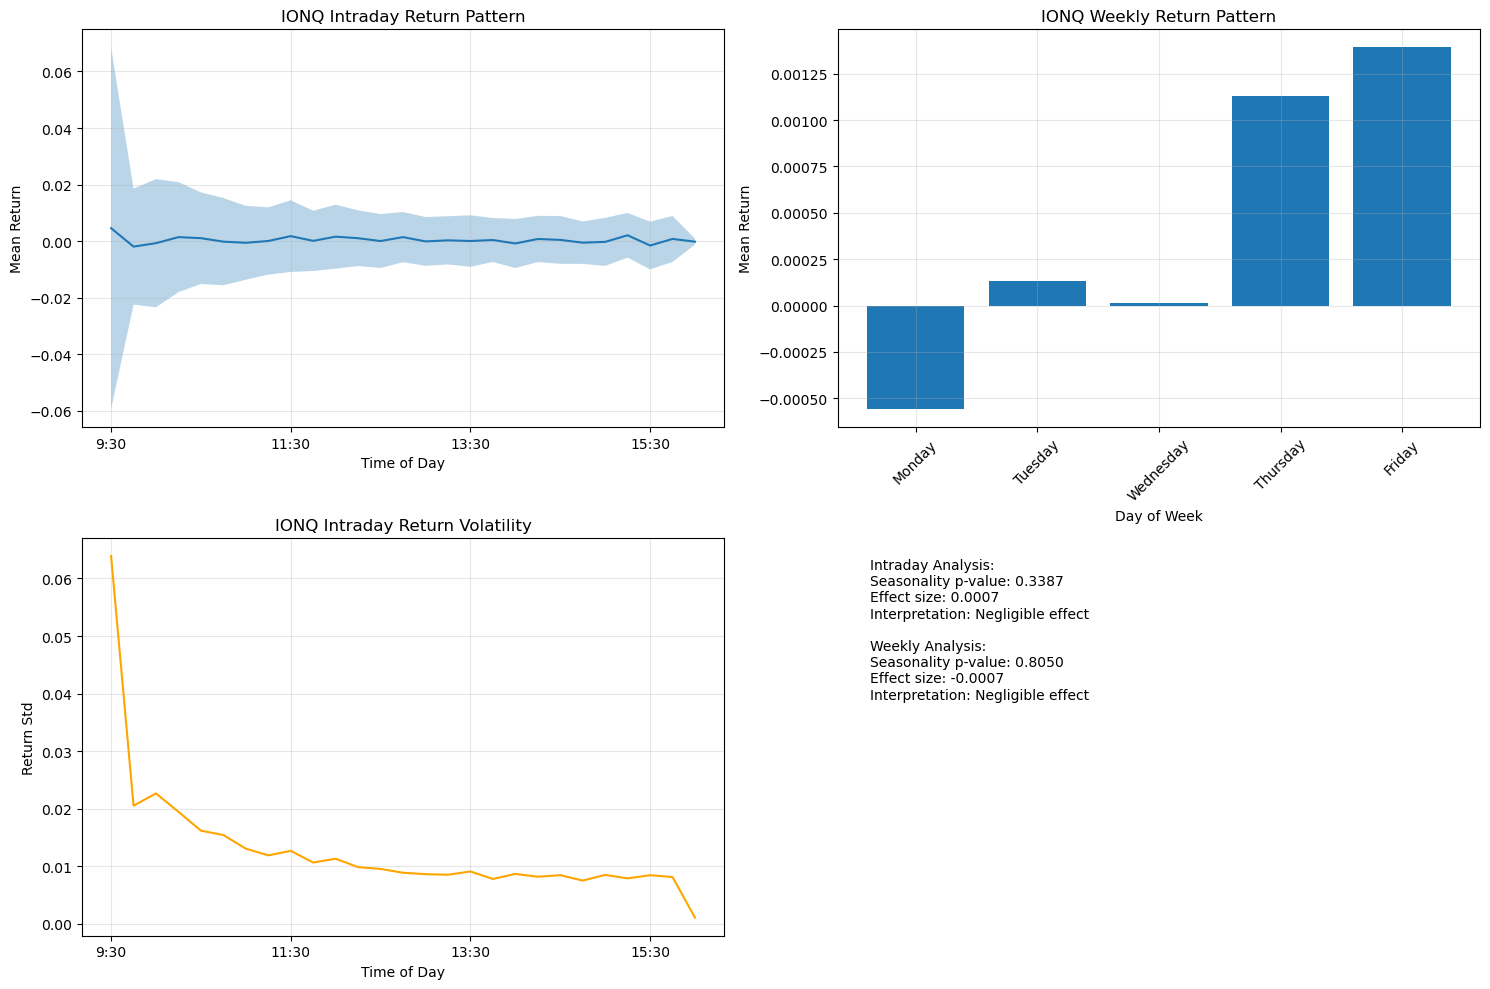

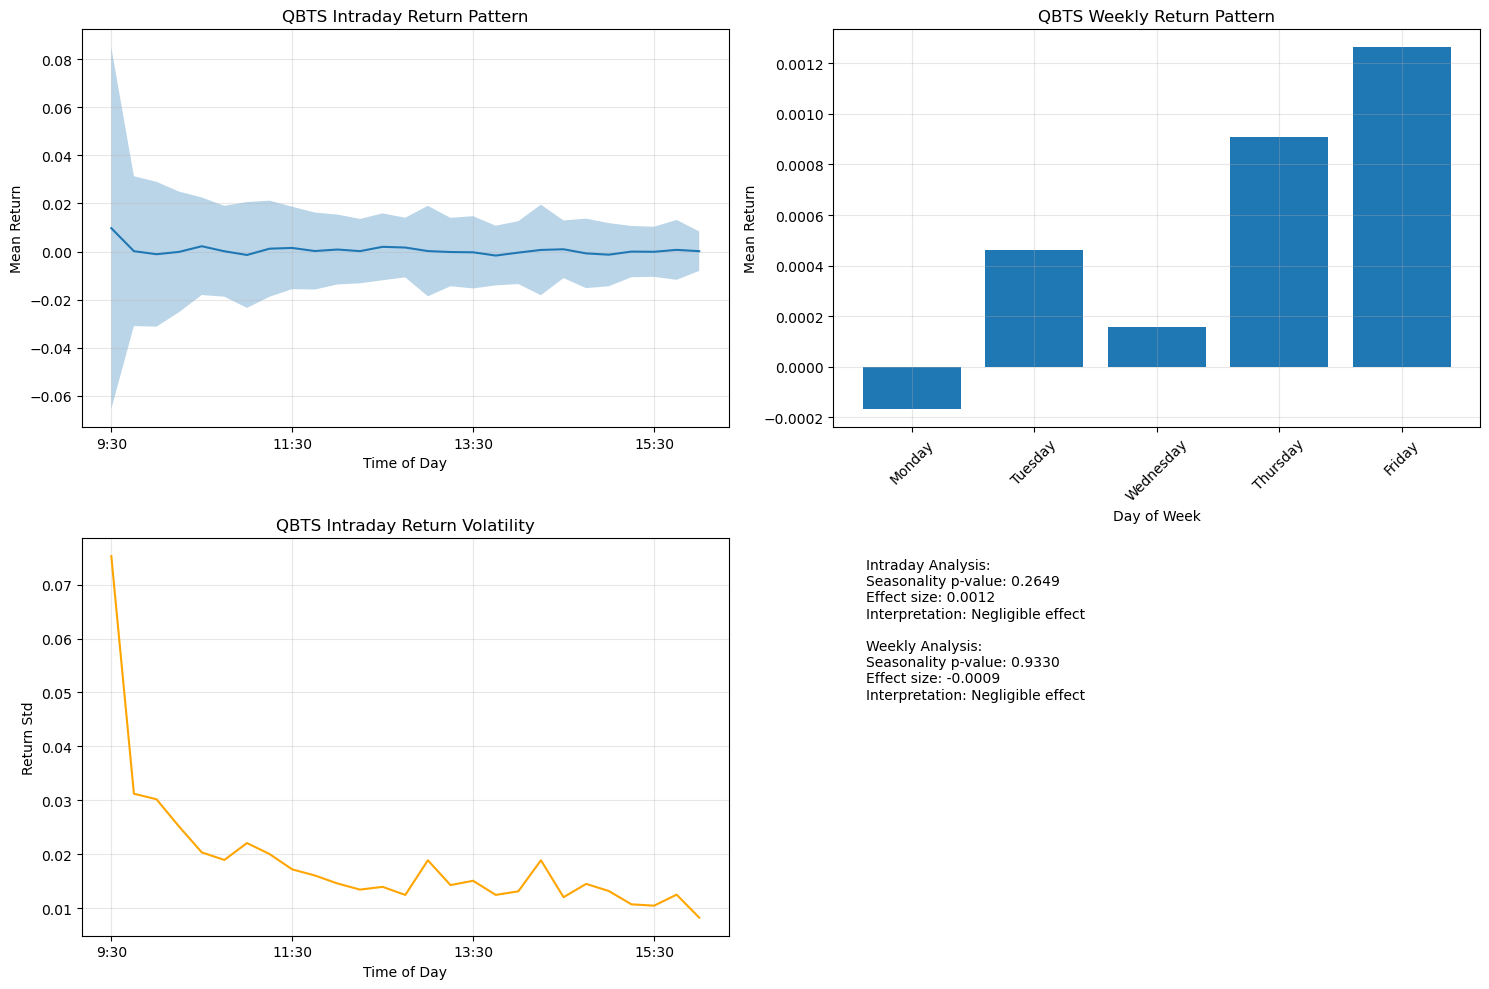

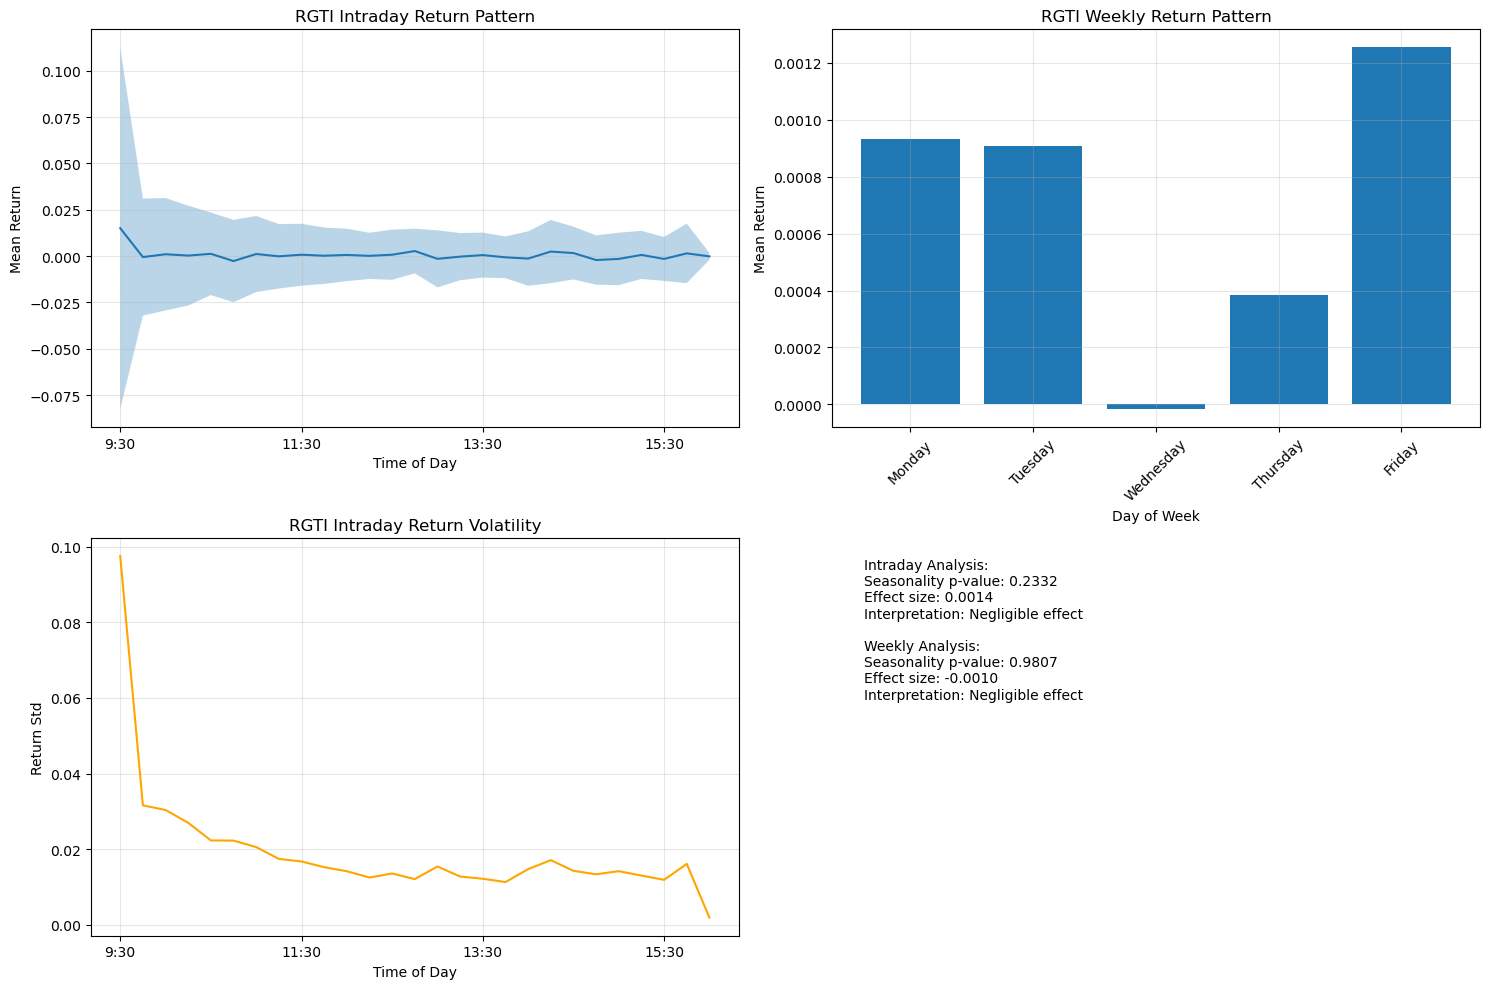

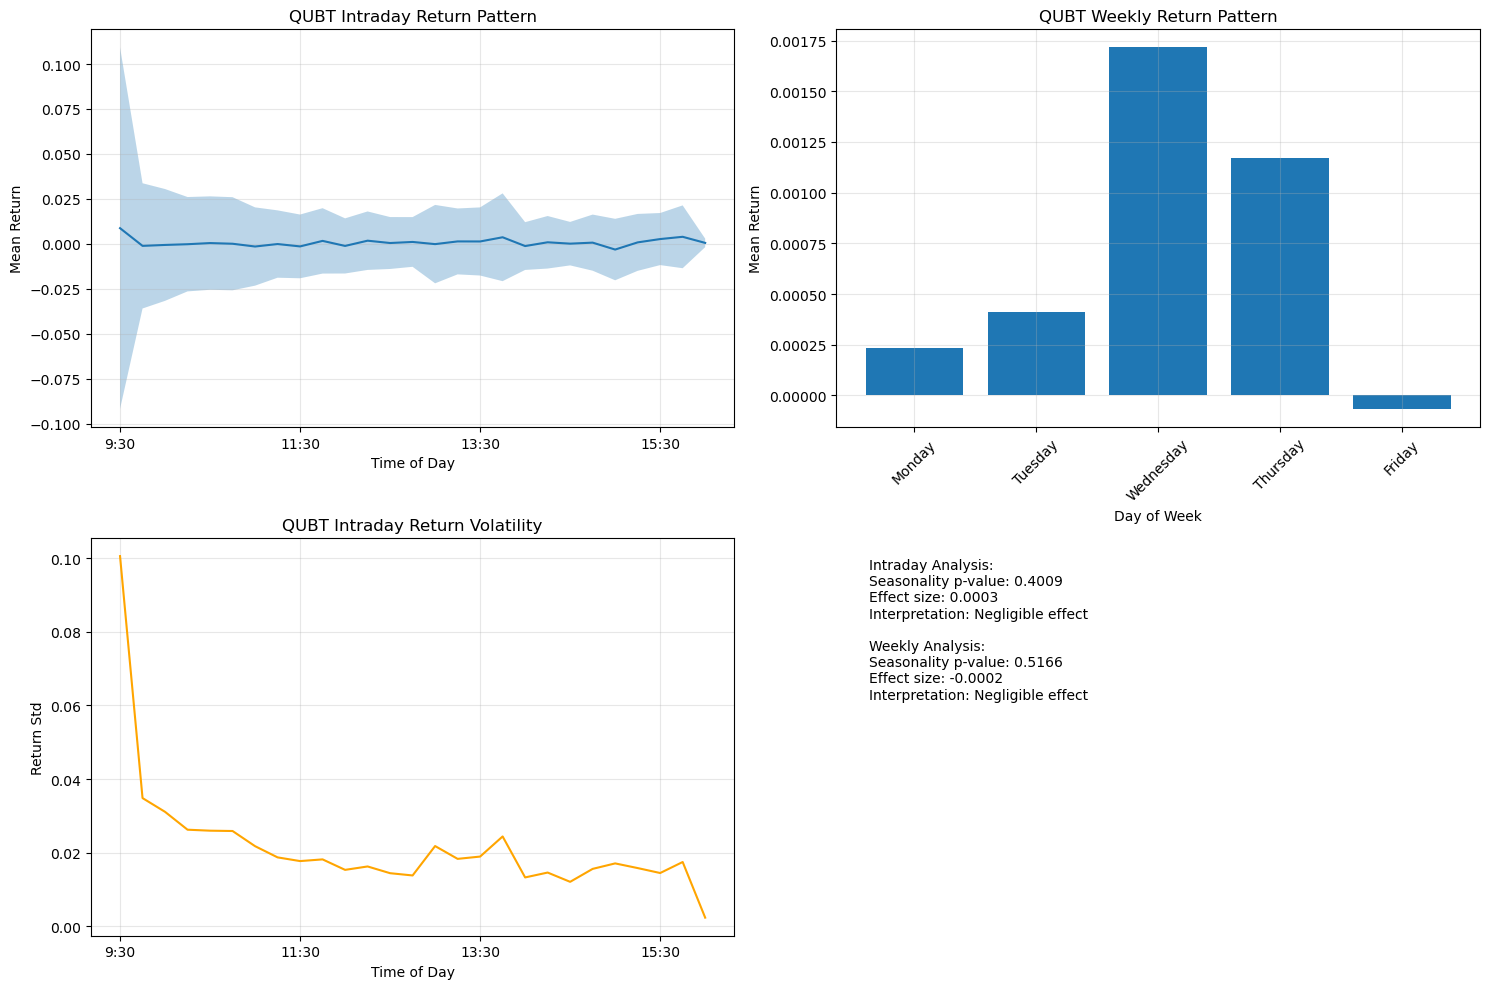

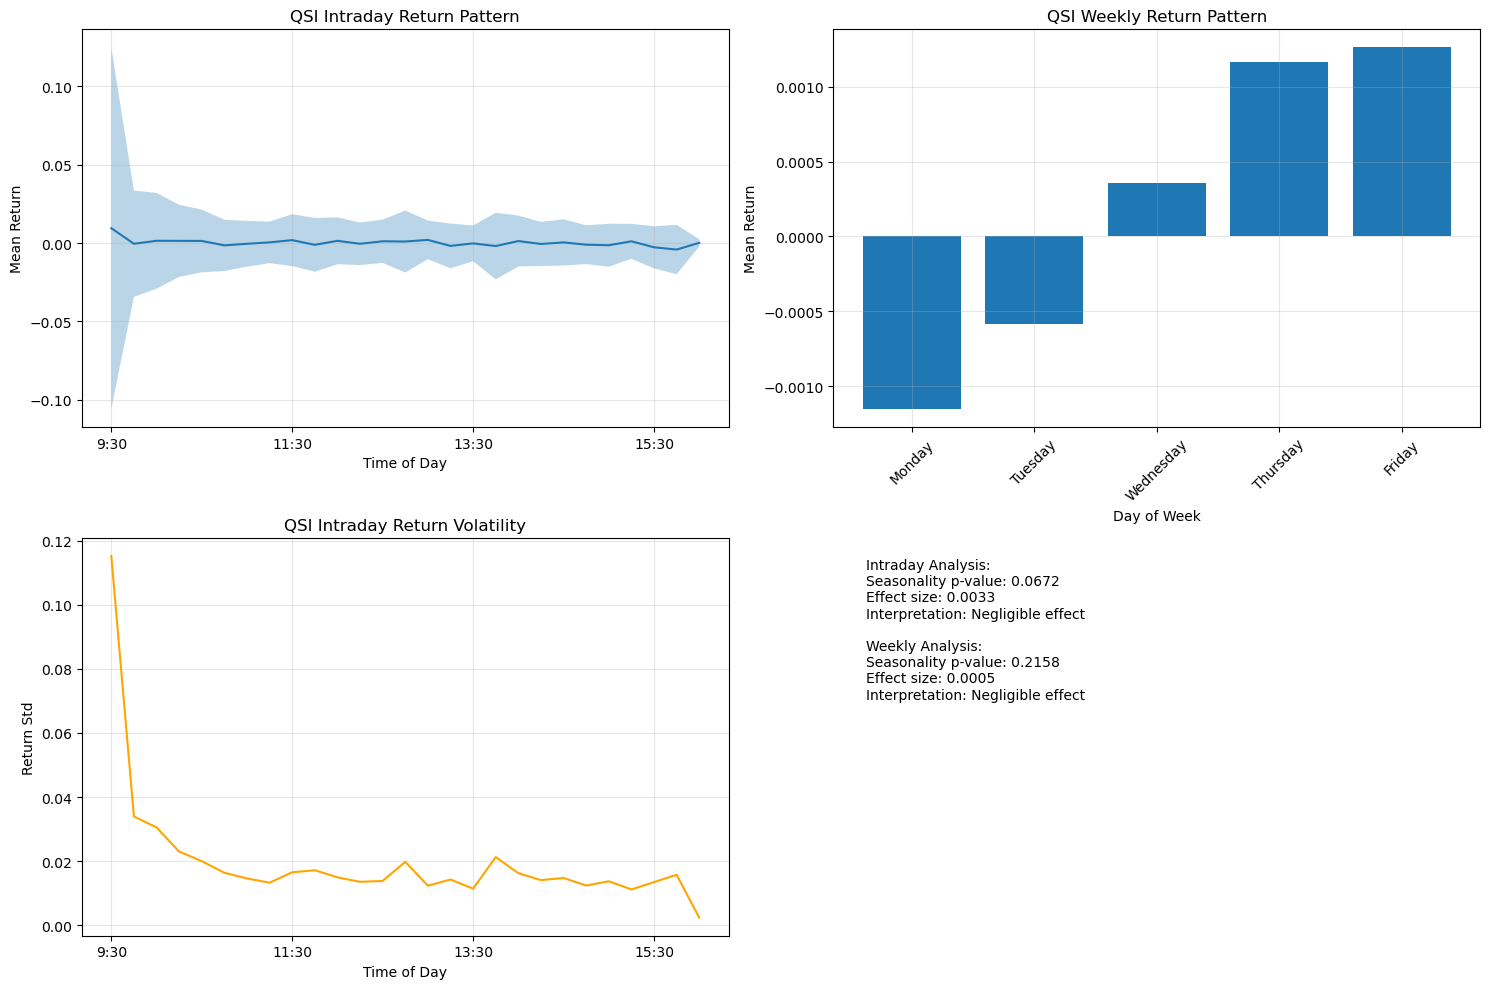

In [3]:
seasonality_results = p.analyze_seasonality(df)
interpretations = p.visualize_seasonality(seasonality_results)

## ARIMA

### For the ARIMA model, I looked at the ACF and PACF to determine the appropriate order of the model. Interestingly enough, while Kruskal-Wallis did not detect seasonality for any of the tickers, the ACF/PACF charts suggest that there might be slight seasonality given all of the returns had few number of consecutive significant lags, but significant lags at higher order. For example all show a significant lag at 11 except for QSI.

IONQ


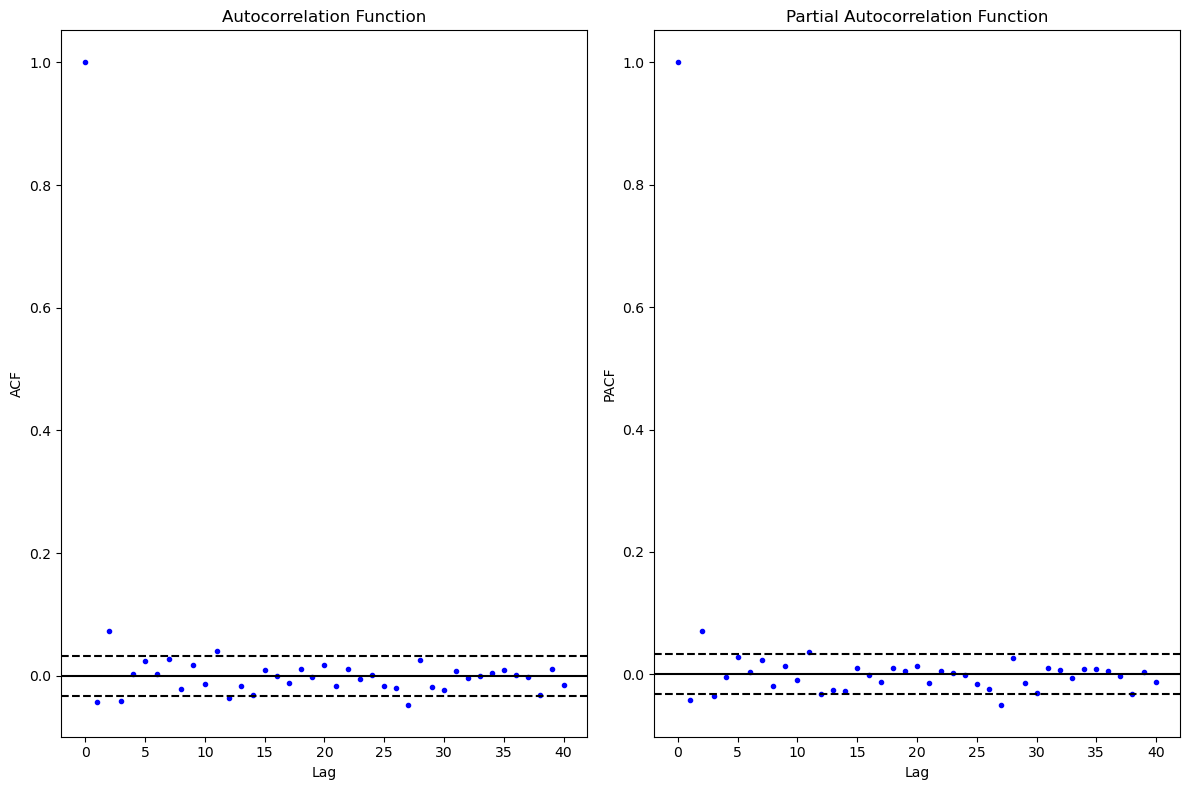


ARIMA Parameter Suggestions:
----------------------------------------
Significant ACF lags: [1, 2, 3, 11, 12, 27]
Significant PACF lags: [1, 2, 3, 11, 27]
Total significant ACF lags: 6
Total significant PACF lags: 5
Longest consecutive significant ACF lags: 3
Longest consecutive significant PACF lags: 3
ACF cutoff lag: 3
PACF cutoff lag: 3

Pattern suggests a mixed ARMA process.

Suggested ARIMA parameters:
ARIMA(p=3, d=0, q=3)

Isolated significant lags detected at: [11, 12, 27]

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
QBTS


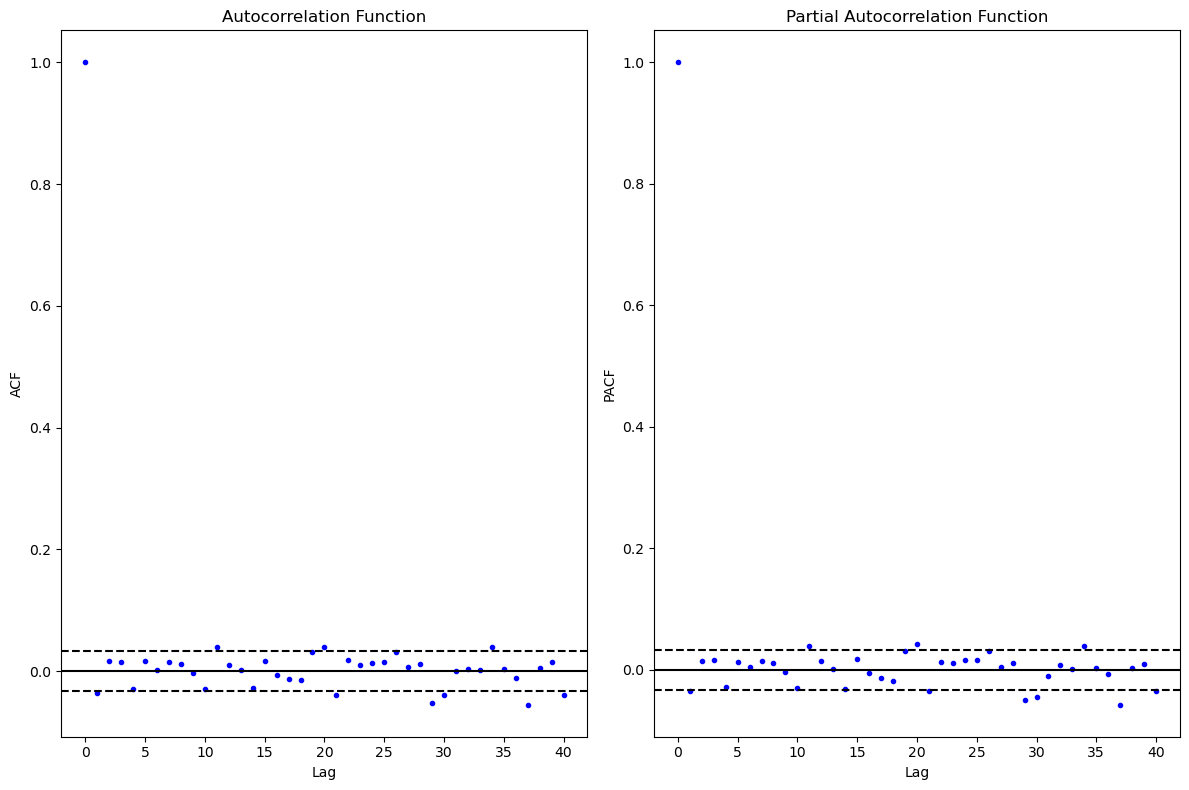


ARIMA Parameter Suggestions:
----------------------------------------
Significant ACF lags: [1, 11, 20, 21, 29, 30, 34, 37, 40]
Significant PACF lags: [1, 11, 20, 21, 29, 30, 34, 37, 40]
Total significant ACF lags: 9
Total significant PACF lags: 9
Longest consecutive significant ACF lags: 2
Longest consecutive significant PACF lags: 2
ACF cutoff lag: 1
PACF cutoff lag: 1

Pattern suggests a mixed ARMA process.

Suggested ARIMA parameters:
ARIMA(p=1, d=0, q=1)

Potential seasonal pattern detected with period 3
Consider a seasonal ARIMA model (SARIMA):
SARIMA(p=1, d=0, q=1)(P=1, D=0, Q=1, s=3)
Note: Verify this seasonal pattern makes sense for your data context

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
RGTI


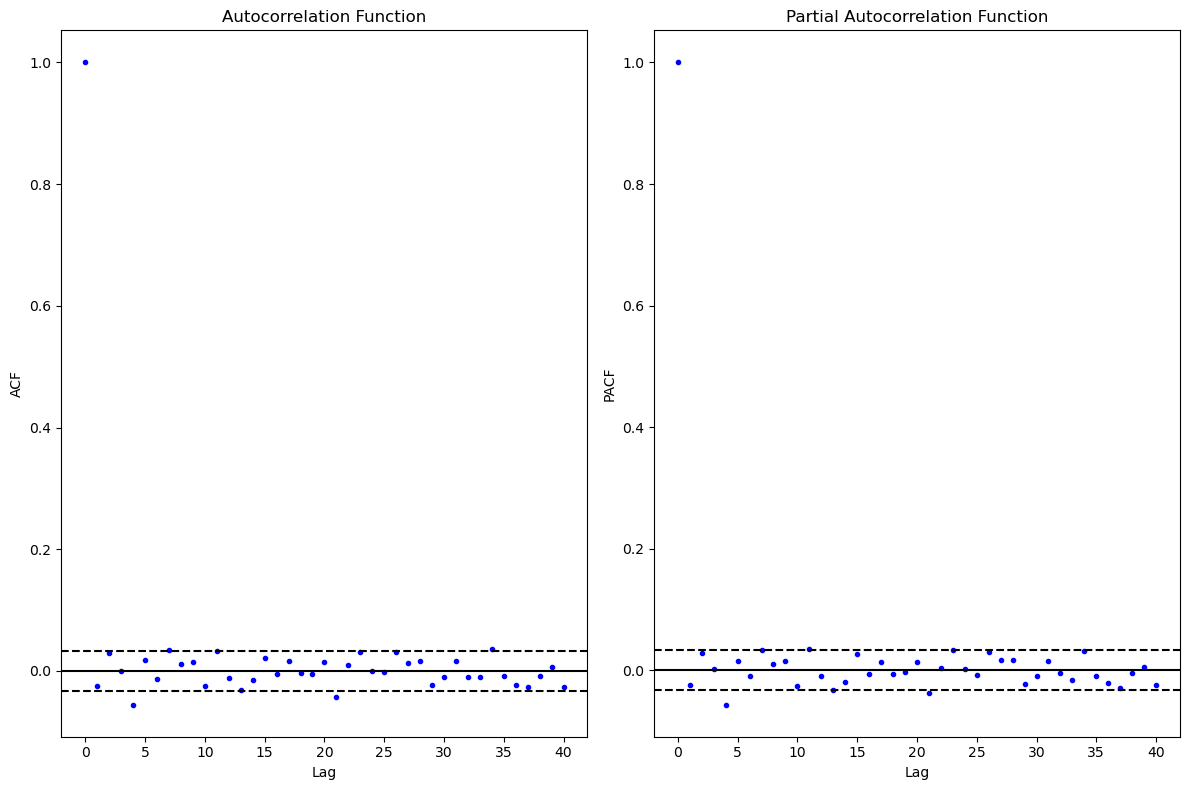


ARIMA Parameter Suggestions:
----------------------------------------
Significant ACF lags: [4, 7, 11, 21, 34]
Significant PACF lags: [4, 7, 11, 21, 23]
Total significant ACF lags: 5
Total significant PACF lags: 5
Longest consecutive significant ACF lags: 1
Longest consecutive significant PACF lags: 1
ACF cutoff lag: 4
PACF cutoff lag: 4

Pattern suggests a mixed ARMA process.

Suggested ARIMA parameters:
ARIMA(p=4, d=0, q=4)

Isolated significant lags detected at: [7, 11, 21, 34]

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
QUBT


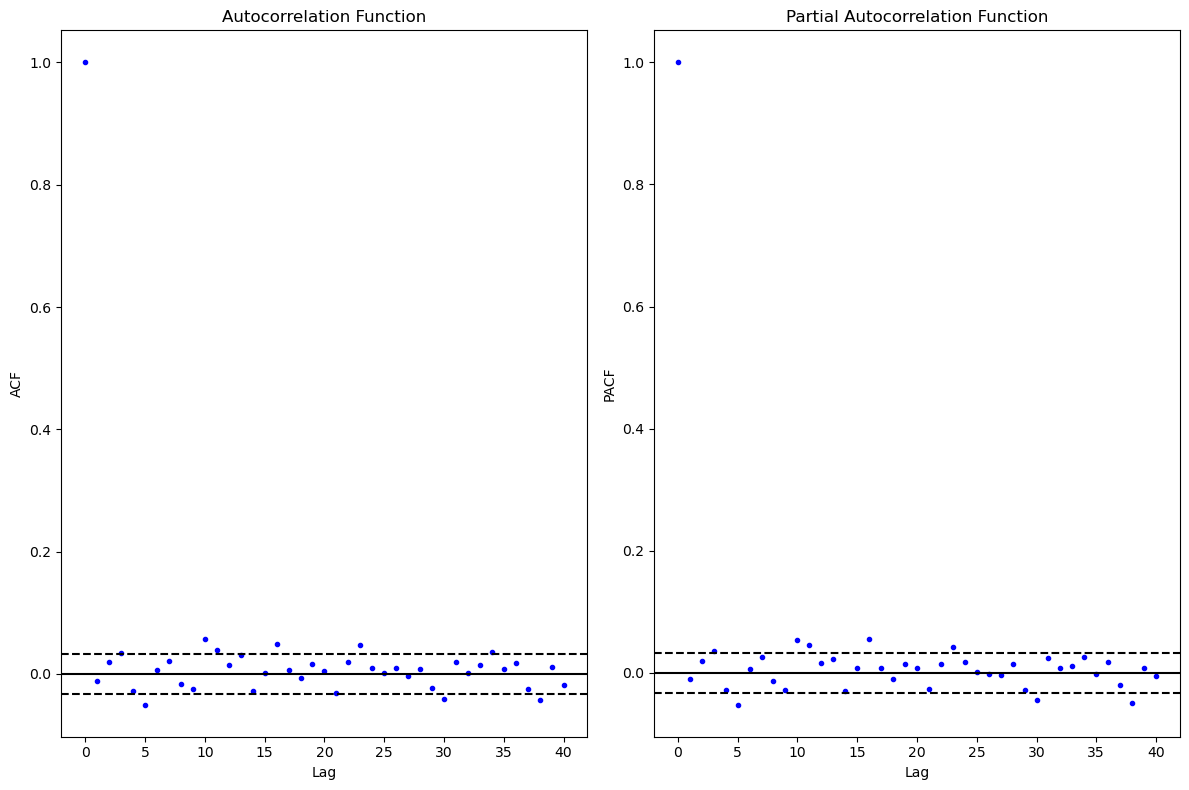


ARIMA Parameter Suggestions:
----------------------------------------
Significant ACF lags: [3, 5, 10, 11, 16, 23, 30, 34, 38]
Significant PACF lags: [3, 5, 10, 11, 16, 23, 30, 38]
Total significant ACF lags: 9
Total significant PACF lags: 8
Longest consecutive significant ACF lags: 2
Longest consecutive significant PACF lags: 2
ACF cutoff lag: 3
PACF cutoff lag: 3

Pattern suggests a mixed ARMA process.

Suggested ARIMA parameters:
ARIMA(p=3, d=0, q=3)

Potential seasonal pattern detected with period 5
Consider a seasonal ARIMA model (SARIMA):
SARIMA(p=3, d=0, q=3)(P=1, D=0, Q=1, s=5)
Note: Verify this seasonal pattern makes sense for your data context

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
QSI


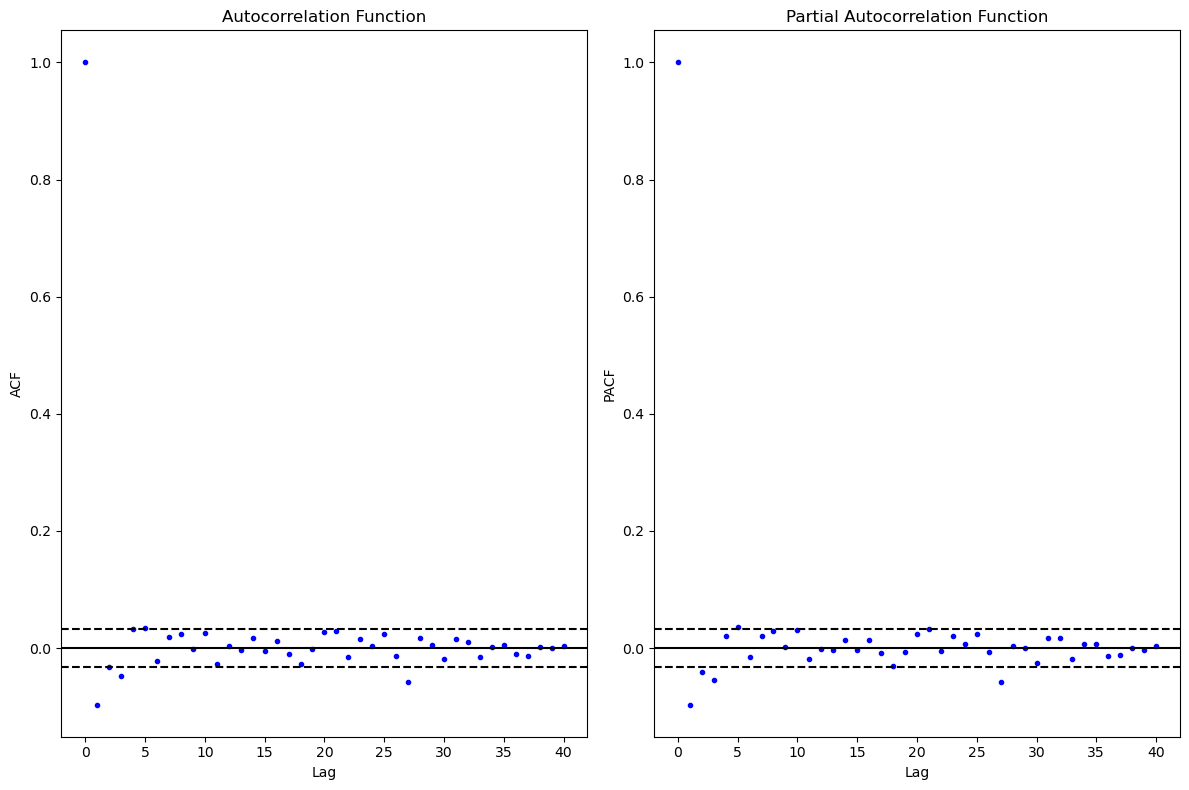


ARIMA Parameter Suggestions:
----------------------------------------
Significant ACF lags: [1, 3, 5, 27]
Significant PACF lags: [1, 2, 3, 5, 27]
Total significant ACF lags: 4
Total significant PACF lags: 5
Longest consecutive significant ACF lags: 1
Longest consecutive significant PACF lags: 3
ACF cutoff lag: 1
PACF cutoff lag: 3

Pattern suggests a mixed ARMA process.

Suggested ARIMA parameters:
ARIMA(p=3, d=0, q=1)

Isolated significant lags detected at: [3, 5, 27]

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


In [4]:
for ticker in p.quantum_tickers:
    print(ticker)
    p.analyze_acf_pacf(p.returns[ticker], lags=40)
    print('\n*' * 40)

### I began with an ARIMA(3,0,3) model, with walk-forward cross-validation for IONQ. I went with the decision of predicting the next 27 steps instead of predicting 1 step ahead. 

#### The `create_arima_predictor` method takes a set of returns, splits them into 30 day training period and 1 day test periods, trains the model, predicts on the test period. If `cross_validation=True`, then it will perform walk forward cross validation one day at a time, depending on how many splits are specified.

In [5]:
arima_results = p.create_arima_predictor(returns=p.returns['IONQ'],
                                         order=(3, 0, 3),
                                         training_days=30,
                                         step_size=27,
                                         n_splits=10,
                                         cross_validation=True)


Running ARIMA in walk-forward cross-validation mode
Using direct multi-step forecasting (forecasting entire day at once)

Starting cross-validation with debug info:
--------------------------------------------------
Total data points: 3536
Full data range: 2024-08-07 09:45:00 to 2025-02-18 16:00:00
Available trading days: 131
Training window: 30 calendar days
Step size: 27 periods (1 trading day)

Split 1:
Training period: 2024-08-07 to 2024-09-06
Training data points: 566
Training days: 21
Test day: 2024-09-09
Test range: 2024-09-09 09:30:00 to 2024-09-09 16:00:00
Forecast generated successfully - RMSE: 0.005932
Forecast generated successfully - MAE: 0.004027

Split 2:
Training period: 2024-08-08 to 2024-09-07
Training data points: 567
Training days: 21
Test day 2024-09-09 already used, moving window forward

Split 2:
Training period: 2024-08-09 to 2024-09-08
Training data points: 540
Training days: 20
Test day 2024-09-09 already used, moving window forward

Split 2:
Training period:

### The ARIMA(3,0,3) model performs quite poorly, with a harmonic mean RMSE of 0.00638, and a MAE of 0.00463 across the 10 CV splits. This is pretty large error, especially since return curves are compounded each period. As you can see, the cumulative return curves don't look great either when compared to the actuals.

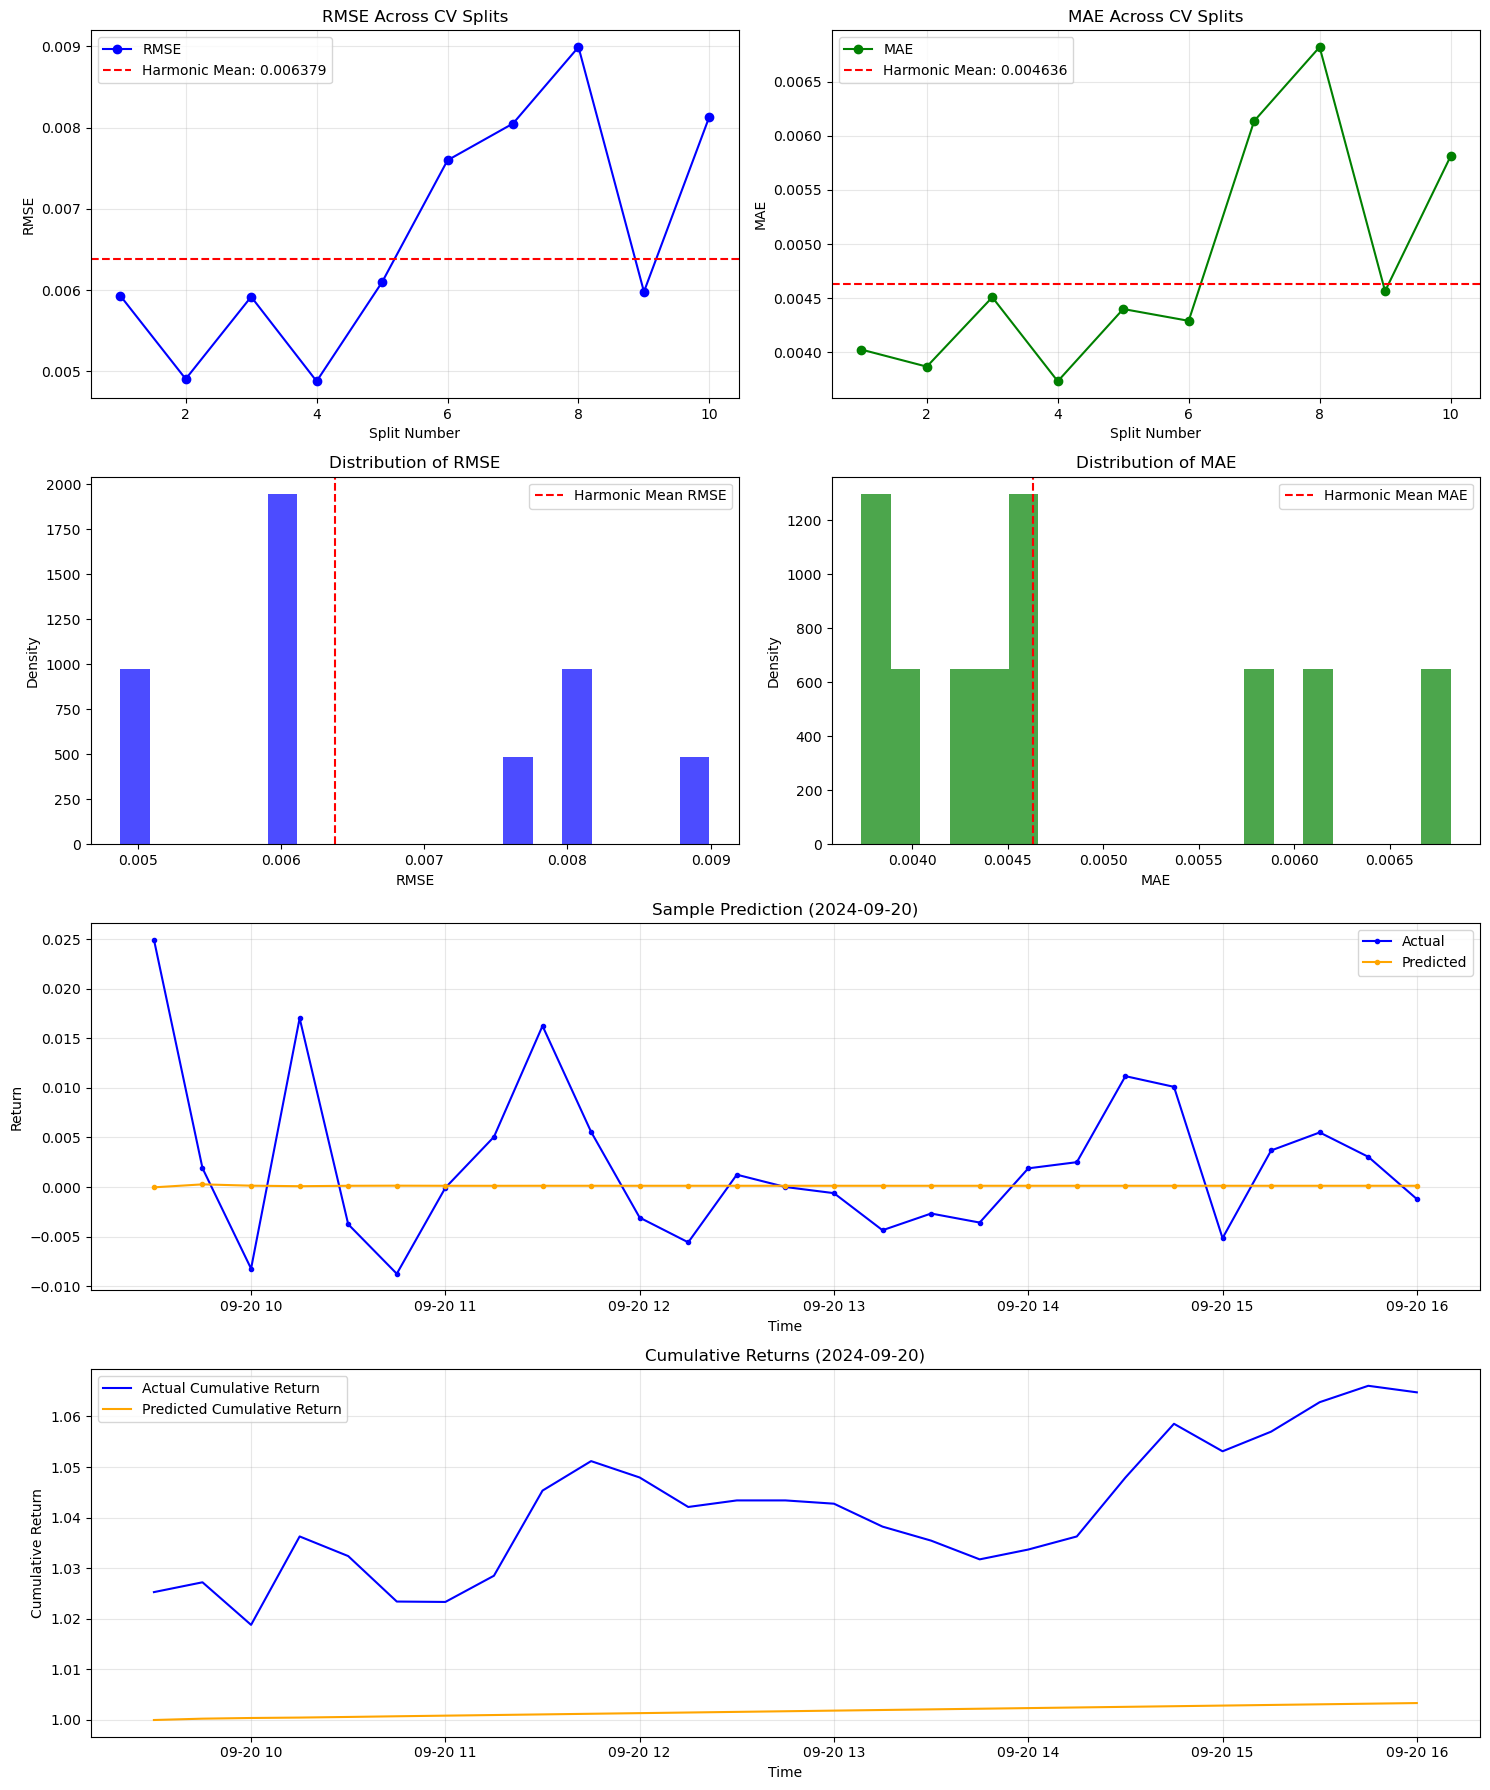

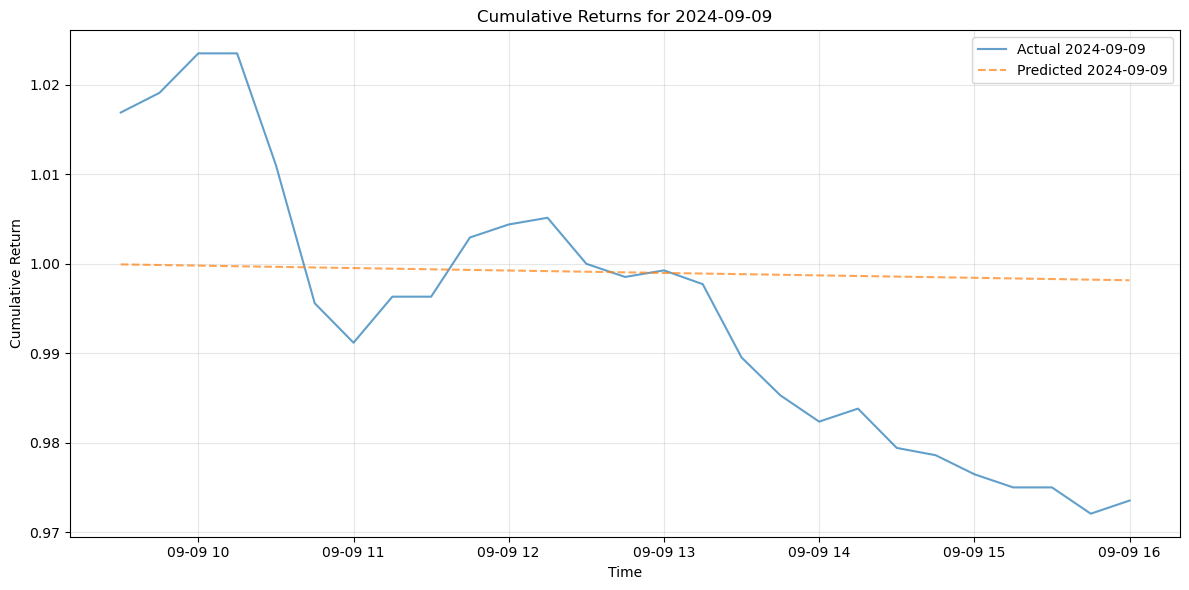

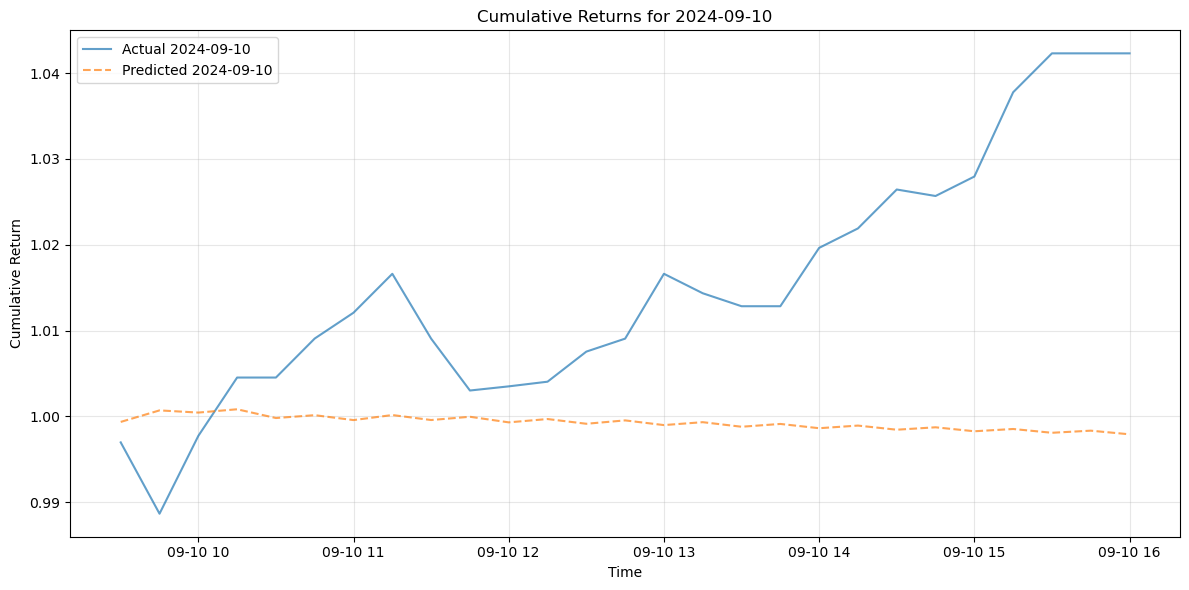

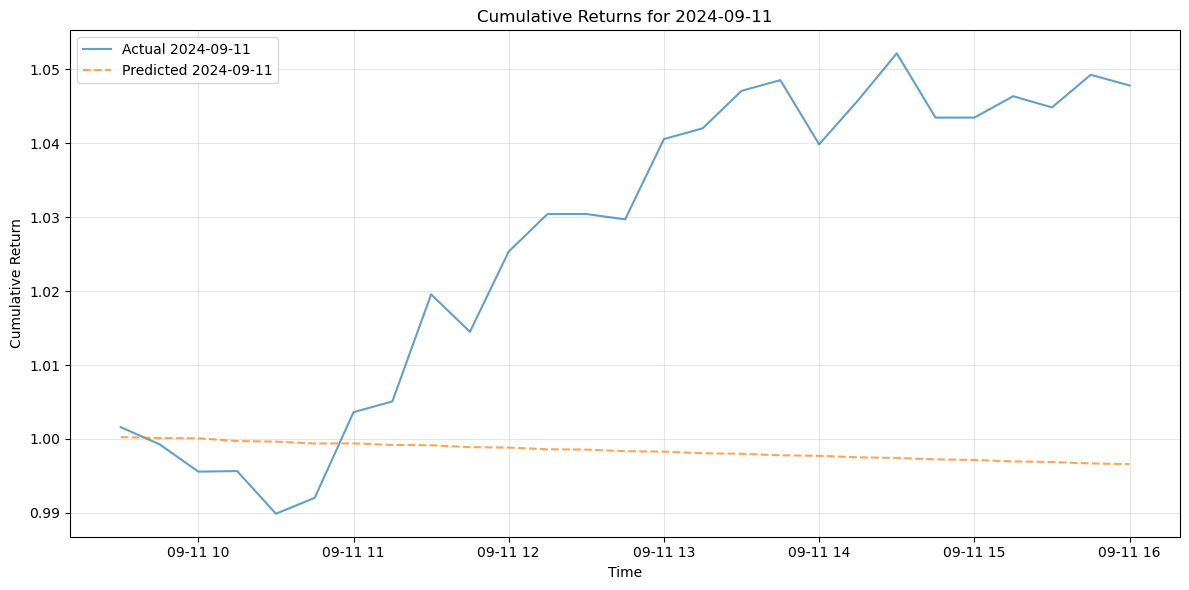

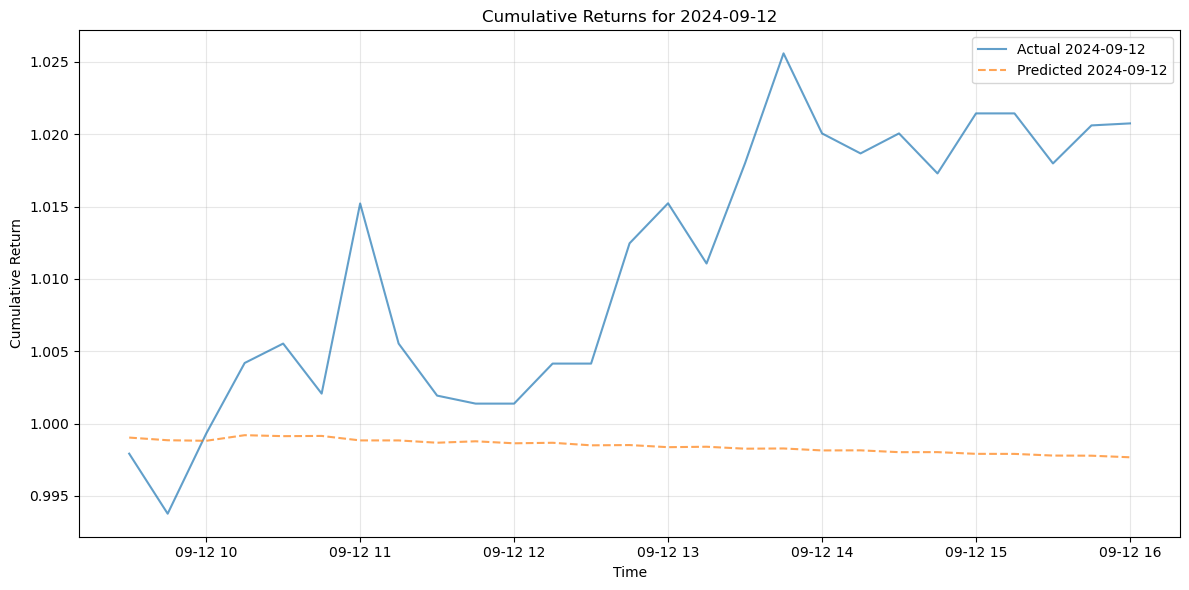

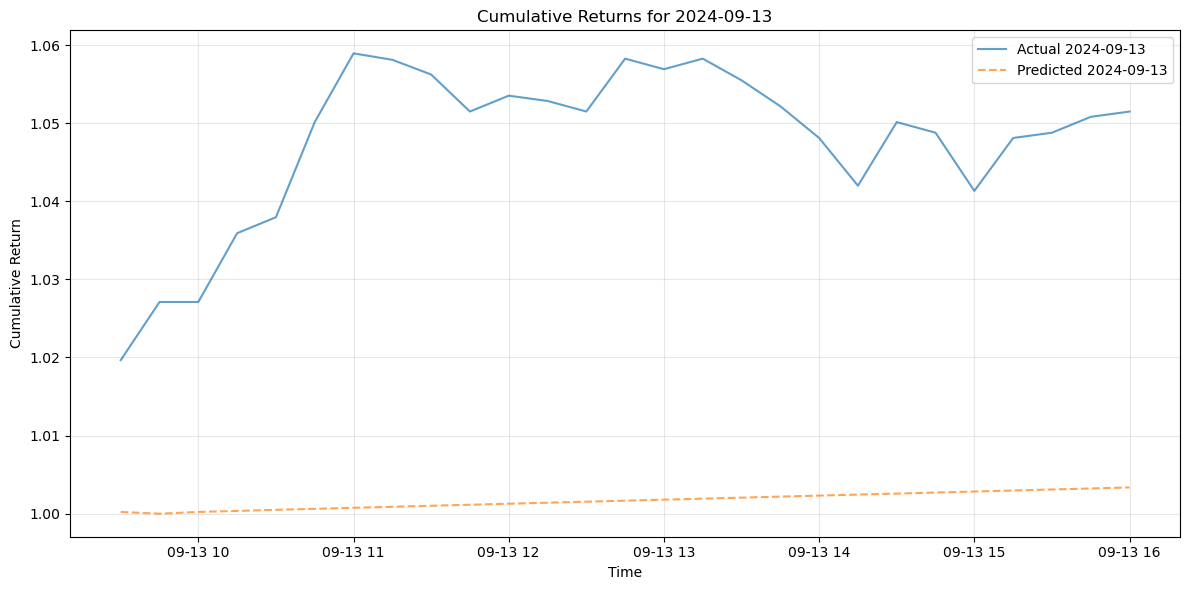

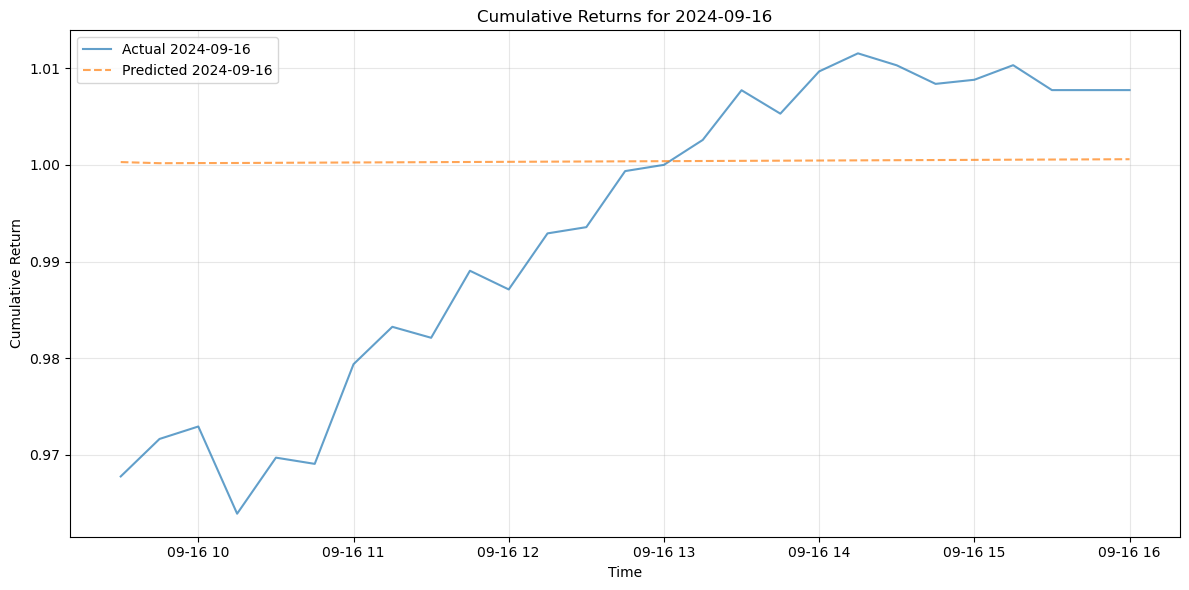

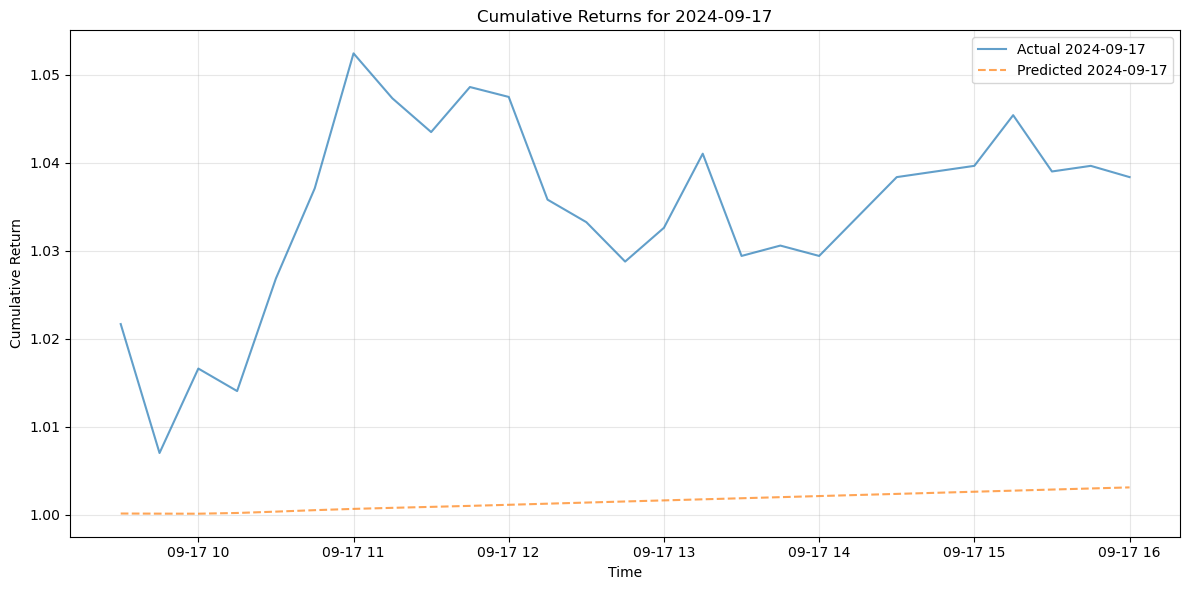

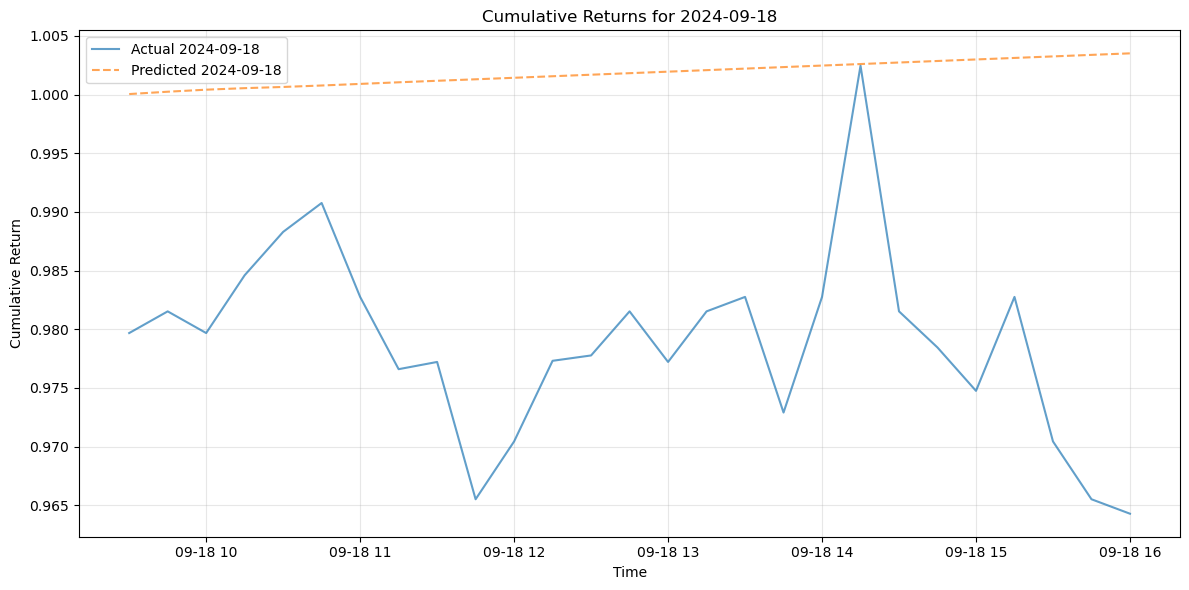

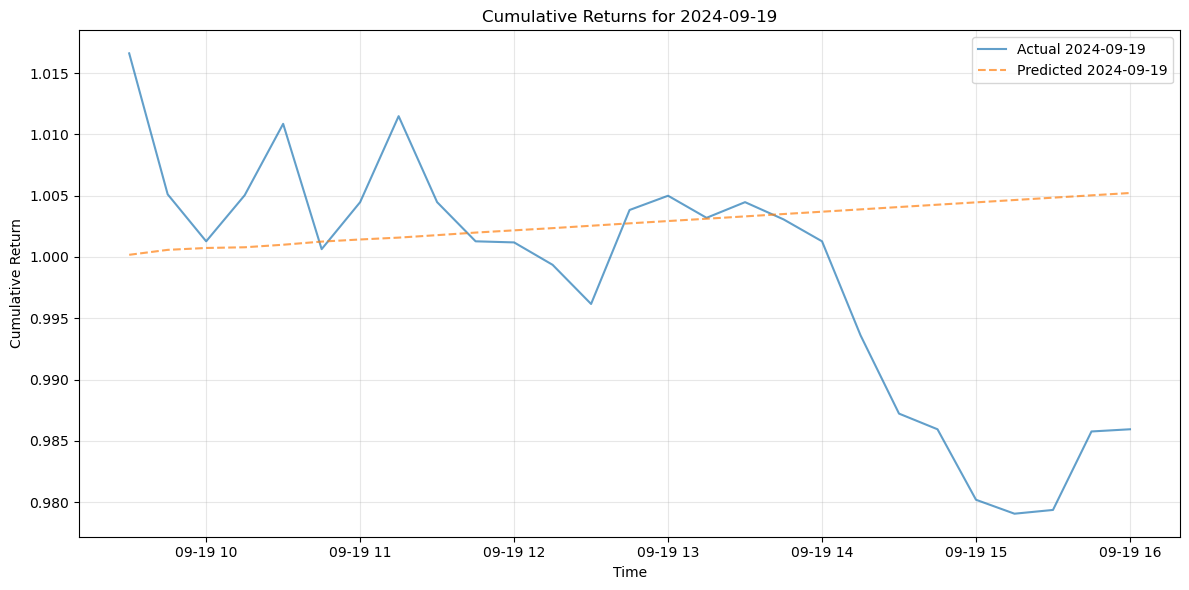

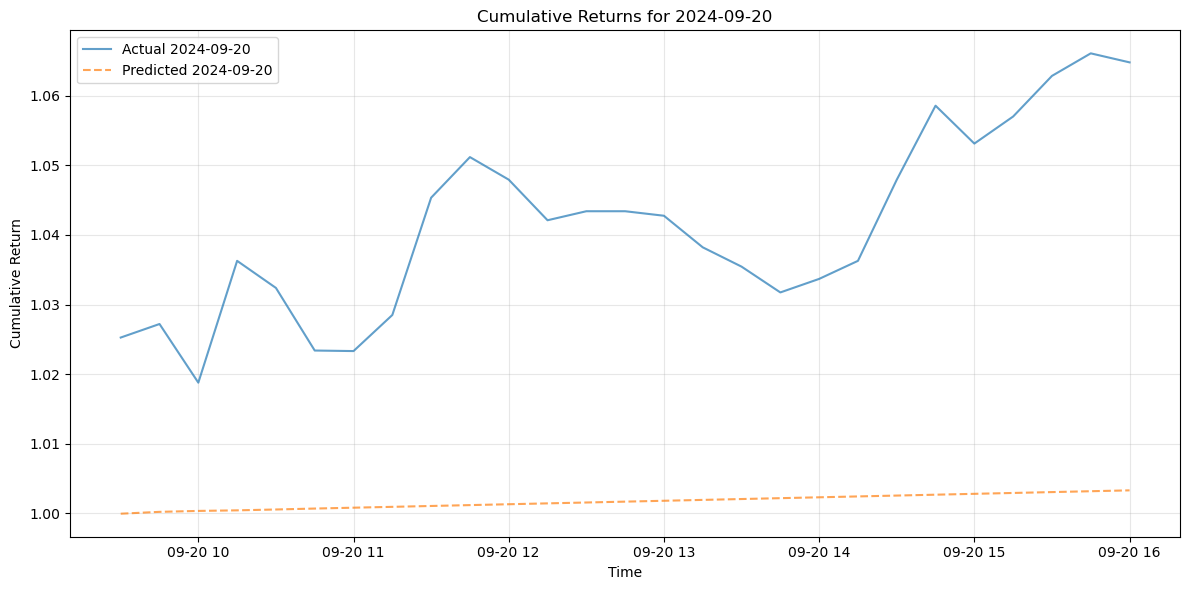

In [6]:
p.plot_cv_results(arima_results)
p.plot_all_cumulative_returns(arima_results)

### Playing with the orders of ARIMA did not drastically improve performance by any means, as shown here by a (5,0,5) model.

In [7]:
arima_results = p.create_arima_predictor(returns=p.returns['IONQ'],
                                         order=(5, 0, 5),
                                         training_days=30,
                                         step_size=27,
                                         n_splits=10,
                                         cross_validation=True)


Running ARIMA in walk-forward cross-validation mode
Using direct multi-step forecasting (forecasting entire day at once)

Starting cross-validation with debug info:
--------------------------------------------------
Total data points: 3536
Full data range: 2024-08-07 09:45:00 to 2025-02-18 16:00:00
Available trading days: 131
Training window: 30 calendar days
Step size: 27 periods (1 trading day)

Split 1:
Training period: 2024-08-07 to 2024-09-06
Training data points: 566
Training days: 21
Test day: 2024-09-09
Test range: 2024-09-09 09:30:00 to 2024-09-09 16:00:00
Forecast generated successfully - RMSE: 0.005938
Forecast generated successfully - MAE: 0.004059

Split 2:
Training period: 2024-08-08 to 2024-09-07
Training data points: 567
Training days: 21
Test day 2024-09-09 already used, moving window forward

Split 2:
Training period: 2024-08-09 to 2024-09-08
Training data points: 540
Training days: 20
Test day 2024-09-09 already used, moving window forward

Split 2:
Training period:

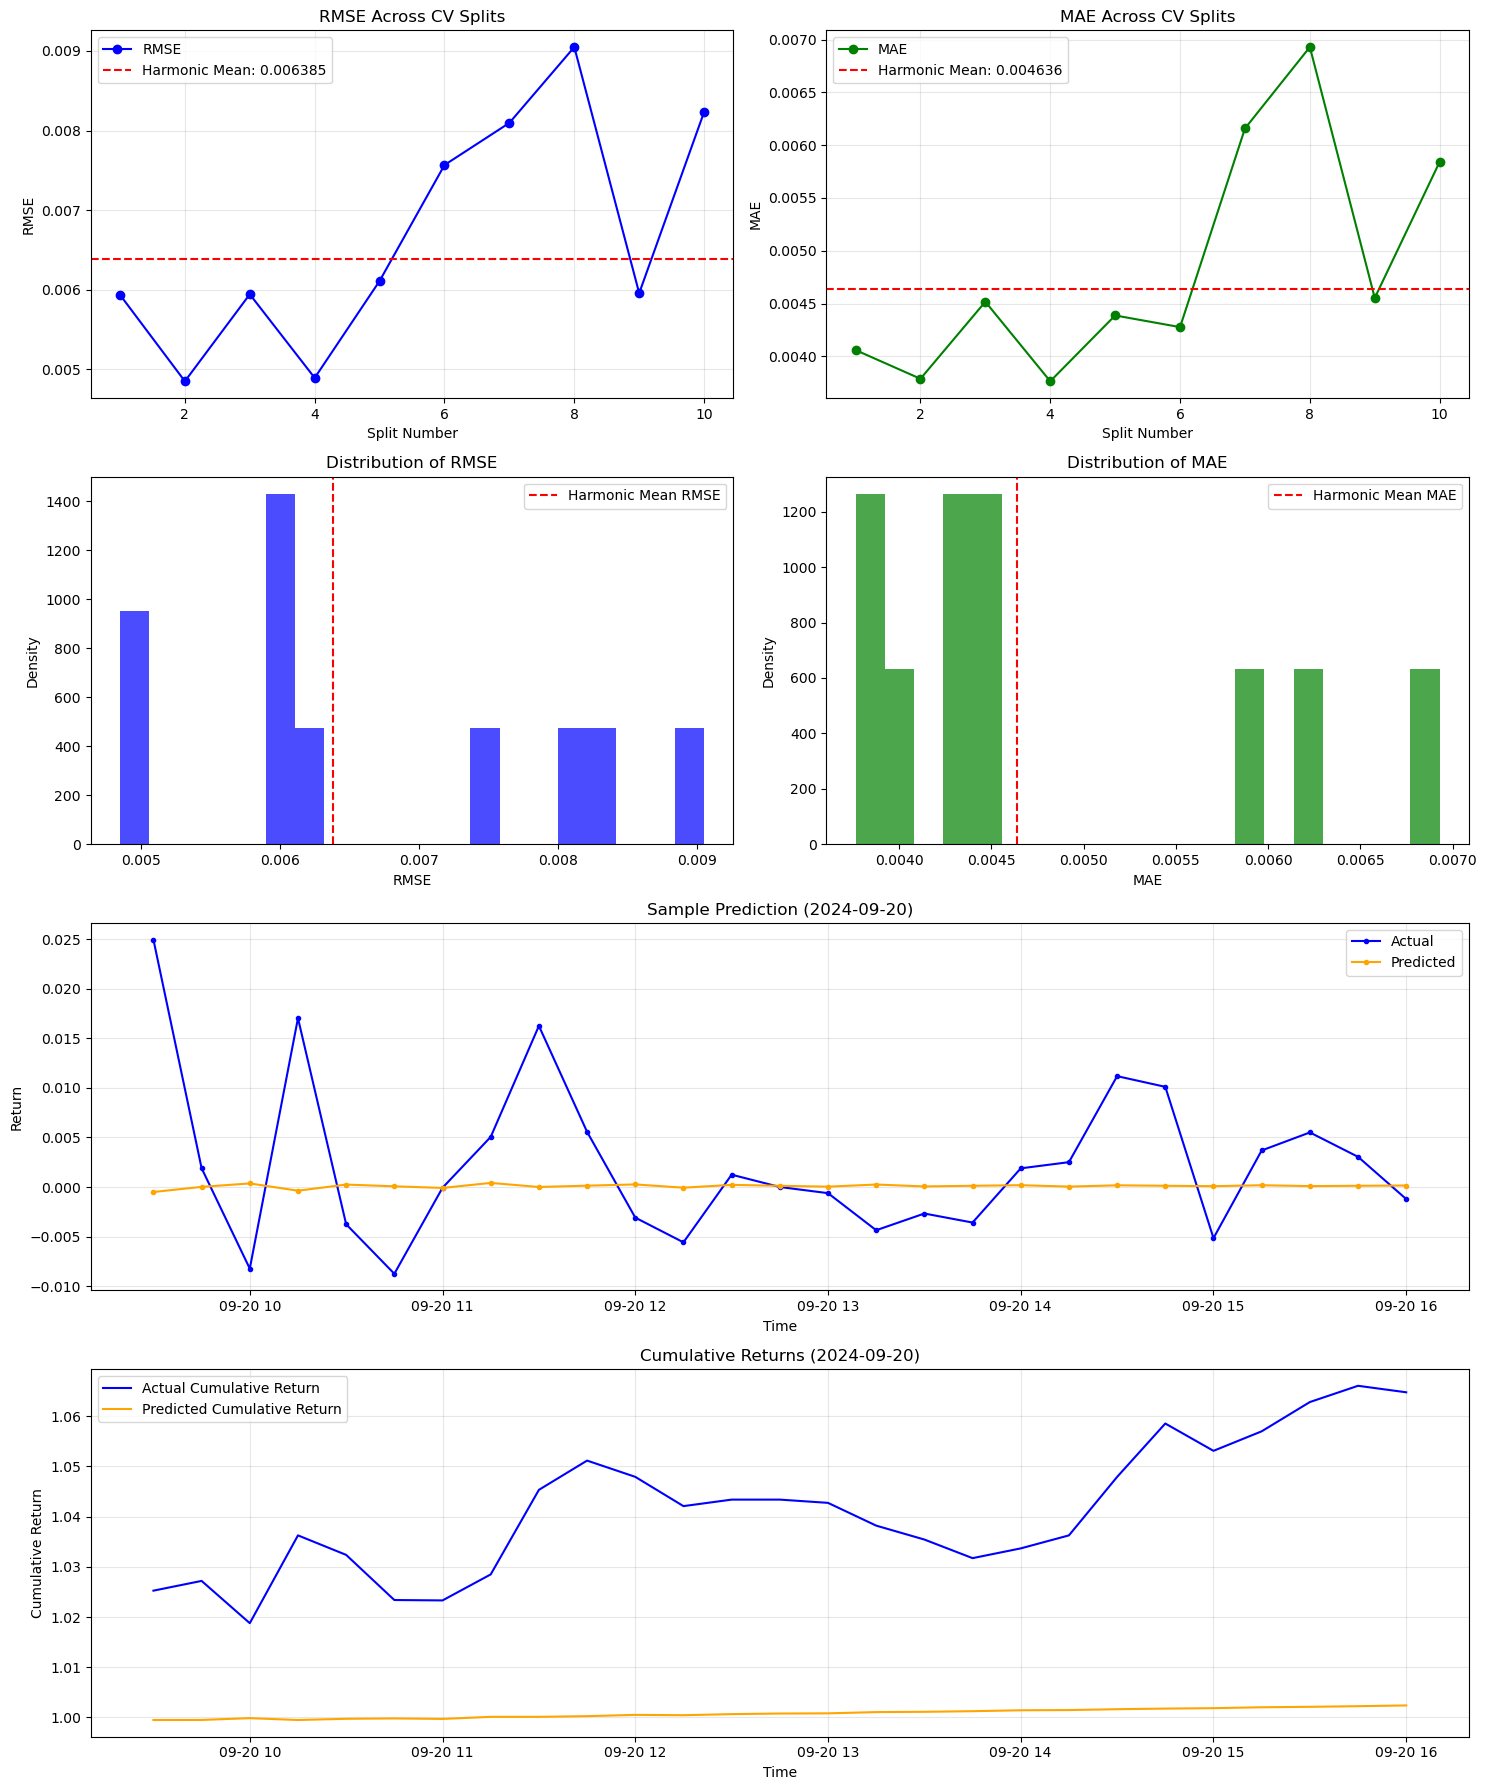

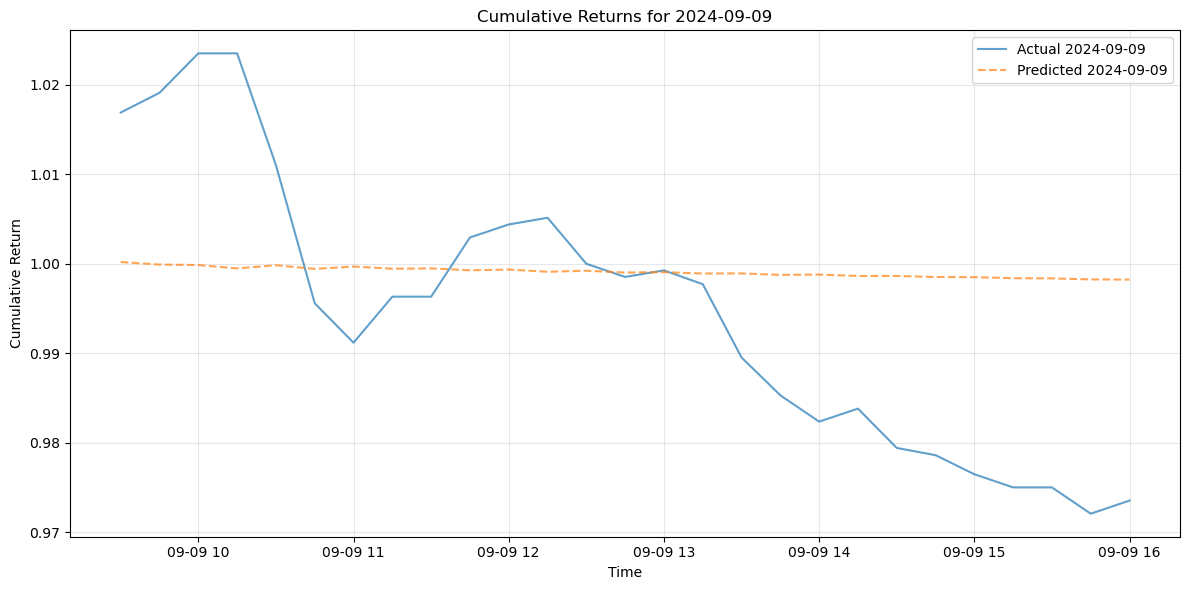

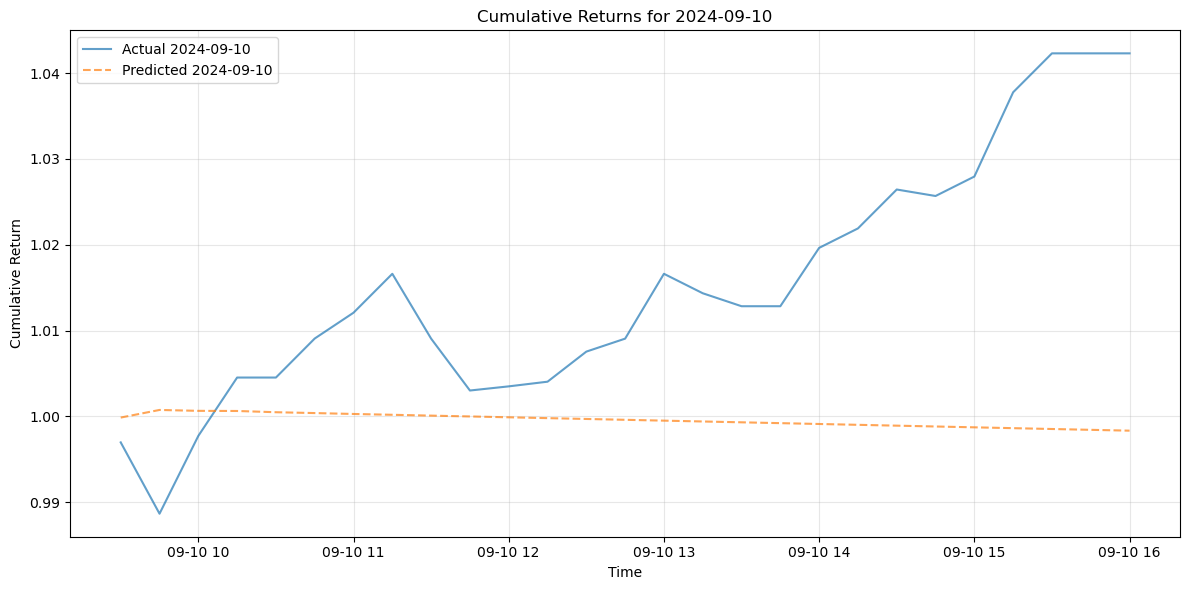

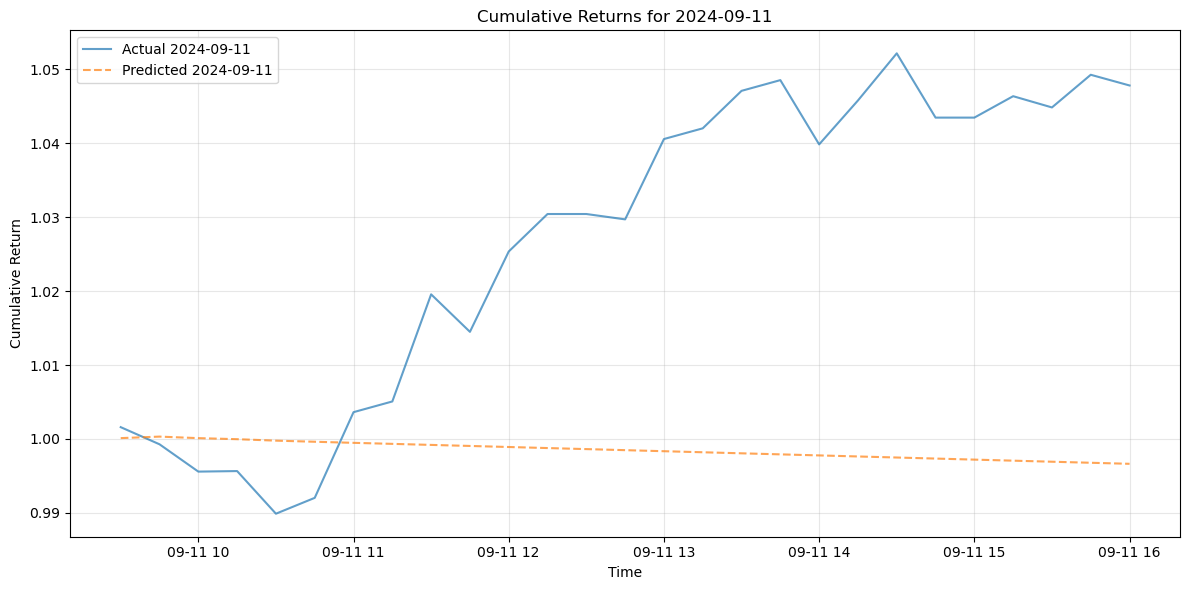

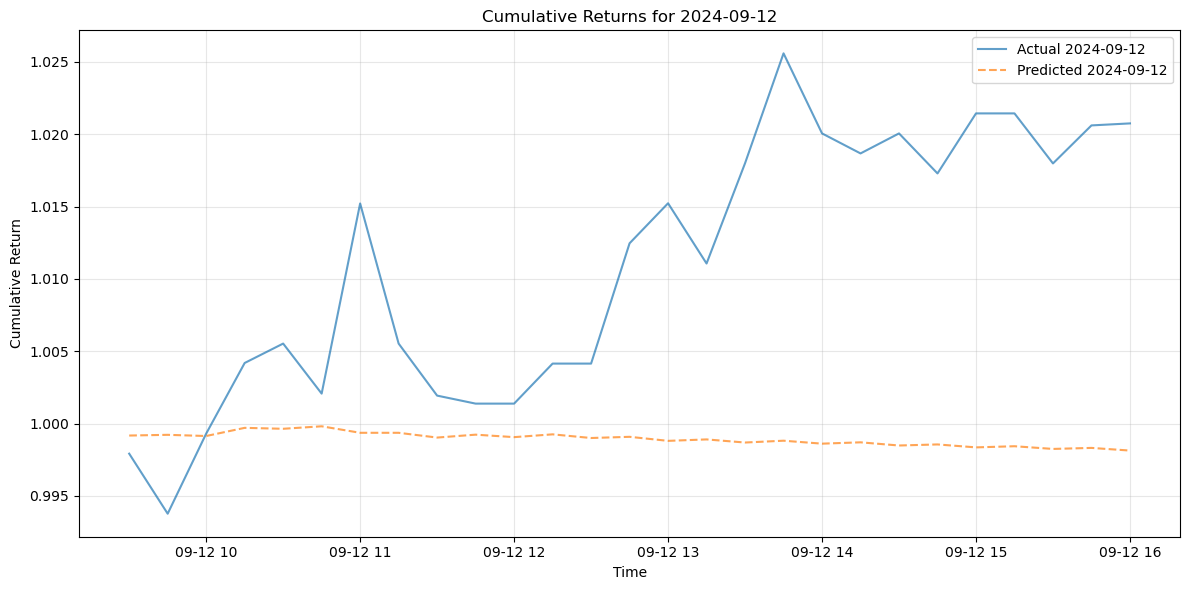

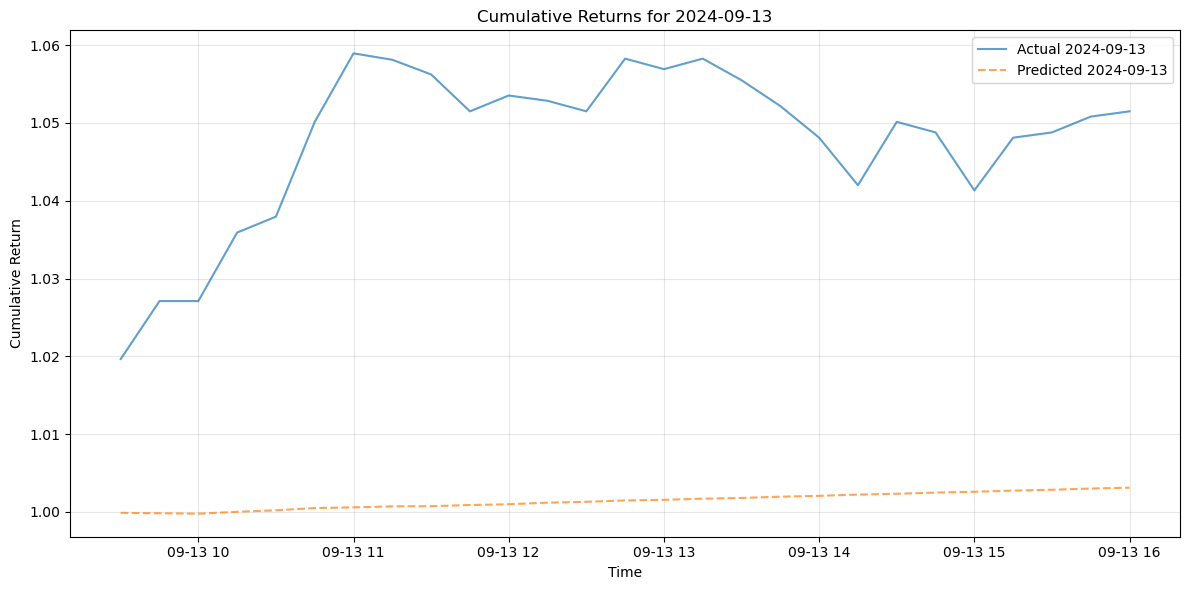

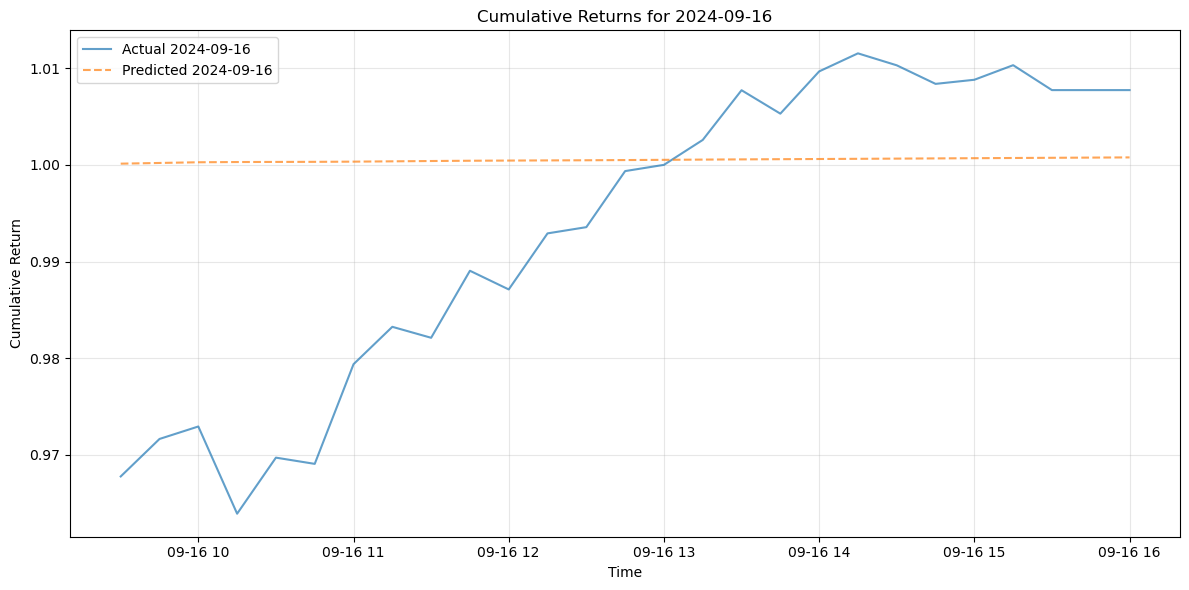

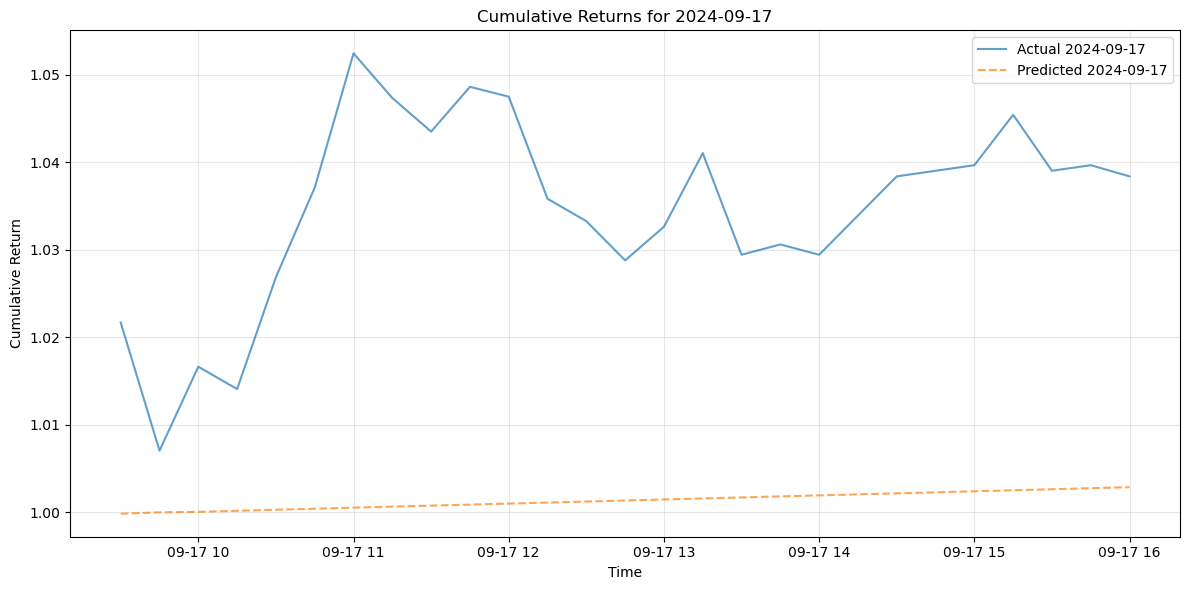

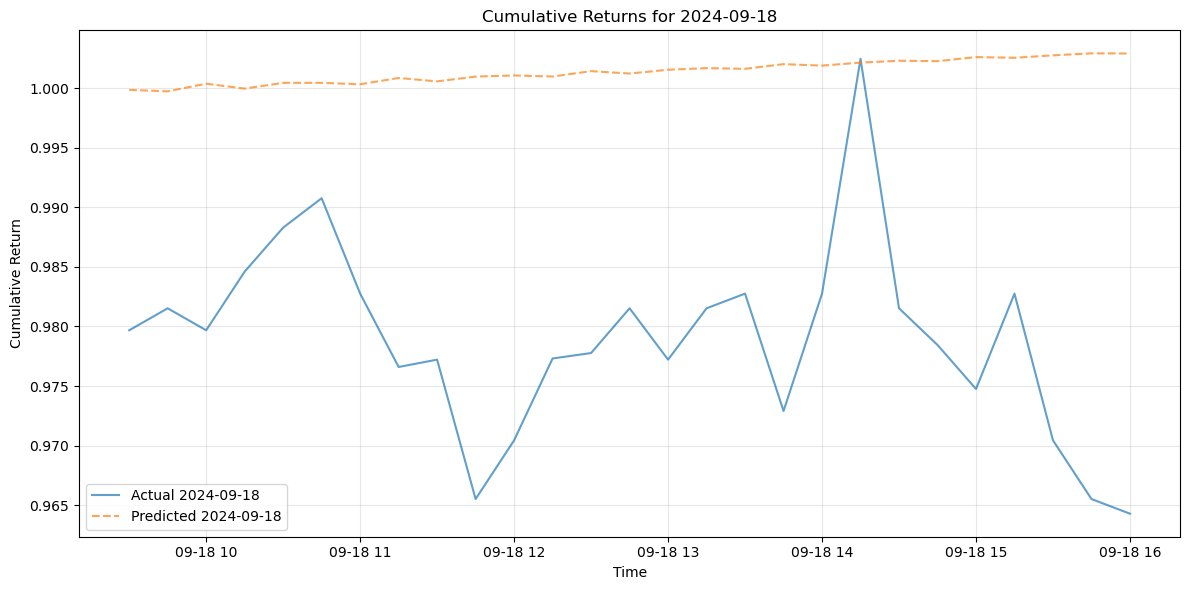

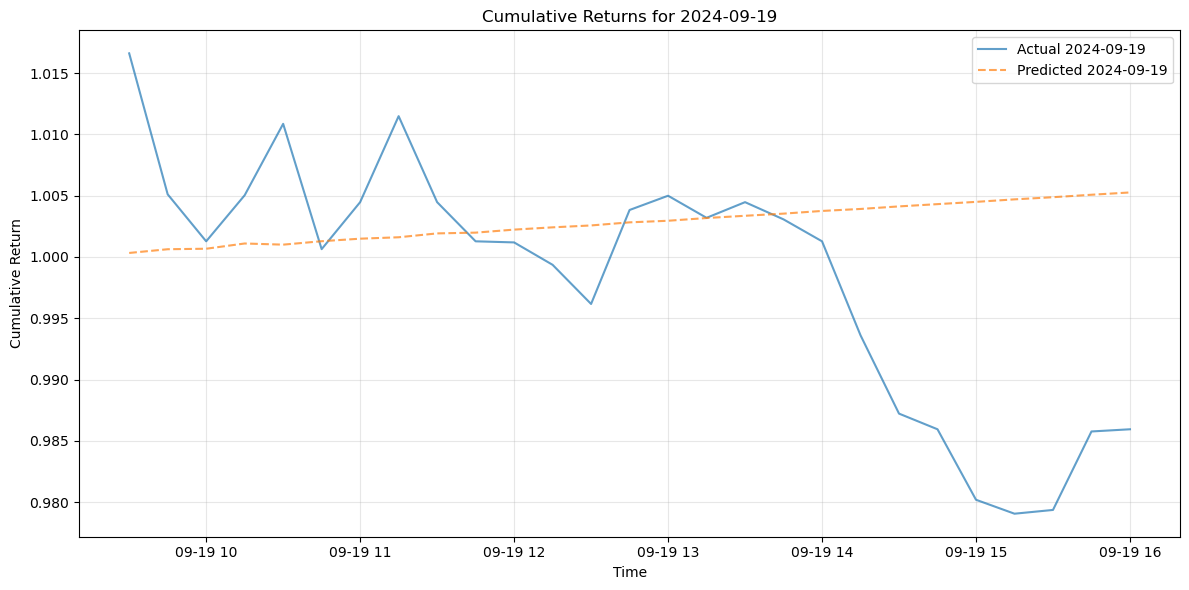

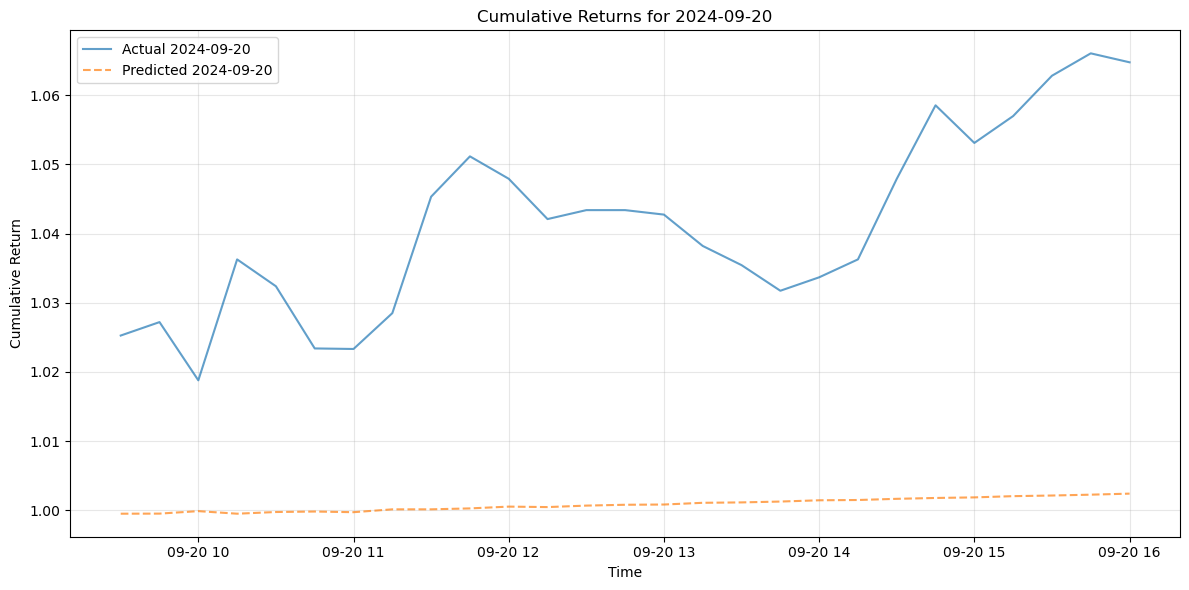

In [8]:
p.plot_cv_results(arima_results)
p.plot_all_cumulative_returns(arima_results)

## Vector Autoregression

### Next, we move on to a VAR model with engineered features. 

#### The `create_var_predictor` method splits the data into 30 day training periods and 1 day test periods. Features are then augmented and selected based on top `n_features` by mutual information. They are then scaled over the period. `reduce_multicollinearity` is called and set with a VIF tolerance of 3.0 in order to reduce any further muilticollinearity present amongst the features. If `use_pca`=True, then the features are not filtered out, and instead we use the number of PCA components up to a specified `pca_variance`. Other correlated returns are also included by using `n_corr_stocks`. If `cross_validation`=True, then walk forward cross validation will be performed. For this implementation of VAR, I decided to let the model automatically choose the lag order based on AIC.

### On feature engineering, the below features were created, some with a rolling window:
##### Basic: intraperiod returns, mean price, price gap 
##### Technical Analysis: momentum, moving average, exponential moving averages, linear slope
##### Volume: volume moving average, volatility of volume, relative volume, volume momentum, price-volume, volume-weighted return
##### Cross Ticker: rolling correlations, relative strength

### Given that we don't have many datapoints to train on and that this became high dimensional very quickly due to the number of features, I decided to use `n_features=10` while keeping all of the correlated stocks in for the first run.

In [9]:
var_results = p.create_var_predictor(raw_df=df, 
                                     target_ticker='IONQ', 
                                     training_days=30,
                                     forward_periods=27, 
                                     n_features=10, 
                                     n_corr_stocks=4,
                                     n_splits=10,
                                     cross_validation=True,
                                     use_pca=False,
                                    )


Data Preparation and Feature Selection for VAR Model:
------------------------------------------------------------
Input data range: 2024-08-07 to 2025-02-18

Running in walk-forward cross-validation mode with raw features

Starting VAR Model Walk-Forward Validation:
------------------------------------------------------------

Calculating feature importance to be used across all splits...

Selected top features based on mutual information (used for all splits):
1. ('QUBT', 'day_vol_pct') (MI: 0.2137)
2. ('RGTI', 'day_vol_pct') (MI: 0.1828)
3. ('IONQ', 'day_vol_pct') (MI: 0.1406)
4. ('RGTI', 'vol_4') (MI: 0.1203)
5. ('QSI', 'day_vol_pct') (MI: 0.1200)
6. ('NQ1', 'volume') (MI: 0.1197)
7. ('QBTS', 'day_vol_pct') (MI: 0.1125)
8. ('QBTS', 'rel_vol_5') (MI: 0.1053)
9. ('IONQ', 'vol_13') (MI: 0.0970)
10. ('IONQ', 'IONQ_QSI_rel_vol_4') (MI: 0.0962)

Correlated Quantum Stocks (used for all splits):
- QBTS (correlation: 0.571)
- RGTI (correlation: 0.553)
- QUBT (correlation: 0.444)
- QSI (cor

### Surprisingly, the VAR model performs much worse than ARIMA(3,0,3), with a harmonic mean RMSE of 0.055 and MAE of 0.02898. You can see that the cumulative return curves look even worse than the ARIMA(3,0,3) curves.

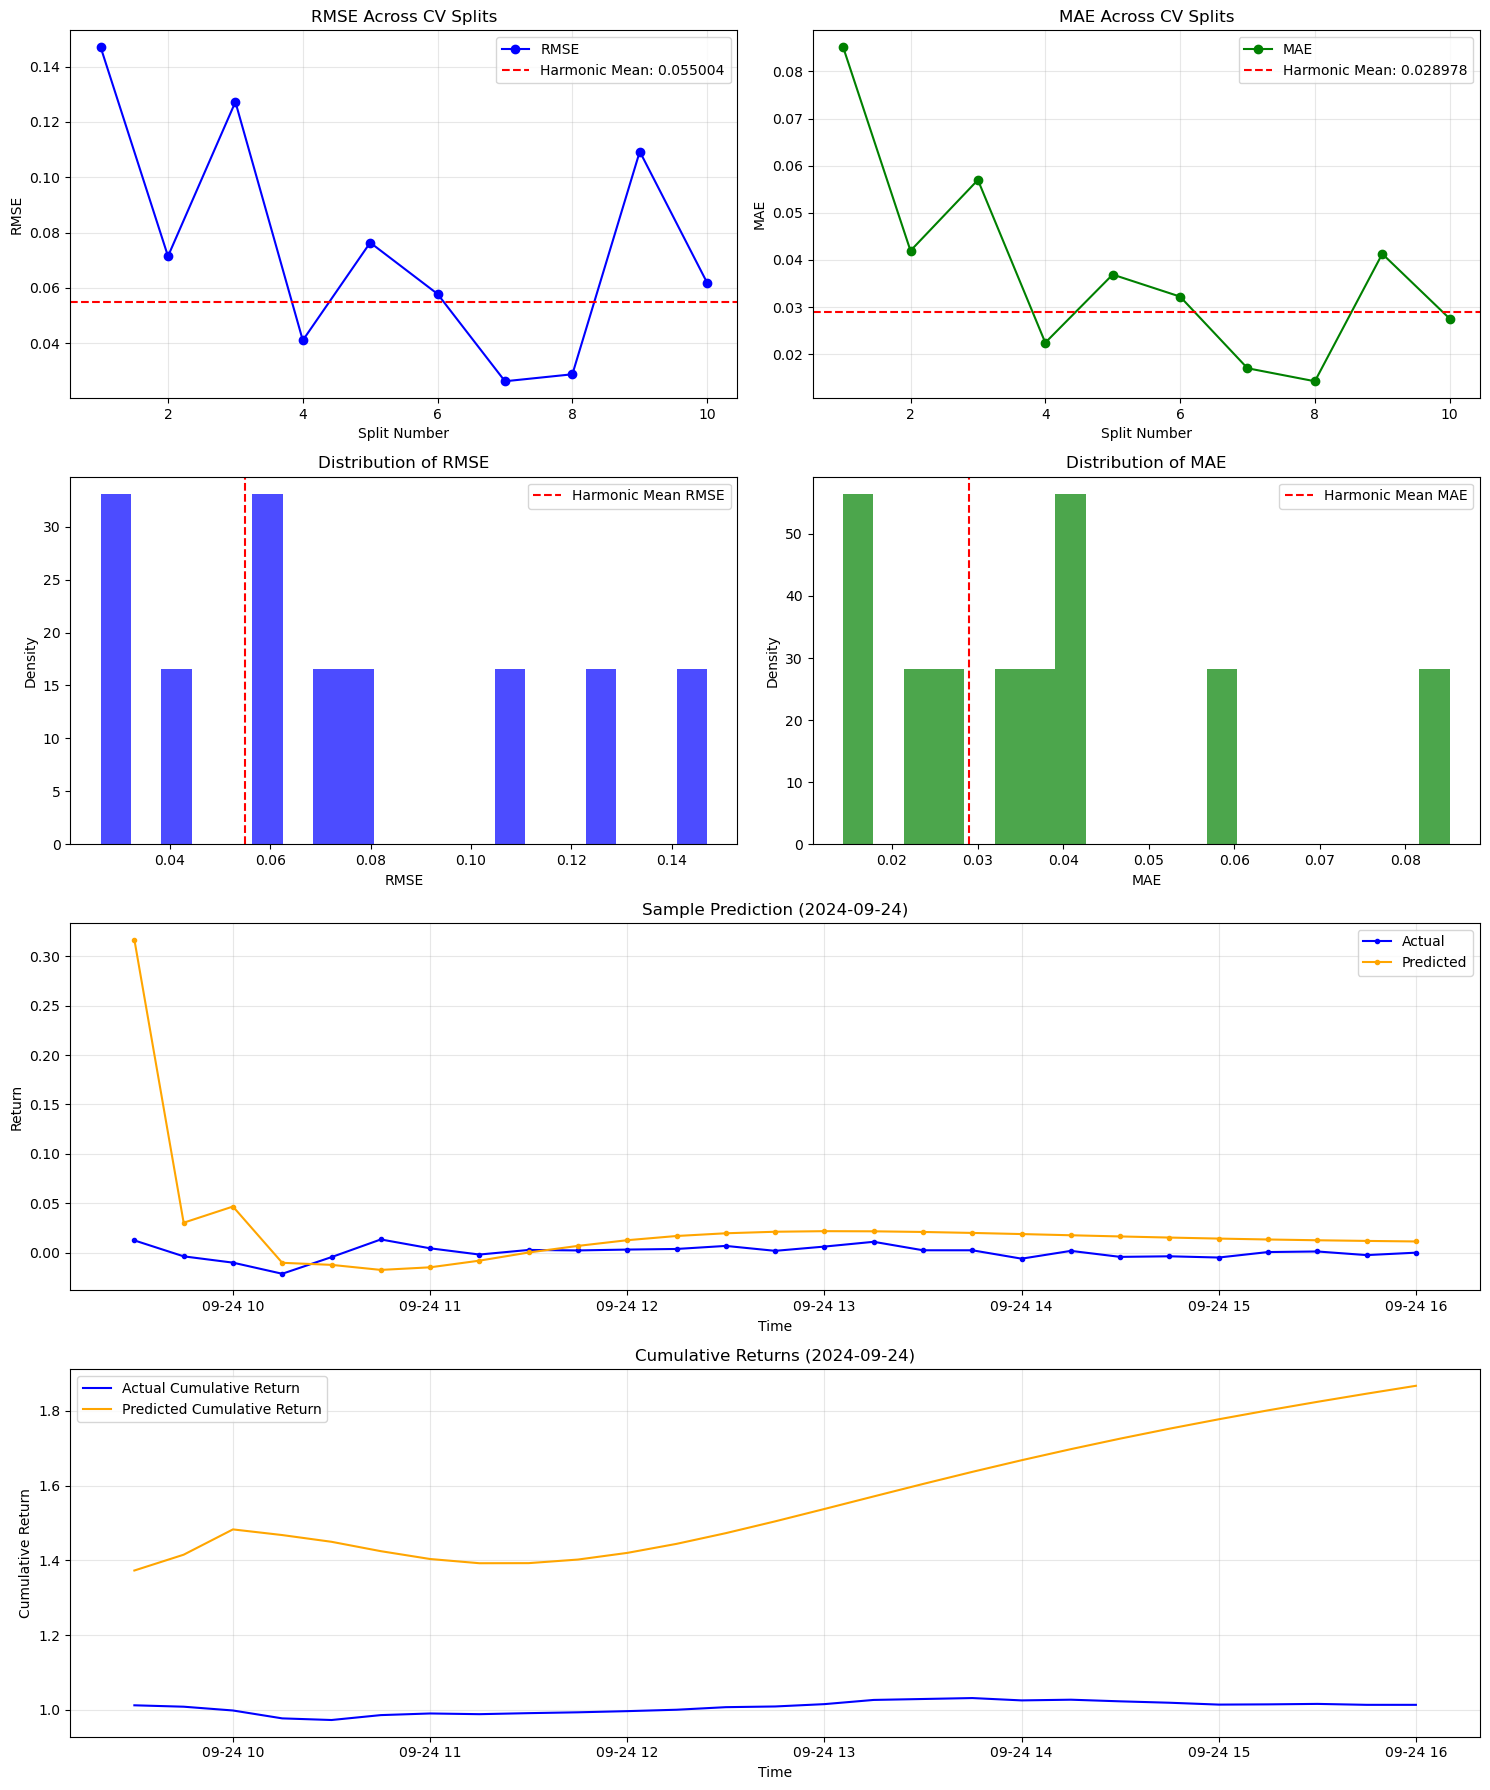

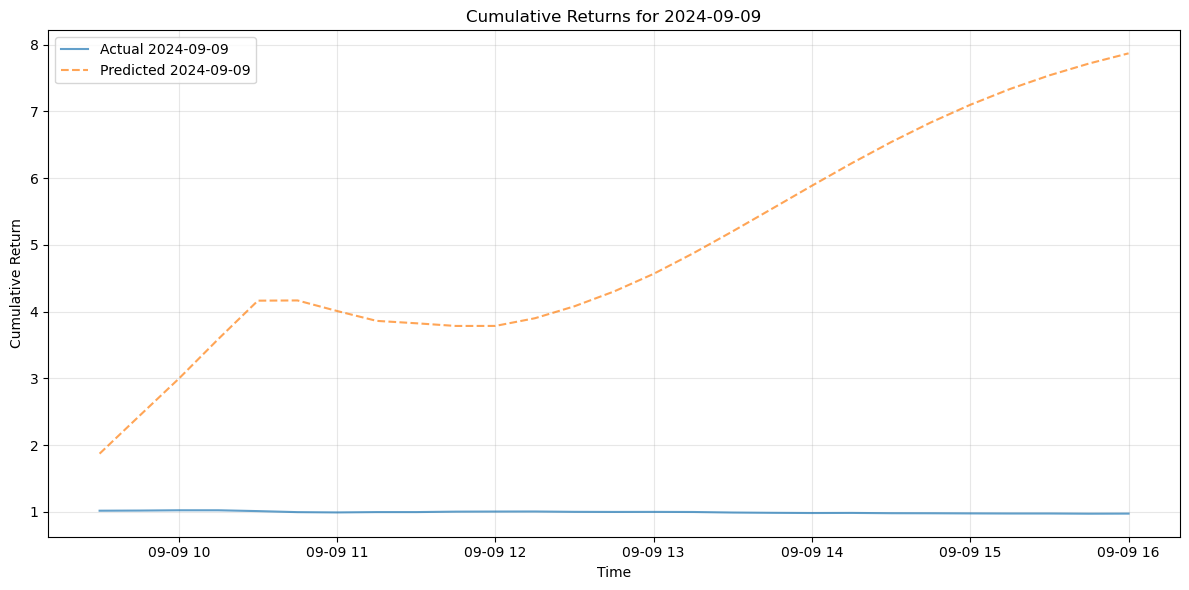

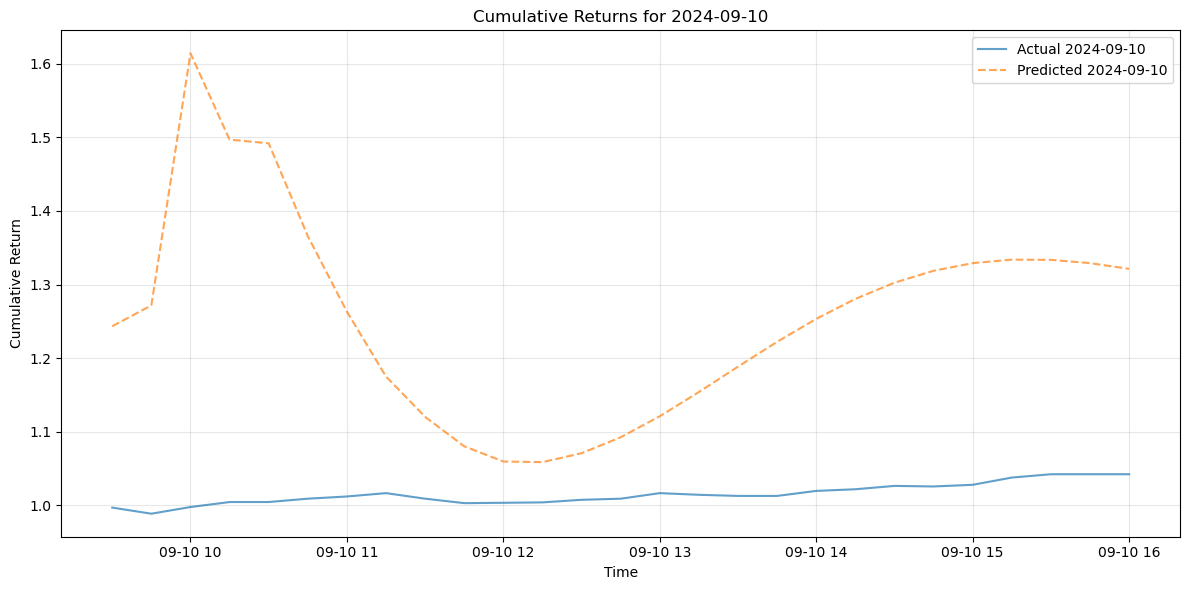

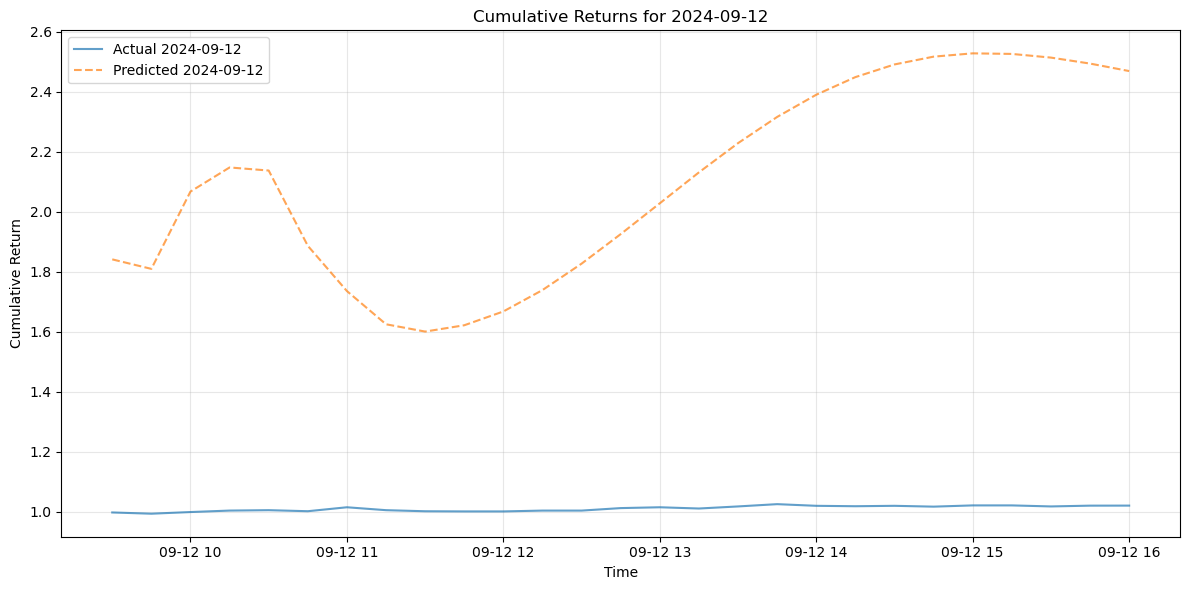

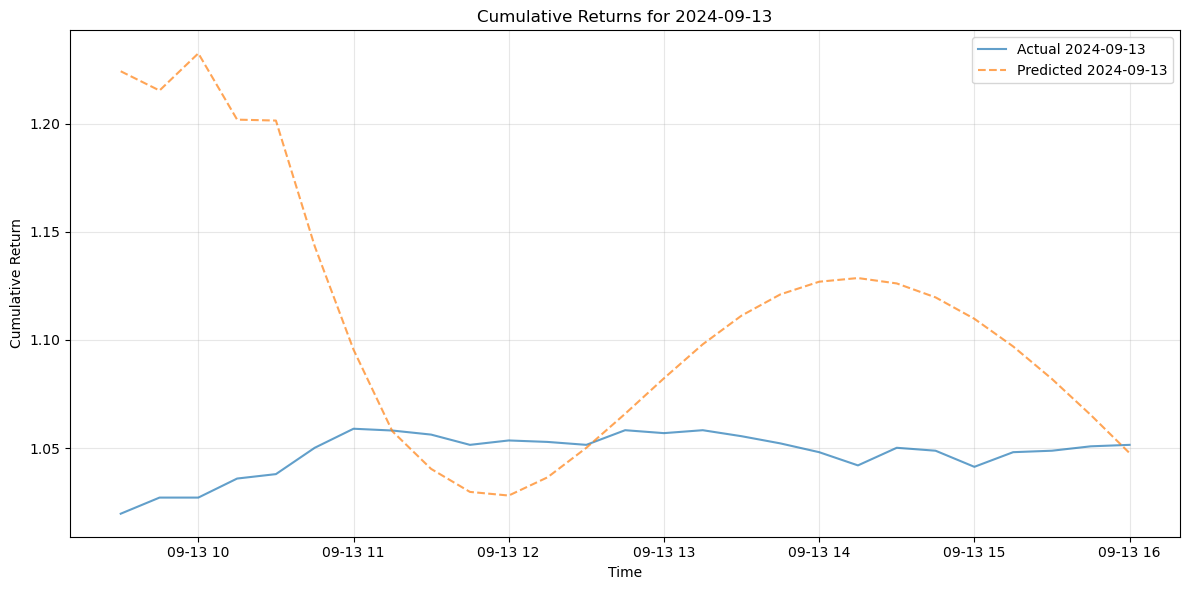

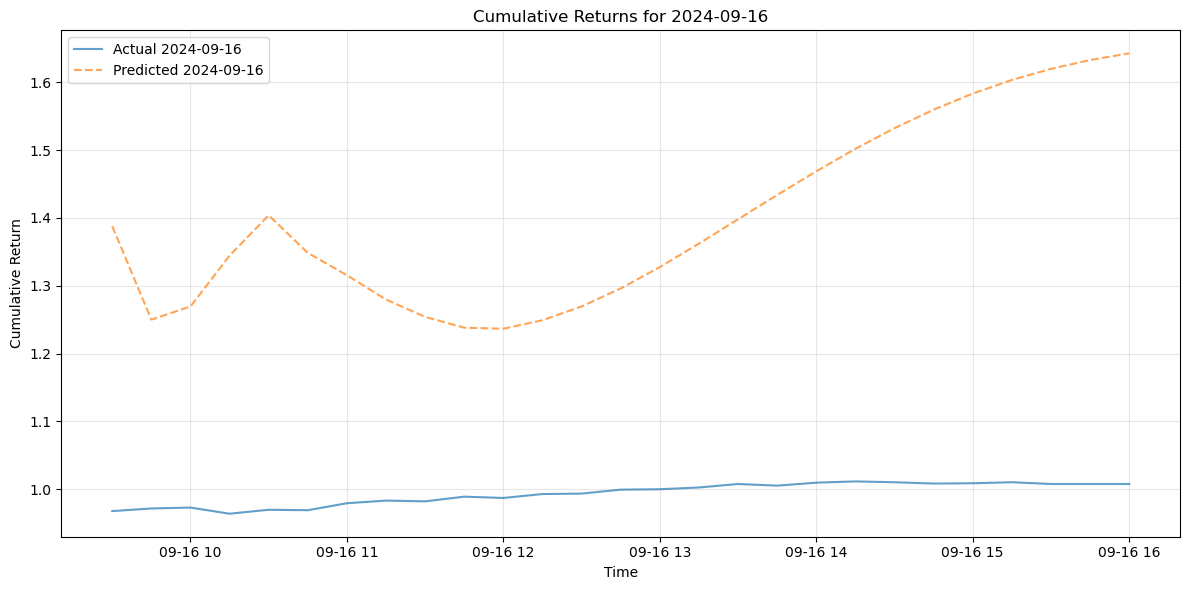

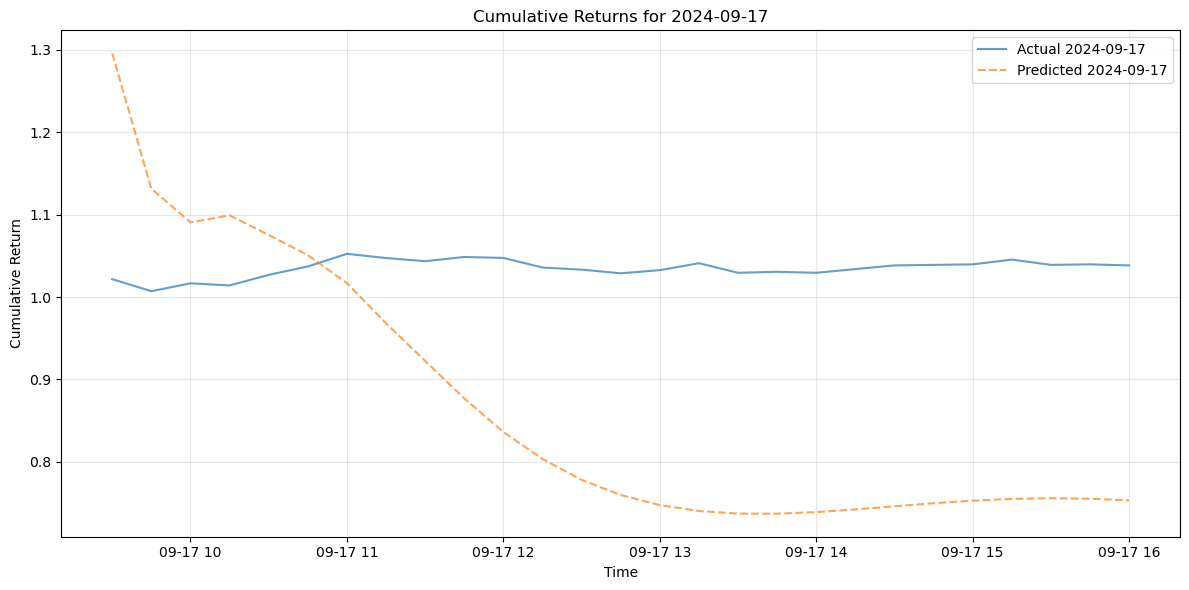

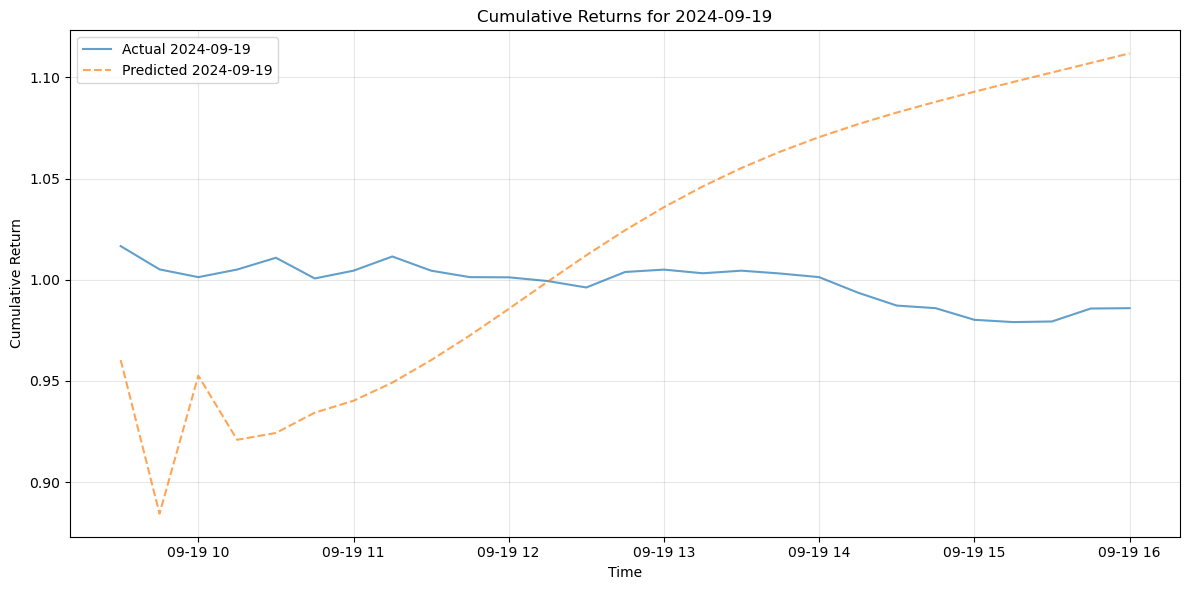

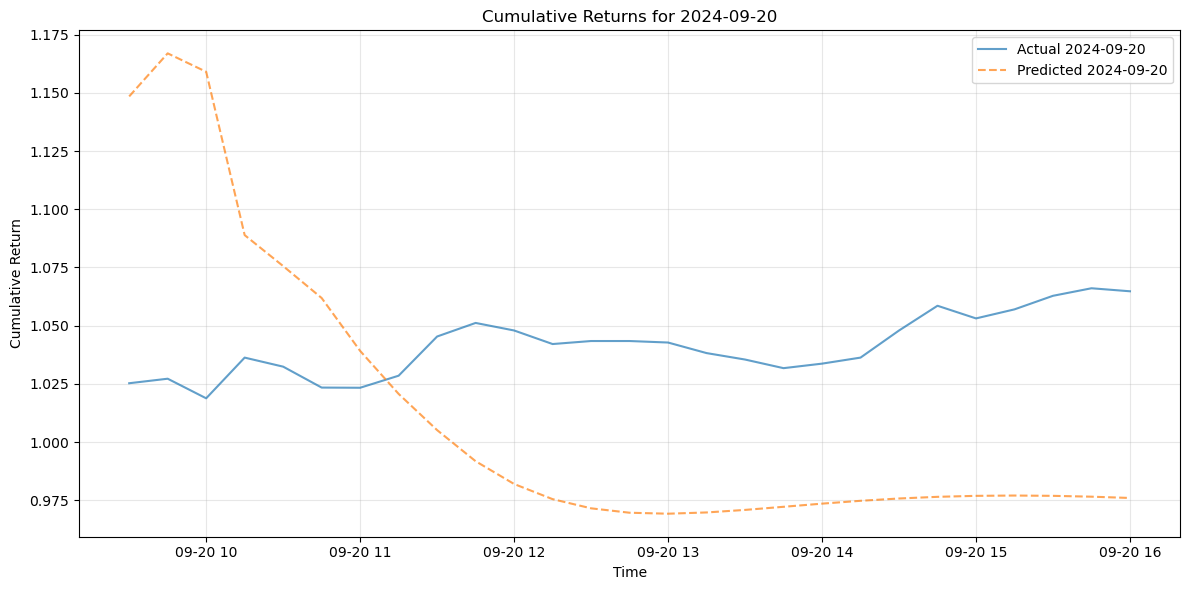

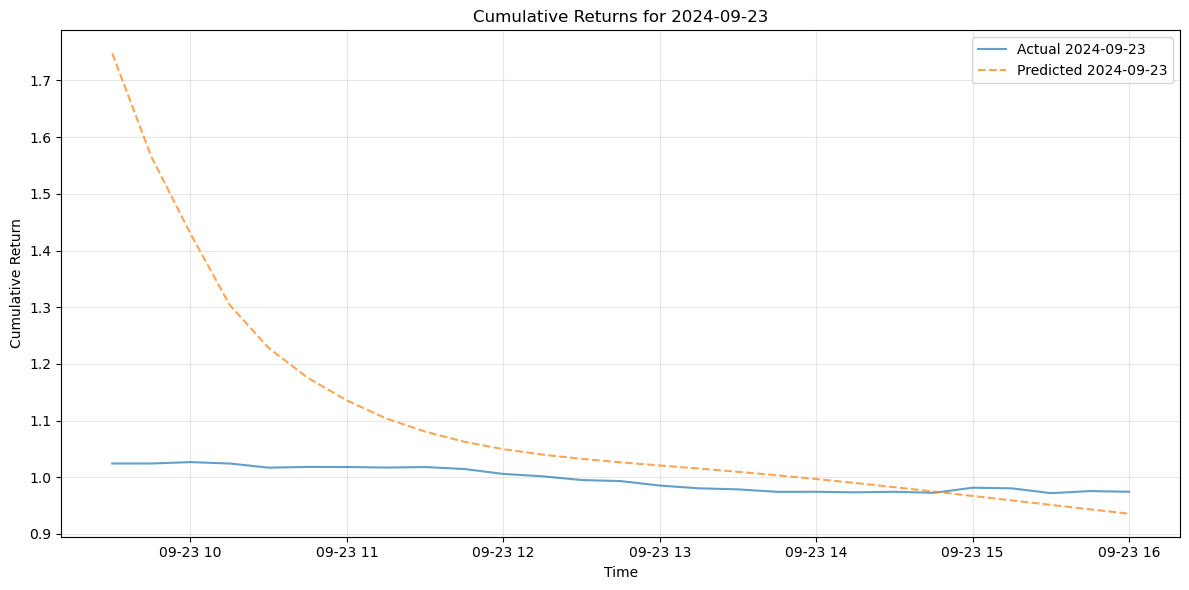

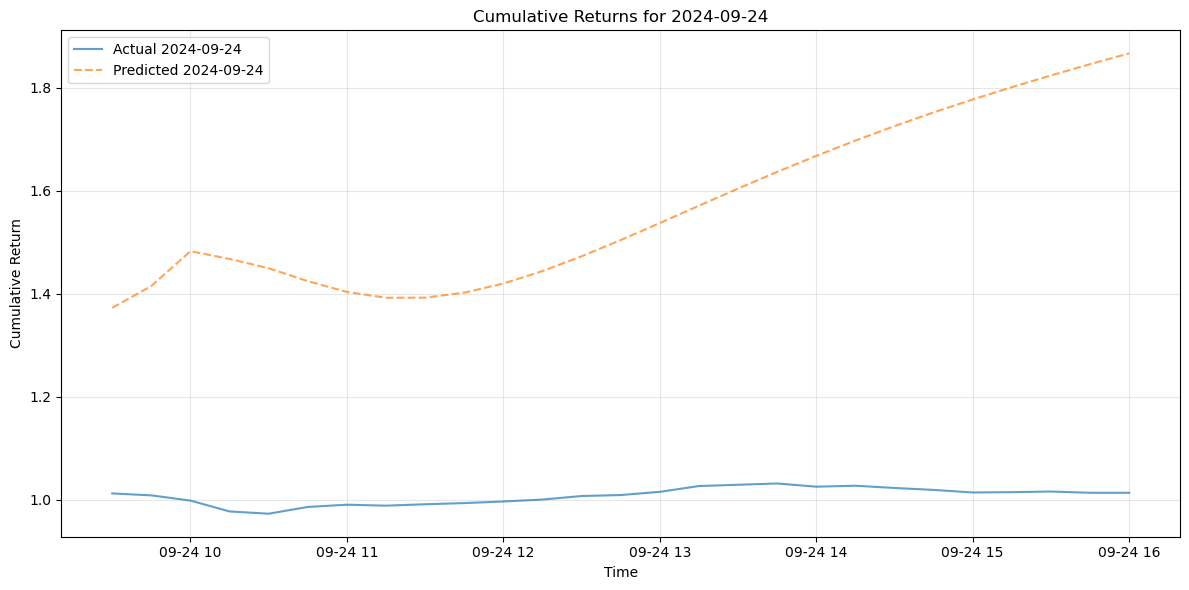

In [10]:
p.plot_cv_results(var_results)
p.plot_all_cumulative_returns(var_results)

### Next, I decided to try again using features from PCA instead of the engineered features themselves.

In [11]:
pca_var_results = p.create_var_predictor(raw_df=df, 
                                         target_ticker='IONQ', 
                                         training_days=30,
                                         forward_periods=27, 
                                         n_features=500, 
                                         n_corr_stocks=4,
                                         n_splits=10,
                                         cross_validation=True,
                                         use_pca=True,
                                         pca_variance=0.95
                                        )


Data Preparation and Feature Selection for VAR Model:
------------------------------------------------------------
Input data range: 2024-08-07 to 2025-02-18

Running in walk-forward cross-validation mode with PCA

Starting VAR Model Walk-Forward Validation:
------------------------------------------------------------

Calculating feature importance to be used across all splits...

Selected top features based on mutual information (used for all splits):
1. ('QUBT', 'day_vol_pct') (MI: 0.2150)
2. ('RGTI', 'day_vol_pct') (MI: 0.1837)
3. ('IONQ', 'day_vol_pct') (MI: 0.1404)
4. ('QSI', 'day_vol_pct') (MI: 0.1221)
5. ('NQ1', 'volume') (MI: 0.1194)
6. ('RGTI', 'vol_4') (MI: 0.1194)
7. ('QBTS', 'day_vol_pct') (MI: 0.1176)
8. ('QBTS', 'rel_vol_5') (MI: 0.1062)
9. ('IONQ', 'vol_13') (MI: 0.1001)
10. ('IONQ', 'IONQ_QSI_rel_vol_4') (MI: 0.0963)
11. ('QUBT', 'vol_std_26') (MI: 0.0948)
12. ('ES1', 'vol_13') (MI: 0.0935)
13. ('IONQ', 'IONQ_NQ1_corr_4') (MI: 0.0930)
14. ('ES1', 'volume') (MI: 0.0926

### The results here are much better, as the RMSE decreased to 0.01119, and the MAE to 0.007327. This suggests that MI was not the best way to select features in the above step and that there was still a lot of multicollinearity present. By those metrics, the model performed worse than ARIMA(3,0,3). However, the return curves here have a much more resemblence to the actual shape. Strangely enough, some of these return curve shapes almost look inverted.

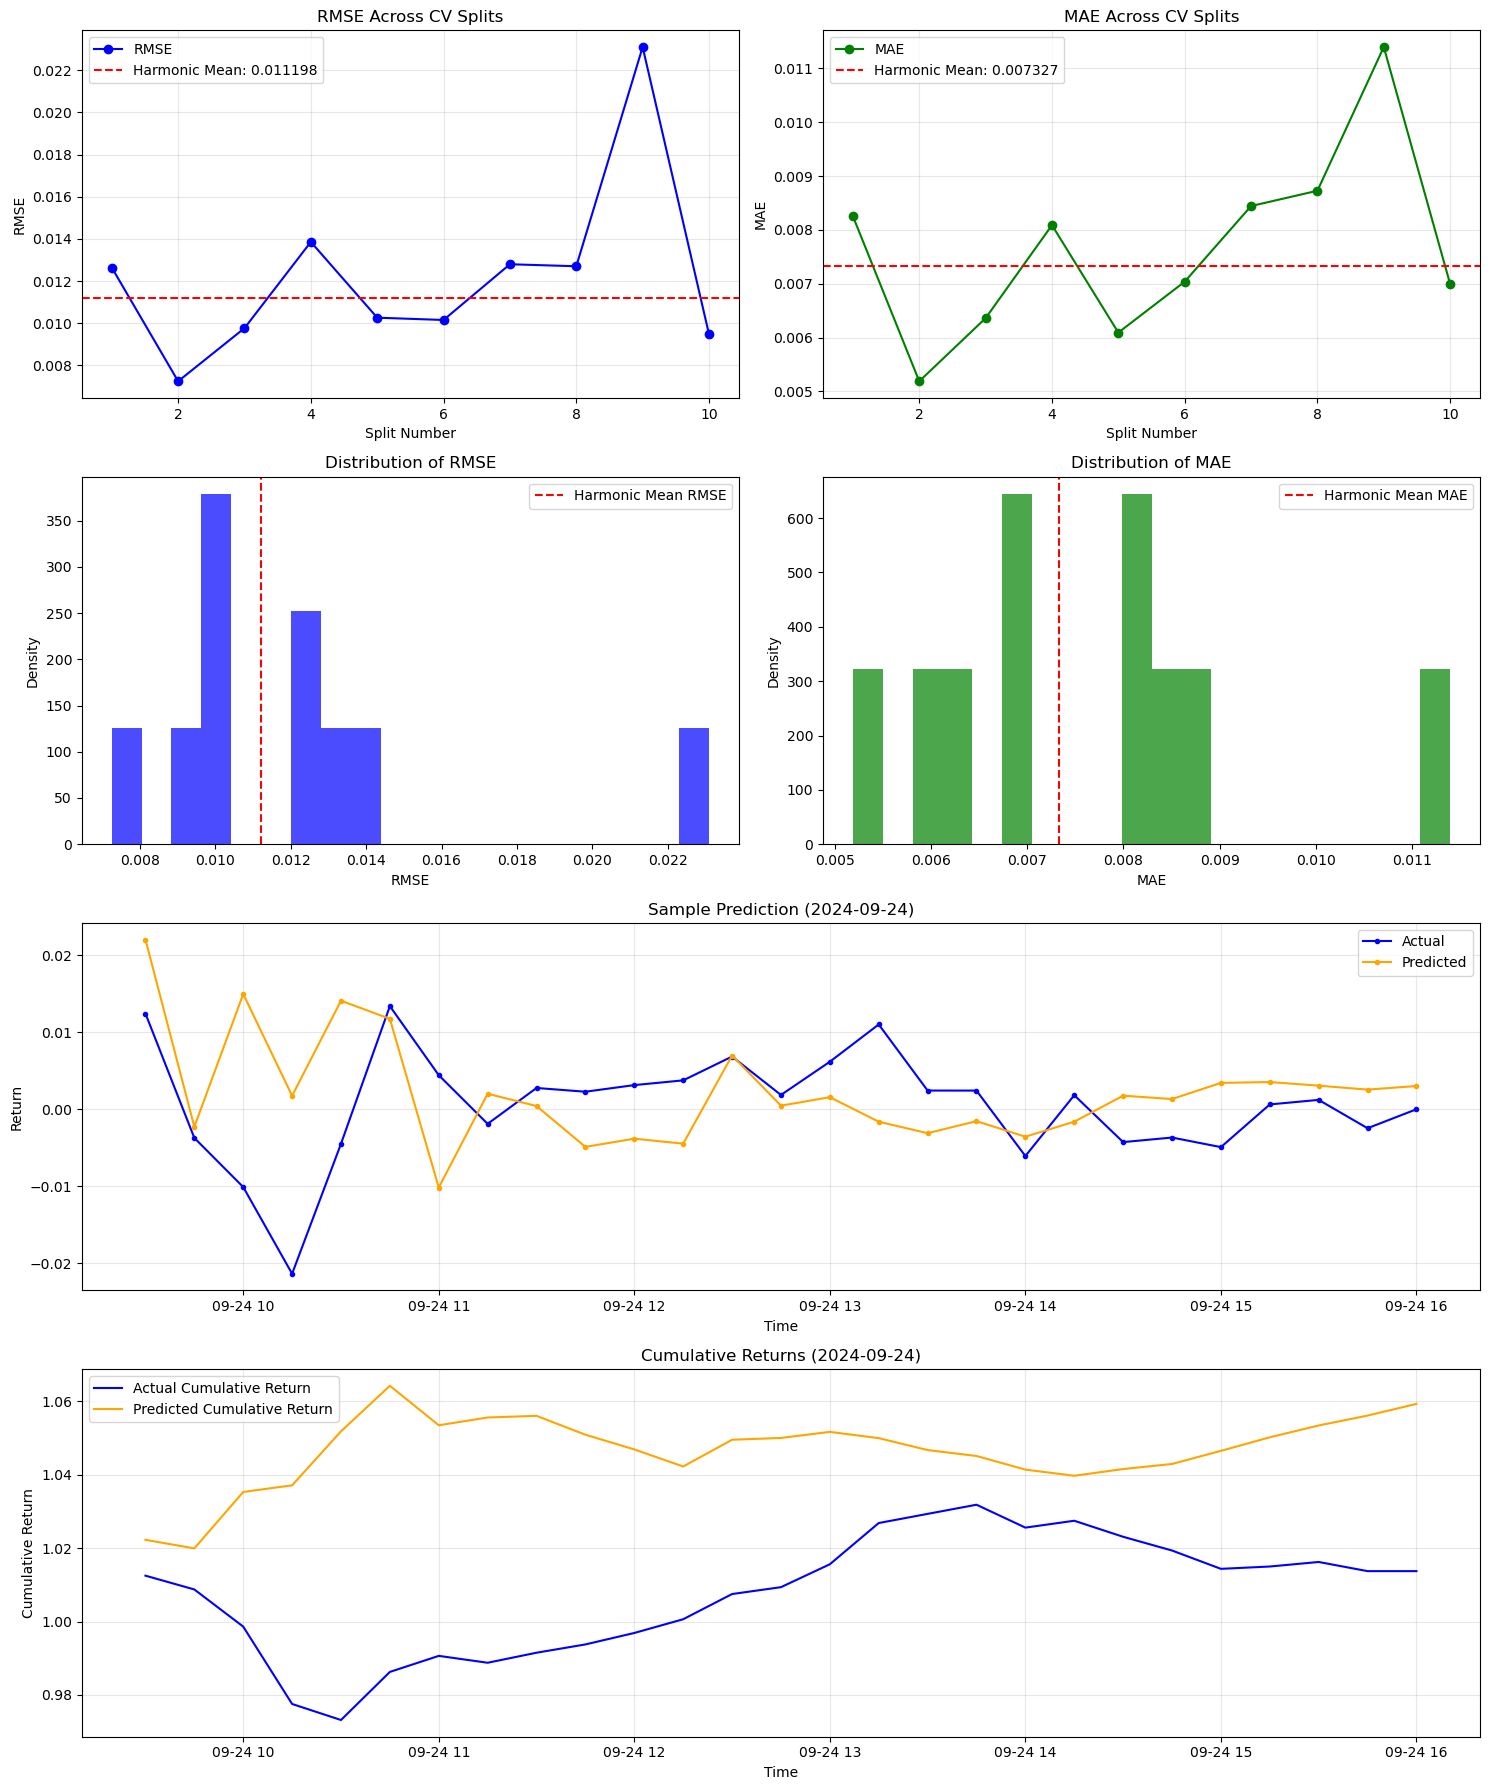

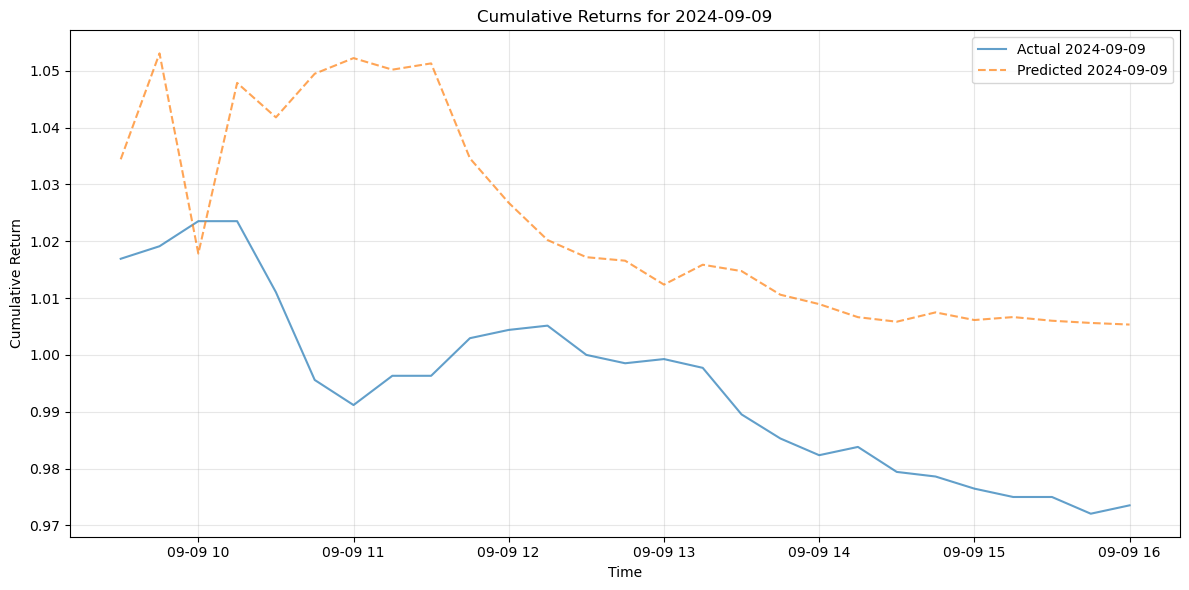

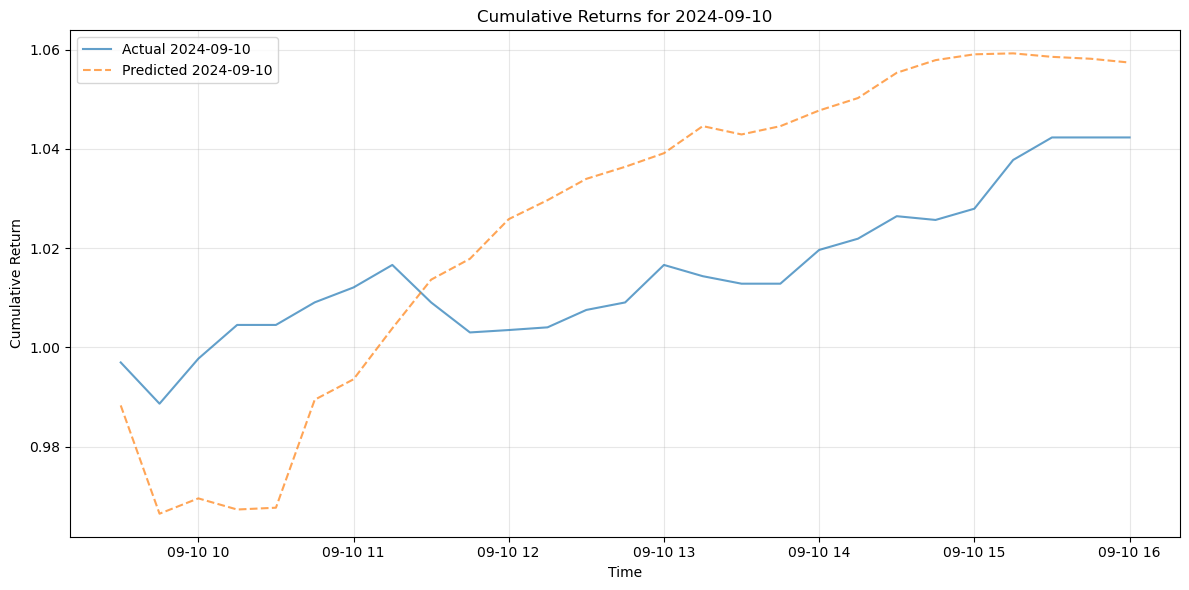

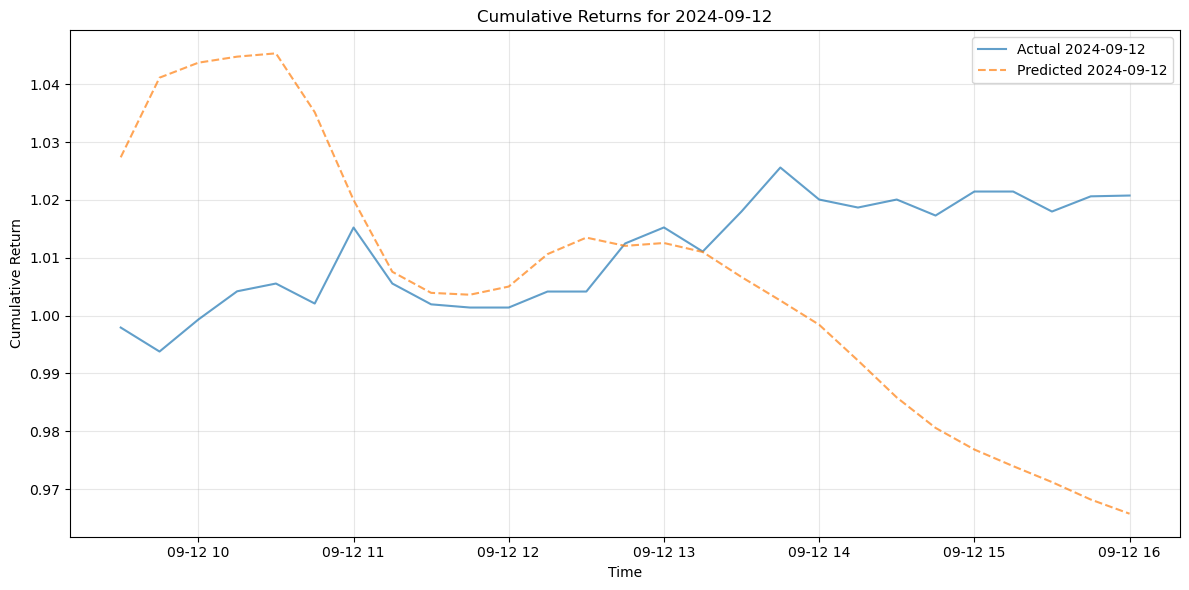

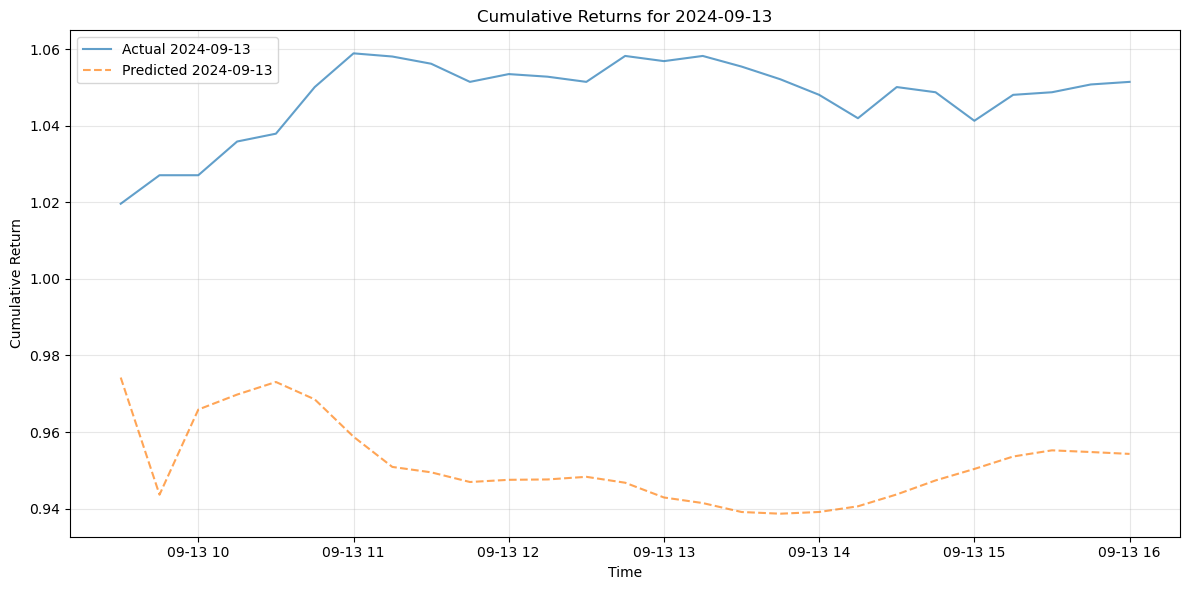

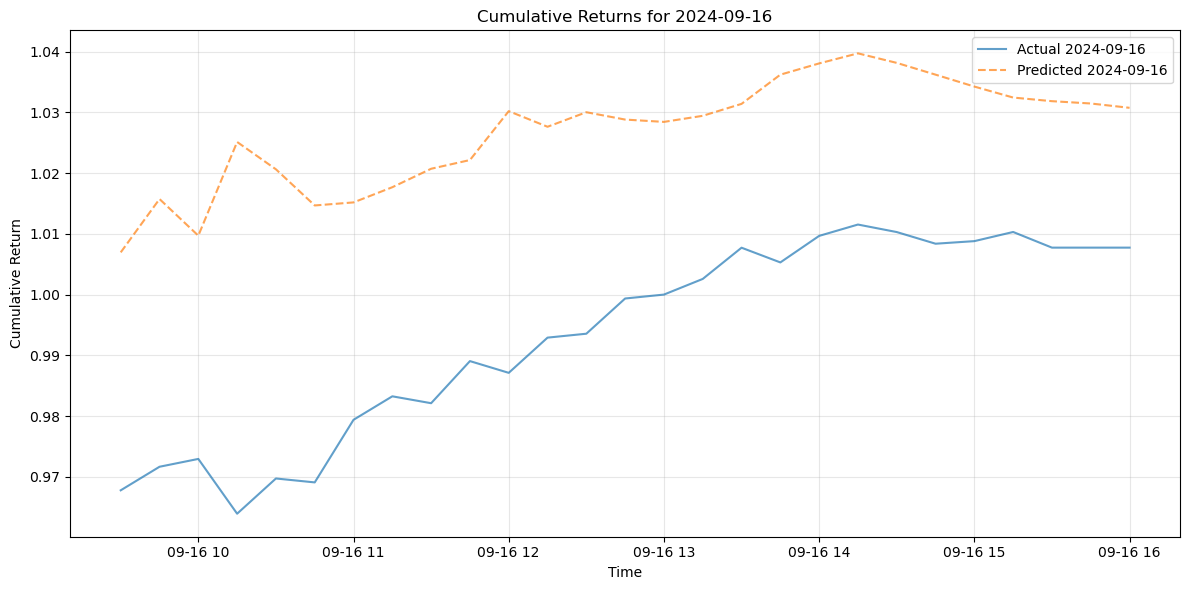

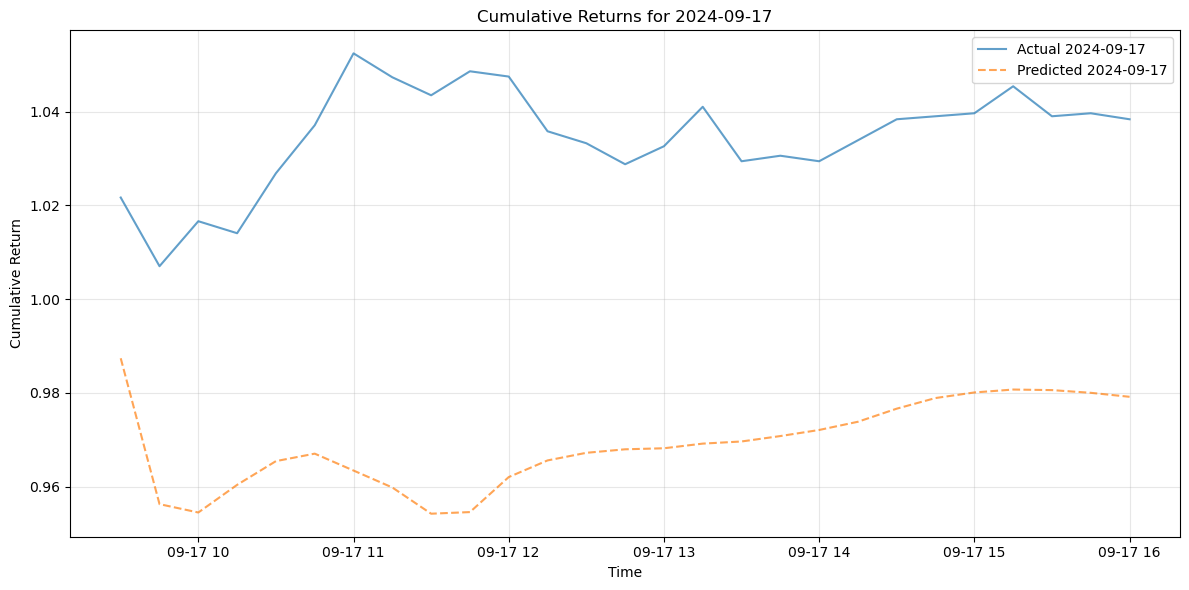

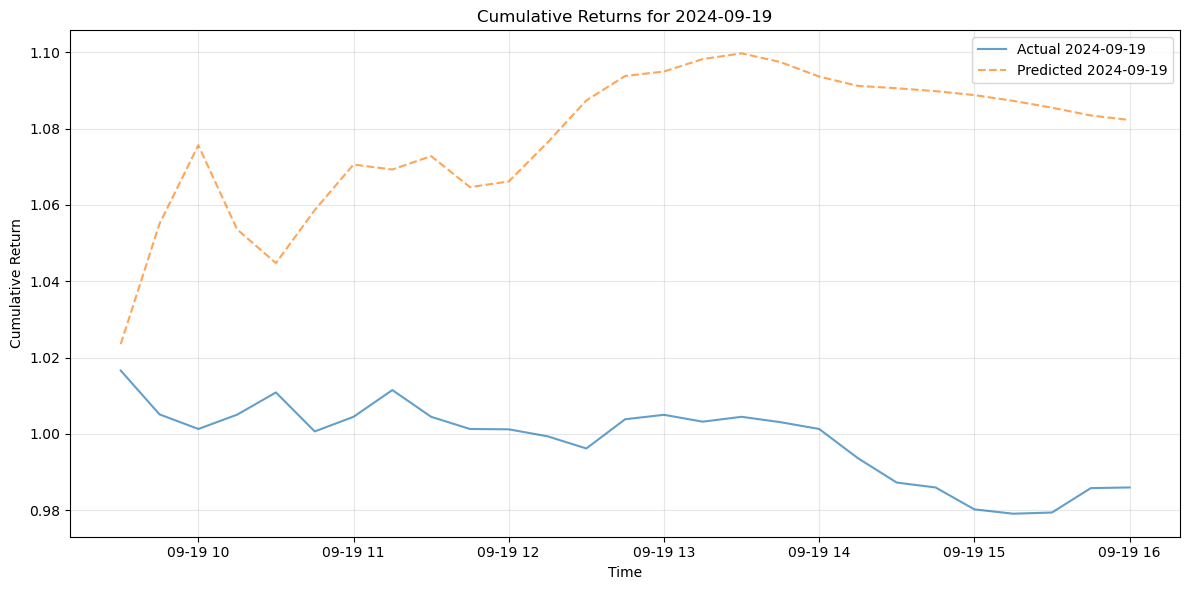

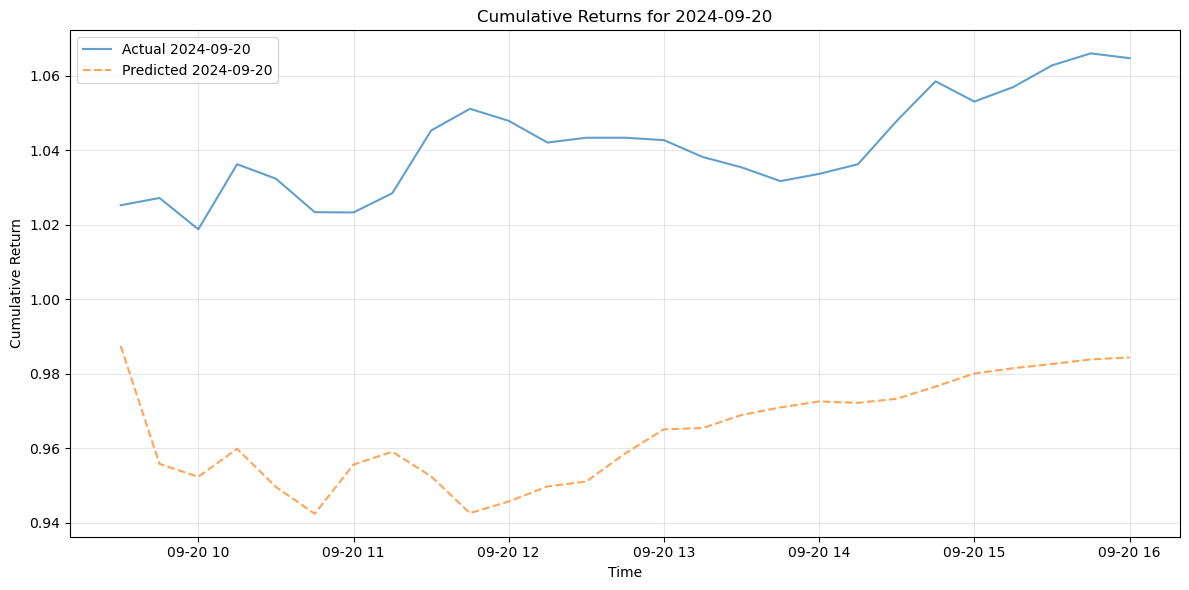

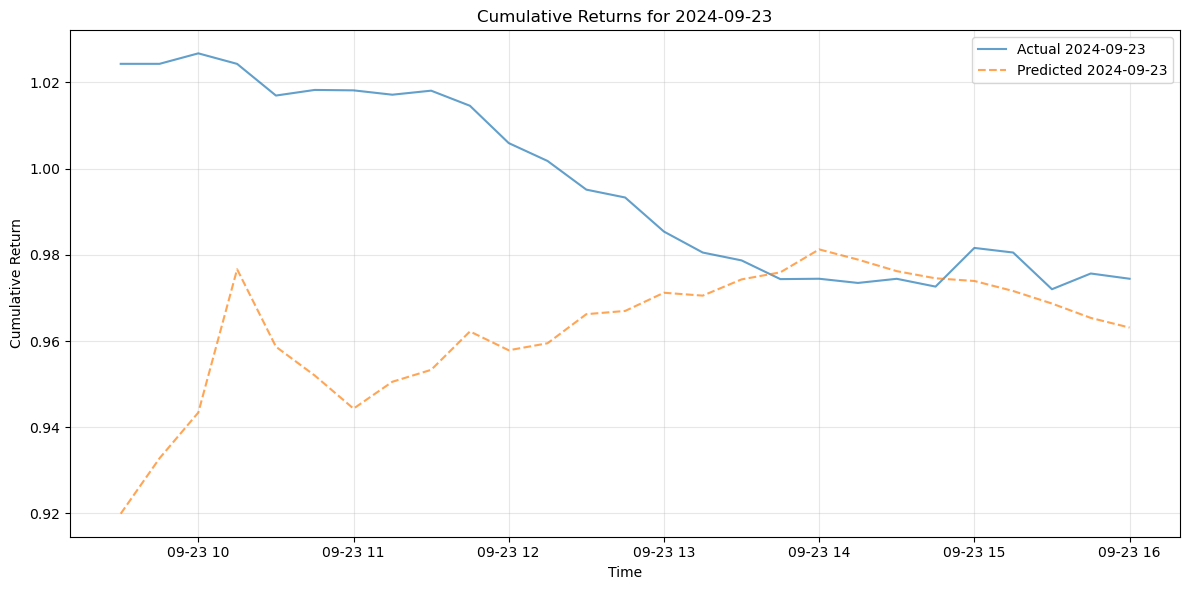

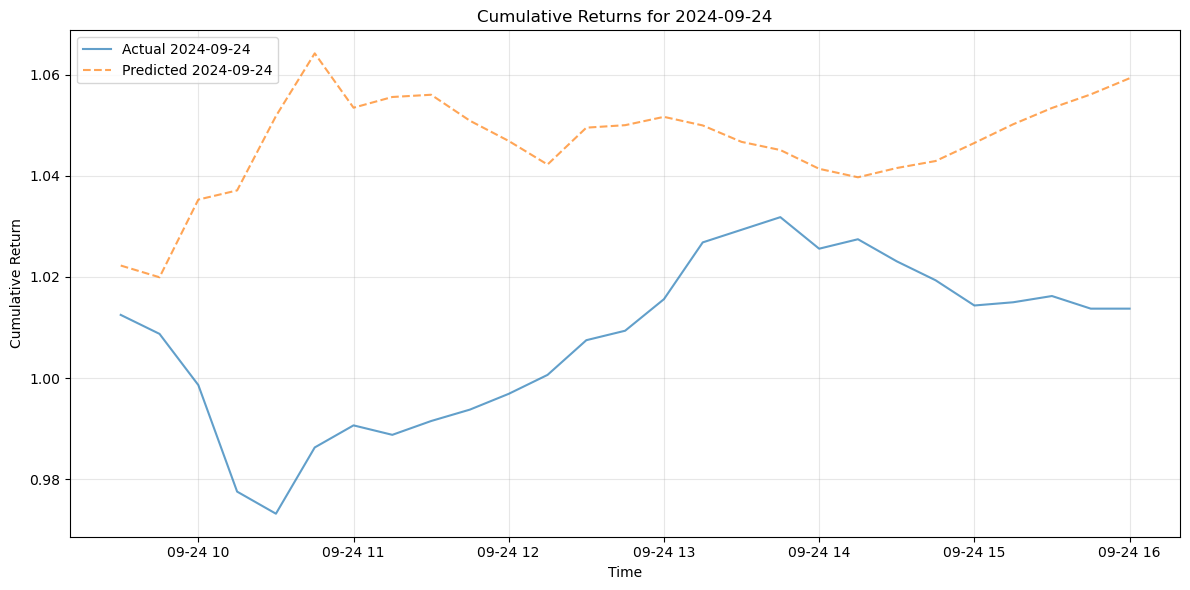

In [12]:
p.plot_cv_results(pca_var_results)
p.plot_all_cumulative_returns(pca_var_results)

## Gradient Boosting

### Lastly, I tried gradient boosting with XGBoost.

#### The `create_xgb_predictor` method is designed similarly to the `create_var_predictor` method, with the main difference being that I did not do any feature selection due to the fact that gradient boosting implicitly does feature selection. I set the objectives differently for the two sets of results below: `pseudohubererror` and `absoluteerror`. I chose pseudohuberror because I understand it to be well suited for fat-tailed distributions, which is generally true for financial returns, especially intraday data. You can tell that the curve for absolute error looks more mild due to it optimizing for prediction of the median.

In [13]:
xgb_results = p.create_xgb_predictor(raw_df=df,
                                     target_ticker='IONQ',
                                     training_days=30,
                                     forward_periods=27,
                                     n_features=10, 
                                     n_corr_stocks=4,
                                     n_splits=10,
                                     cross_validation=True,
                                     custom_xgb_params={
                                        'objective': 'reg:pseudohubererror',
                                        'learning_rate': 0.05,
                                        'max_depth': 4,
                                        'n_estimators': 100,
                                        'min_child_weight': 3,
                                        'subsample': 0.8,
                                        'colsample_bytree': 0.8,
                                        'random_state': 42
                                     })


Feature Engineering and Model Preparation:
------------------------------------------------------------
Input data range: 2024-08-07 to 2025-02-18

Using custom XGBoost parameters:
objective: reg:pseudohubererror
learning_rate: 0.05
max_depth: 4
n_estimators: 100
min_child_weight: 3
subsample: 0.8
colsample_bytree: 0.8
random_state: 42

Running in walk-forward cross-validation mode

Starting Walk-Forward Validation:
------------------------------------------------------------

Initializing preprocessing pipeline that will be used across all splits...
Creating feature pipeline based on initial training window...

Identifying correlated stocks for all splits...
Correlated Quantum Stocks (used for all splits):
- QBTS (correlation: 0.571)
- RGTI (correlation: 0.553)
- QUBT (correlation: 0.444)
- QSI (correlation: 0.228)

Fitting individual feature scalers (will be reused across all splits)...
Identified 17 features to be left unscaled

Training initial model to determine feature importanc

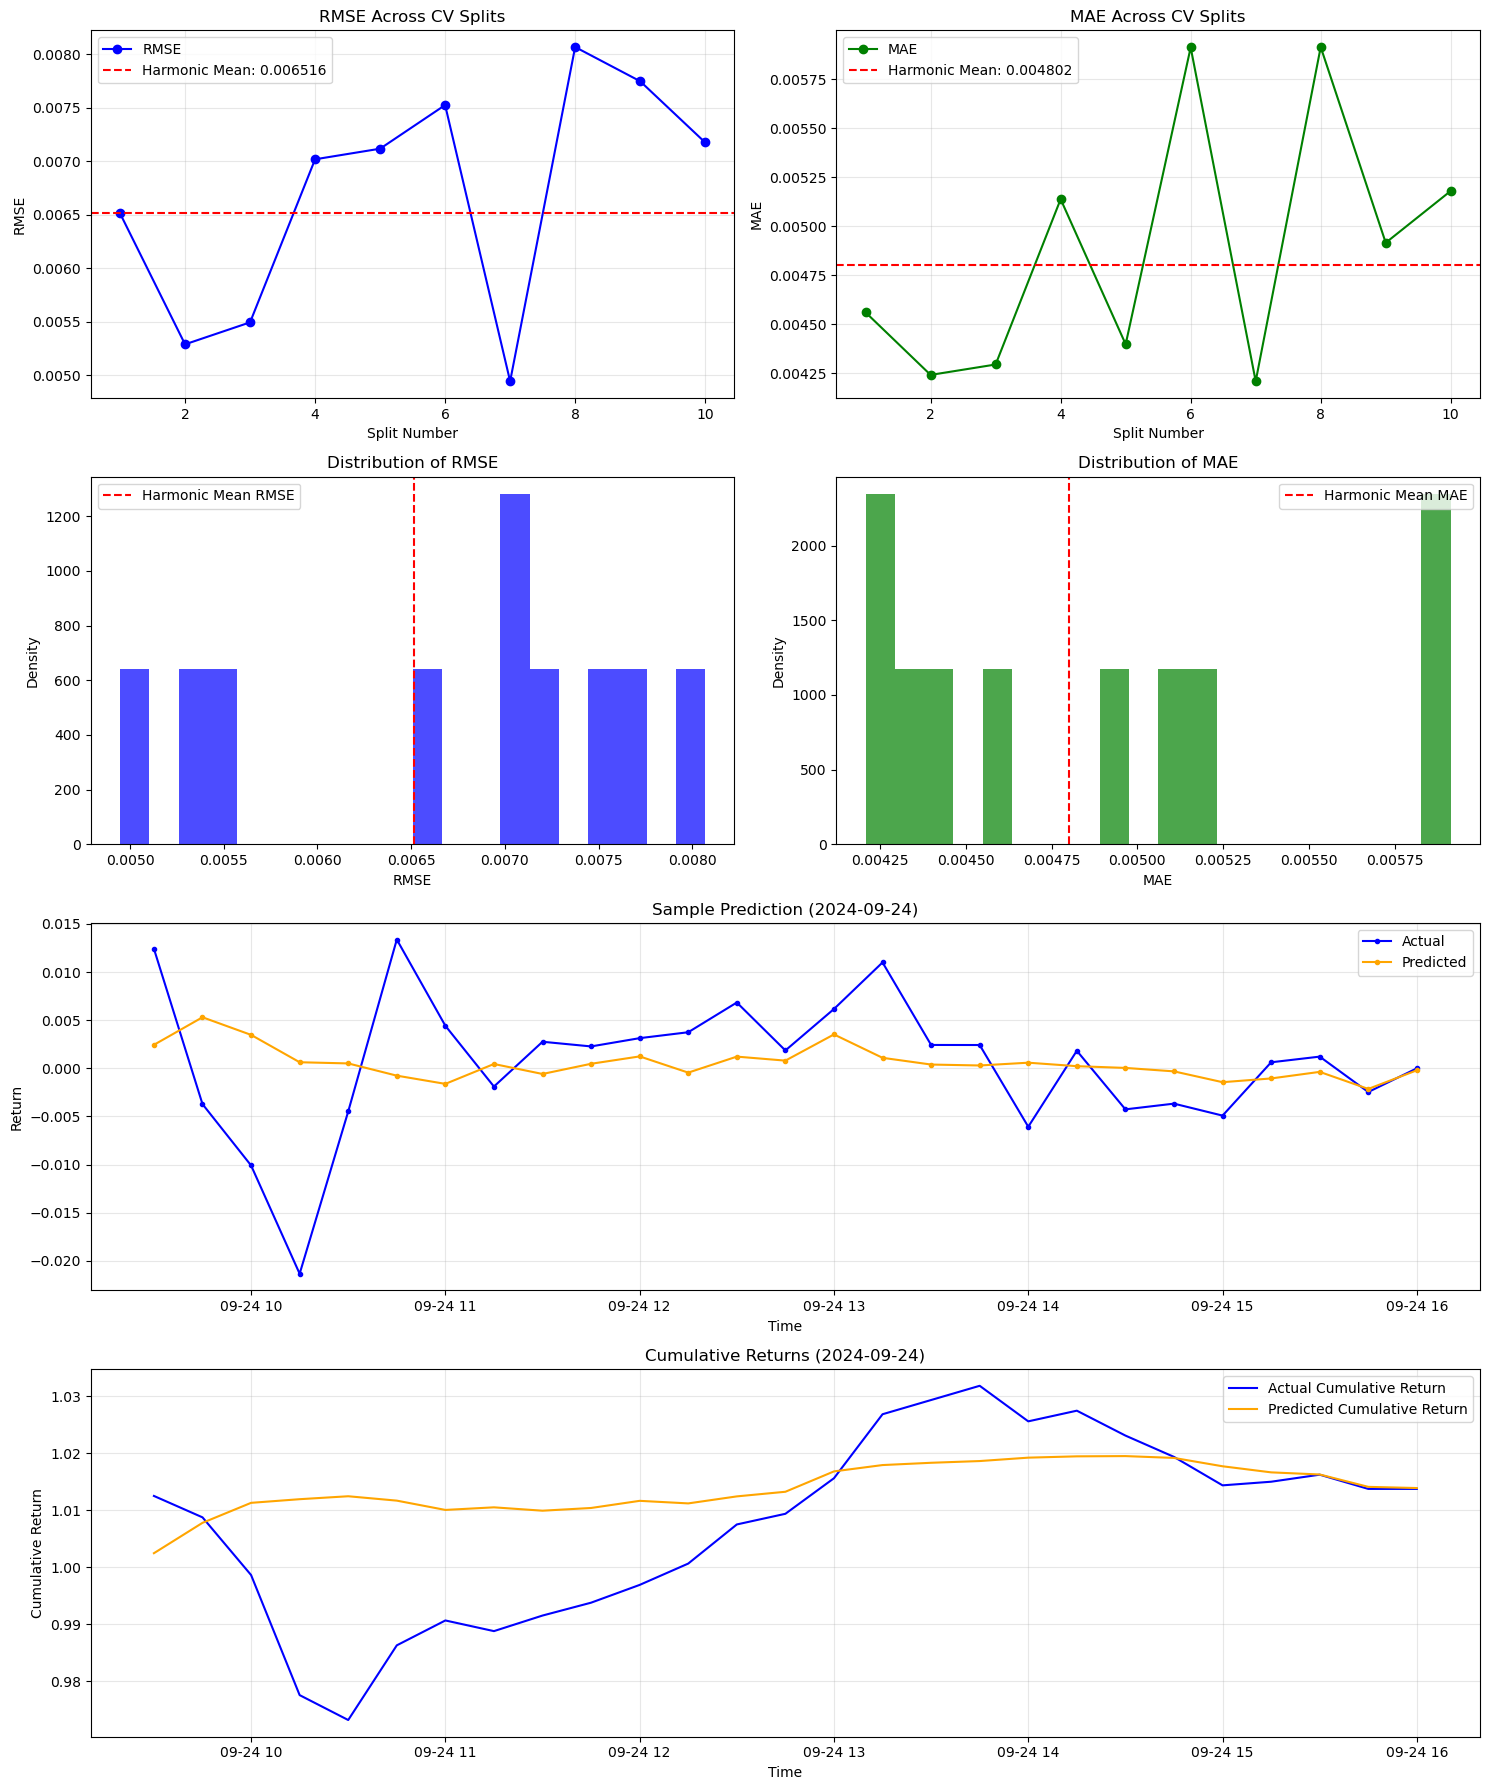

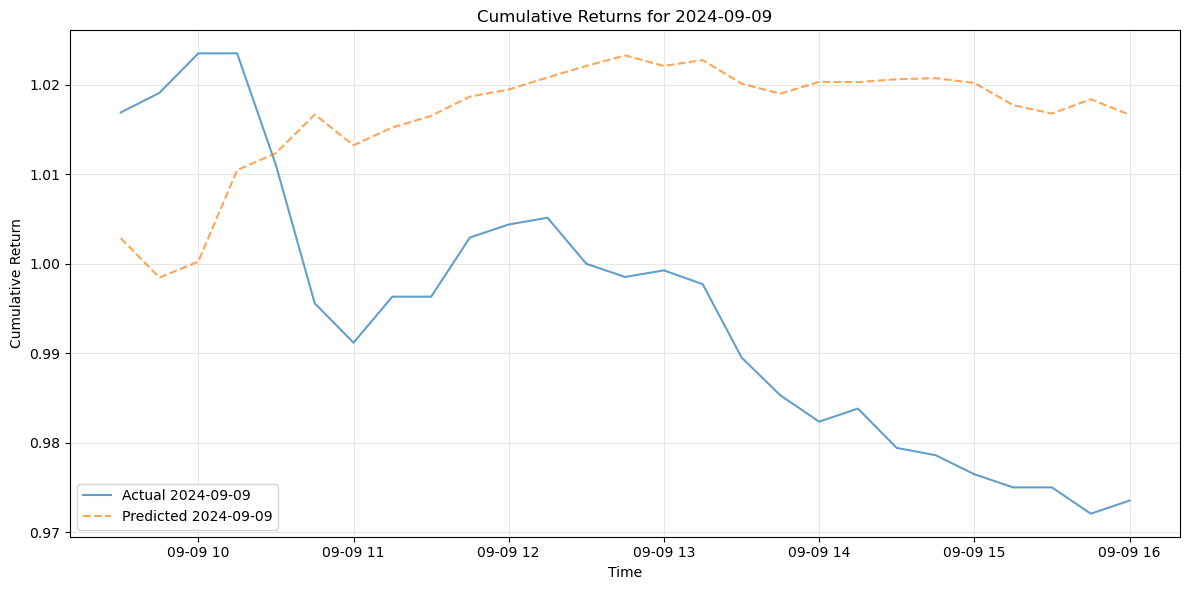

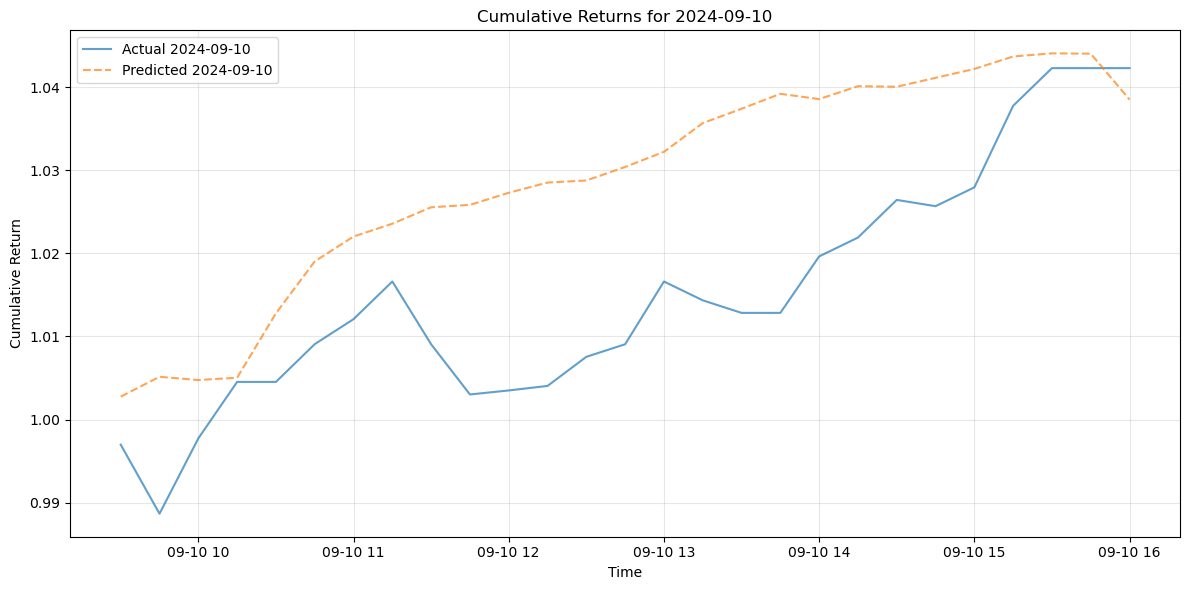

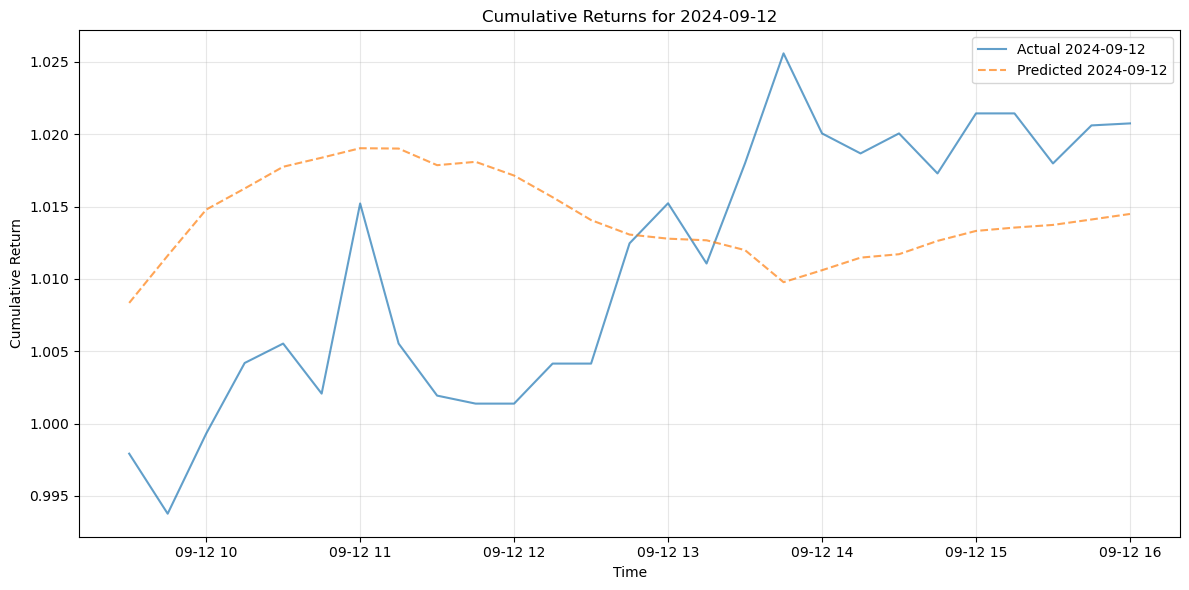

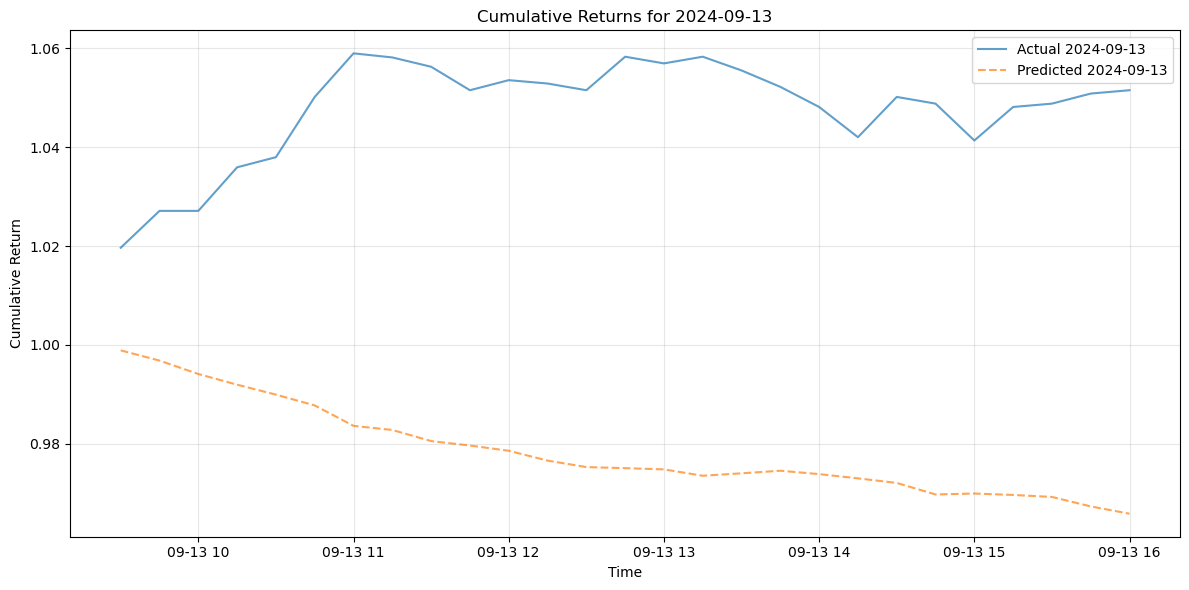

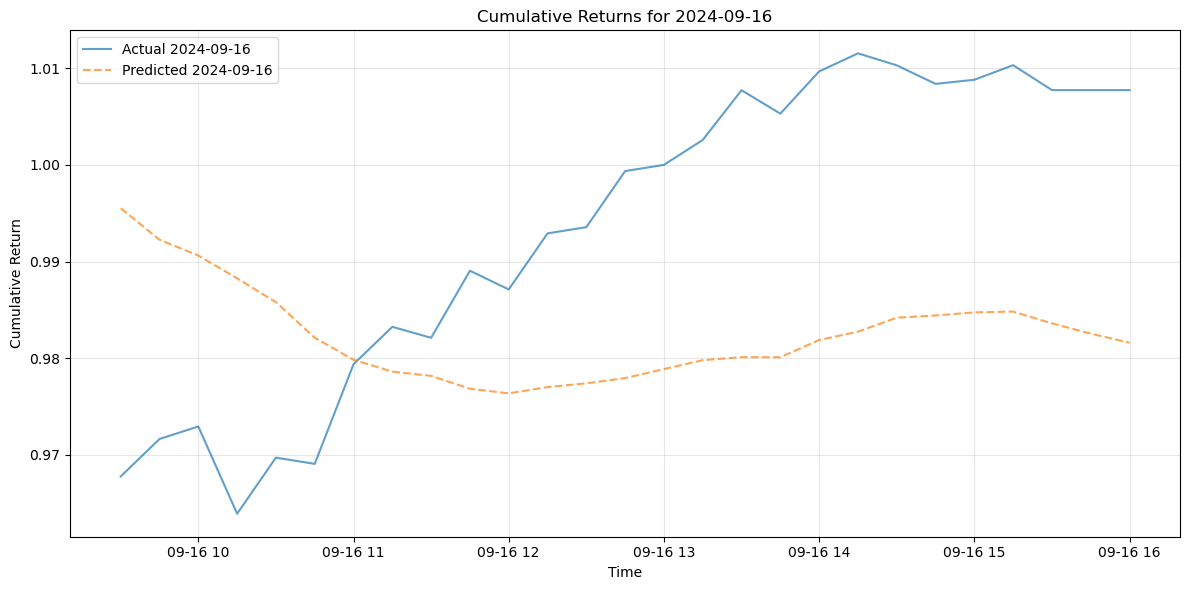

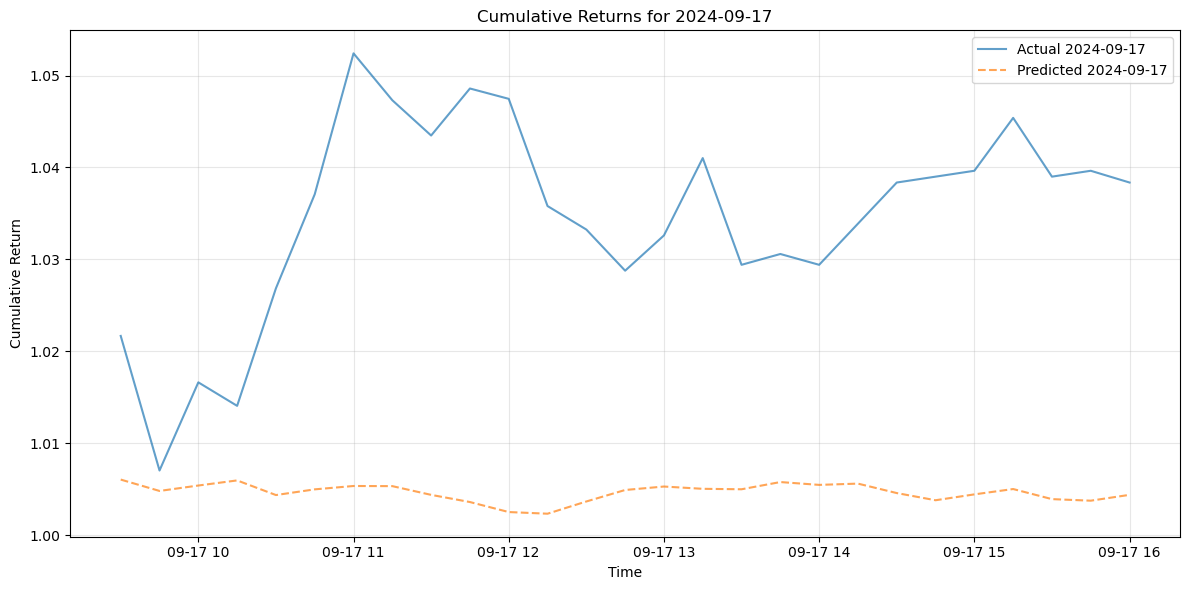

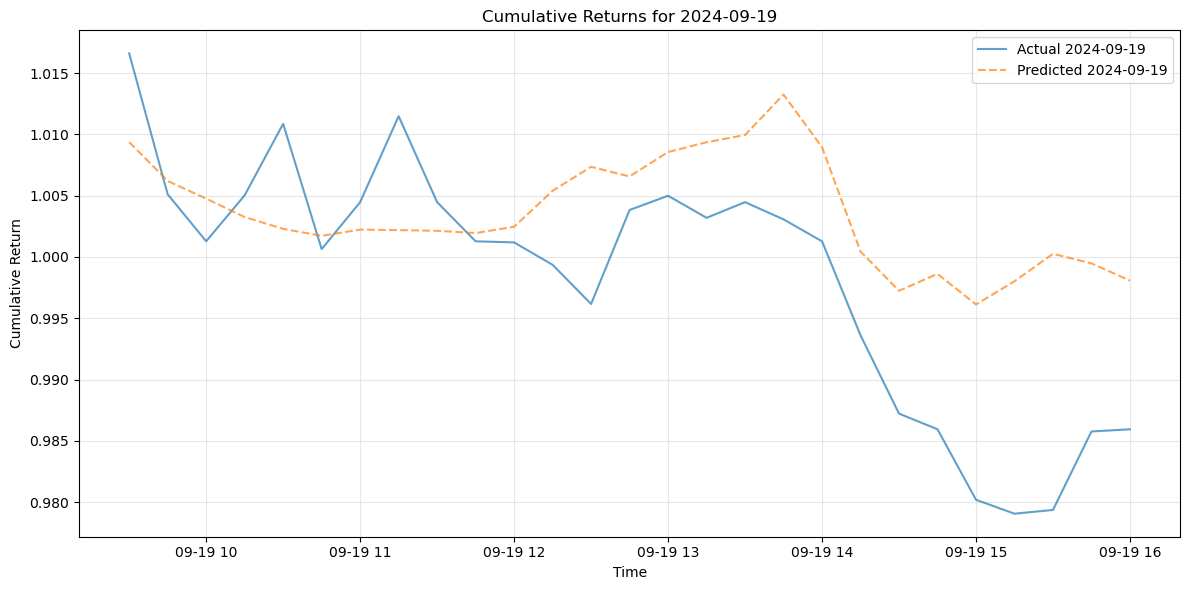

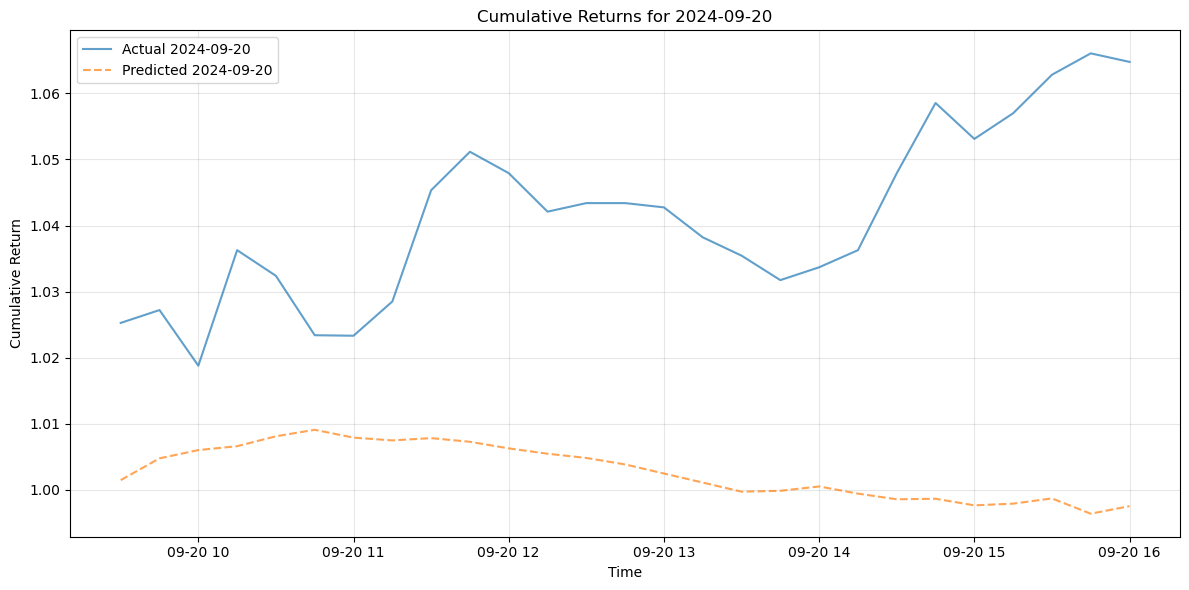

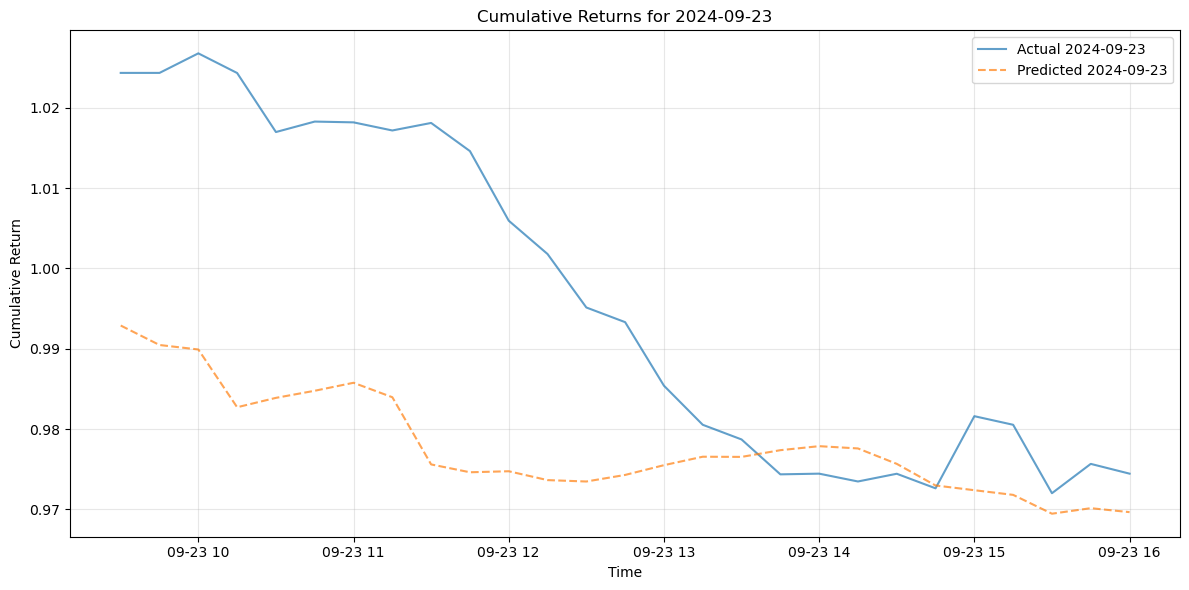

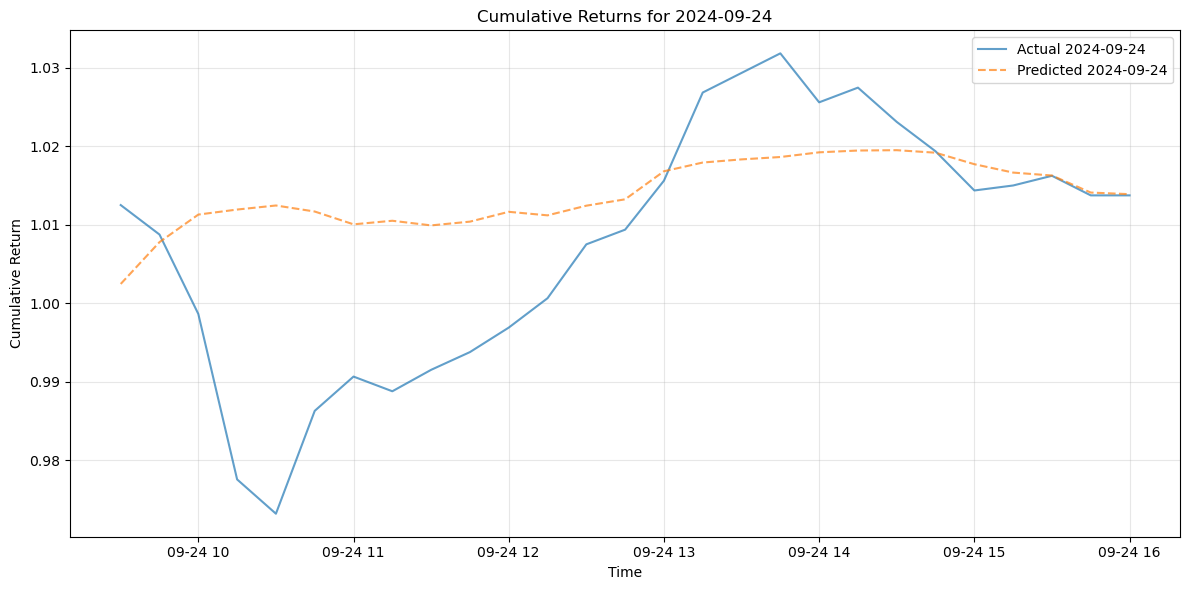

In [14]:
p.plot_cv_results(xgb_results)
p.plot_all_cumulative_returns(xgb_results)

In [ ]:
xgb_results = p.create_xgb_predictor(raw_df=df,
                                     target_ticker='IONQ',
                                     training_days=30,
                                     forward_periods=27,
                                     n_features=10, 
                                     n_corr_stocks=4,
                                     n_splits=10,
                                     cross_validation=True,
                                     custom_xgb_params={
                                        'objective': 'reg:absoluteerror',
                                        'learning_rate': 0.05,
                                        'max_depth': 4,
                                        'n_estimators': 100,
                                        'min_child_weight': 3,
                                        'subsample': 0.8,
                                        'colsample_bytree': 0.8,
                                        'random_state': 42
                                     })


Feature Engineering and Model Preparation:
------------------------------------------------------------
Input data range: 2024-08-07 to 2025-02-18

Using custom XGBoost parameters:
objective: reg:absoluteerror
learning_rate: 0.05
max_depth: 4
n_estimators: 100
min_child_weight: 3
subsample: 0.8
colsample_bytree: 0.8
random_state: 42

Running in walk-forward cross-validation mode

Starting Walk-Forward Validation:
------------------------------------------------------------

Initializing preprocessing pipeline that will be used across all splits...
Creating feature pipeline based on initial training window...

Identifying correlated stocks for all splits...
Correlated Quantum Stocks (used for all splits):
- QBTS (correlation: 0.571)
- RGTI (correlation: 0.553)
- QUBT (correlation: 0.444)
- QSI (correlation: 0.228)

Fitting individual feature scalers (will be reused across all splits)...
Identified 17 features to be left unscaled

Training initial model to determine feature importance..

In [ ]:
p.plot_cv_results(xgb_results)
p.plot_all_cumulative_returns(xgb_results)

### Ultimately, the harmonic mean of the RMSE and MAE across CV splits were 0.006516 and 0.004802 for `pseudohubererror` and 0.006325 and 0.004502 for `absoluteerror`. These were comparable to ARIMA(3,0,3), but the shapes of these curves look much more in line when compared to ARIMA(3,0,3).

### For next steps, I would continue to try to come up with more features, perhaps even combining the PCA features into the XGBoost model and see if there is more explanatory power. I would also look into whether or not stepwise predictions would be better rather than predicting all 27 steps at once.

# Docker Microservice Calls

In [ ]:
import requests

### Returns Service

In [ ]:
tickers = 'QSI,IONQ'

In [ ]:
r = requests.get(f'http://localhost:5001/returns?tickers={tickers}')
if r.status_code == 200:
    data = r.json().get('returns')

In [ ]:
returns_df = pd.DataFrame()
for t in tickers.split(','):
    _df = pd.DataFrame(data[t].values(), index=data[t].keys(), columns=[t])
    returns_df = pd.concat([returns_df, _df], axis=1)
    
returns_df.head()

### Prediction Service

In [ ]:
def df_to_json(df):
    """
    Convert a MultiIndex DataFrame to the format expected by the API.
    """
    index_iso = [dt.isoformat() for dt in df.index]    # convert ts to isoformat
    columns_list = [list(col) for col in df.columns]
    data = df.values.tolist()
    return {
        'index': index_iso,
        'columns': columns_list,
        'data': data
    }

In [ ]:
p = IntradayCurvePredictor()
df = p.parse_excel_to_df('quantum_price_data_winston.xlsx')

In [ ]:
df_recent = df[-31*27:]

In [ ]:
df_recent.head()

In [ ]:
ticker = 'QSI'

In [ ]:
payload = {
    'target_ticker': 'QSI',
    'model_type': 'xgb',
    'training_days': 30,             
    'forward_periods': 27,           
    'n_features': 10,                
    'n_corr_stocks': 2,              
    'cross_validation': False,       
    'df_data': df_to_json(df_recent)
}
url = 'http://localhost:5002/predict-with-df'

In [ ]:
r = requests.post(url, json=payload, headers={"Content-Type": "application/json"})

In [ ]:
if r.status_code == 200:
    results = r.json()
    prediction_results = results['prediction_results']

In [ ]:
prediction_results.keys()

In [ ]:
df = pd.DataFrame(prediction_results['predictions']['predicted'], prediction_results['predictions']['index'] , columns=[ticker])
df.head()

In [ ]:
payload = {
    'target_ticker': 'QSI',
    'model_type': 'var',
    'training_days': 30,             
    'forward_periods': 27,           
    'n_features': 10,                
    'n_corr_stocks': 2,              
    'cross_validation': False,
    'use_pca': True,
    'pca_var': 0.95,
    'df_data': df_to_json(df_recent)
}
url = 'http://localhost:5002/predict-with-df'

In [ ]:
r = requests.post(url, json=payload, headers={"Content-Type": "application/json"})

In [ ]:
if r.status_code == 200:
    results = r.json()
    prediction_results = results['prediction_results']

In [ ]:
prediction_results.keys()

In [ ]:
df = pd.DataFrame(prediction_results['predictions']['predicted'], prediction_results['predictions']['index'] , columns=[ticker])
df.head()

## Display Service

In [ ]:
url = 'http://localhost:5003/display'
r = requests.post(url, json={"prediction_results": prediction_results})

In [ ]:
if r.status_code == 200:
    print(r.json())